In [1]:
%load_ext autoreload
%autoreload 2

from IPython.display import clear_output
from tqdm.notebook import tqdm
import os
from pathlib import Path

import torch
import numpy as np

import cv2
import matplotlib.pyplot as plt

In [2]:
PYTHON_PATHS = ["../.."]
import sys
for path in PYTHON_PATHS:
    if path not in sys.path:
        sys.path.append(path)
        

from imap.utils import UniversalFactory
from pytorch_lightning.utilities.parsing import AttributeDict
from imap.data.datasets.tum.tum_dataset_loader_factory import TUMDatasetLoaderFactory
from imap.model.nerf import NERF
from imap.model.embeddings.gaussian_positional_encoding import GaussianPositionalEncoding
from imap.model.embeddings.gaussian_positional_embedding import GaussianPositionalEmbedding
from imap.trainers.trainers import ModelTrainer
from imap.model.active_sampling.image_active_sampling import ImageActiveSampling
from imap.utils.utils import *

In [3]:
image_width = 640
image_height = 480
points_per_image = int(200)
num_epochs = 300
is_image_active_sampling = True



def train_model(model, dataset_loader, camera, trainer, num_epochs, is_image_active_sampling, verbose_step=5):
    for i in tqdm(range(num_epochs)):
        # train the model
        for color_image, depth_image, position in dataset_loader:
            state = camera.create_state(color_image, depth_image, position)
            loss = trainer.train(model, state, is_image_active_sampling)
            load_last_state = True

        # trainer.reset_params()

        if i%verbose_step == 0:
            print(f"loss {torch.mean(loss['loss']).item()}")
        # clear_output(wait=True)

    torch.cuda.empty_cache()

def render_images(model, camera, dataset_loader, image_height=image_height, image_width=image_width):
    # prepare image coordinates

    scale = 1
    height = image_height
    width = image_width
    x, y = generate_image_meshgrid(width, height, scale)
    np_pixels = get_ji_pixels_from_meshgrid(x, y, scale)


    # positions for rendering
    # TODO: manually generate positions
    positions = []
    for _, _, position in dataset_loader:
        positions.append(camera.process_positions(position))


    # reder the image

    batch_size = 4096

    model = model.cuda()
    model.eval()


    pixels = torch.from_numpy(np_pixels.copy()).cuda()

    color_coarse_images = []
    depth_coarse_images =[]
    color_fine_images = []
    depth_fine_images = []

    mean = camera._color_mean
    std = camera._color_std

    with torch.no_grad():
        for pos in positions:
            position = torch.from_numpy(pos).to('cuda')
            output_coarse_color = []
            output_coarse_depth = []
            output_fine_color = []
            output_fine_depth = []

            for i in tqdm(range(int(np.ceil(pixels.shape[0] / batch_size)))):
                output = model(pixels[i * batch_size : i * batch_size + batch_size],
                                     position)
                output_coarse_color.append(output[0])
                output_coarse_depth.append(output[1])
                output_fine_color.append(output[2])
                output_fine_depth.append(output[3])

            reconstructed_image = reshape_points_list_to_image(output_coarse_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_coarse_images.append(reconstructed_image)

            reconstructed_image = reshape_points_list_to_image(output_fine_color,height, width, scale).detach().cpu().numpy()
            reconstructed_image = reconstructed_image * std[None, None] + mean[None, None]
            reconstructed_image = np.clip(reconstructed_image / 255., 0, 1).astype(np.float32)
            color_fine_images.append(reconstructed_image)

            reconstructed_depth = torch.cat(output_coarse_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_coarse_images.append(reconstructed_depth)


            reconstructed_depth = torch.cat(output_fine_depth, dim=0).reshape(480 // scale, 640 // scale).detach().cpu().numpy()
            depth_fine_images.append(reconstructed_depth)

    del output_coarse_color, output_coarse_depth, output_fine_color, output_fine_depth, position, pixels
    torch.cuda.empty_cache()
    return color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images

In [4]:
import plotly.graph_objects as go
def show_trajectories(shown_truth_trajectory, shown_predicted_trajectory):
    fig = go.Figure(
        data=[
            go.Scatter3d(x=shown_truth_trajectory[:, 0],
                         y=shown_truth_trajectory[:, 1], 
                         z=shown_truth_trajectory[:, 2],
                         mode="markers",
                         name="truth",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=shown_predicted_trajectory[:, 0],
                         y=shown_predicted_trajectory[:, 1],
                         z=shown_predicted_trajectory[:, 2],
                         mode="markers",
                         name="predicted",
                         marker={
                             "size": 2
                         }),
            go.Scatter3d(x=make_lines(shown_truth_trajectory[:, 0], shown_predicted_trajectory[:, 0]),
                         y=make_lines(shown_truth_trajectory[:, 1], shown_predicted_trajectory[:, 1]),
                         z=make_lines(shown_truth_trajectory[:, 2], shown_predicted_trajectory[:, 2]),
                         mode="lines",
                         name="errors")
        ]
    )
    fig.update_layout(height=1280,width=960)
    fig.show()
    
    



def make_lines(markers1, markers2):
    result = []
    for x1, x2 in zip(markers1, markers2):
        result.append(x1)
        result.append(x2)
        result.append(None)
    return result

def make_matrix_44_from_34(matrix):
    result = np.zeros((matrix.shape[0], 4, 4))
    result[:, 3, 3] = 1
    result[:, :3, :] = matrix
    return result

# Track a few images

### Train on 1 image

In [189]:
len([*range(0,100,5)])

20

In [5]:

dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(0,573,10)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [6]:
model_parameters = AttributeDict(
    name="NERF",
    course_sample_bins=32,
    fine_sample_bins=12,
    depth_loss_koef=1.,
    color_loss_koef=5.,
    minimal_depth=0.01,
    positional_embedding = AttributeDict(
                                        name = 'GaussianPositionalEmbedding',
                                        encoding_dimension=93,
                                        sigma=25,
                                        use_only_sin=False,
                                        use_bias=True
                                        )
)

factory = UniversalFactory([NERF, GaussianPositionalEncoding, GaussianPositionalEmbedding])
model = factory.make_from_parameters(model_parameters, camera_info=camera)

In [7]:
model.cuda()
model.train()

image_active_sampler = ImageActiveSampling(image_width, image_height, points_per_image)
trainer = ModelTrainer(model.parameters(), image_active_sampler, lr=0.005)

train_model(model, dataset_loader, camera, trainer, 300, is_image_active_sampling=True)

  0%|          | 0/300 [00:00<?, ?it/s]

loss 1.7012375593185425
loss 1.5148468017578125
loss 1.3161019086837769
loss 1.282898187637329
loss 1.2797902822494507
loss 1.3586132526397705
loss 1.221396803855896
loss 1.1993523836135864
loss 1.2010506391525269
loss 1.1619915962219238
loss 1.188920021057129
loss 0.883880078792572
loss 1.0267952680587769
loss 0.9884442090988159
loss 0.9257706999778748
loss 0.9010917544364929
loss 0.8656554818153381
loss 0.915361762046814
loss 0.8149601817131042
loss 0.8740295767784119
loss 0.8730823993682861
loss 0.8387260437011719
loss 0.8113428950309753
loss 0.89560467004776
loss 0.8040671944618225
loss 0.9416126012802124
loss 0.824565589427948
loss 0.884507417678833
loss 0.9019557237625122
loss 0.8088380098342896
loss 0.7468075156211853
loss 0.9010680913925171
loss 0.7823861241340637
loss 0.7167598605155945
loss 0.775008499622345
loss 0.9284948706626892
loss 0.7390685677528381
loss 0.7412443161010742
loss 0.6206099390983582
loss 0.8452466130256653
loss 0.8025643229484558
loss 0.8114448189735413
lo

In [15]:
model.eval()
color_coarse_images, depth_coarse_images, color_fine_images, depth_fine_images = render_images(model, camera, dataset_loader)

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

  0%|          | 0/75 [00:00<?, ?it/s]

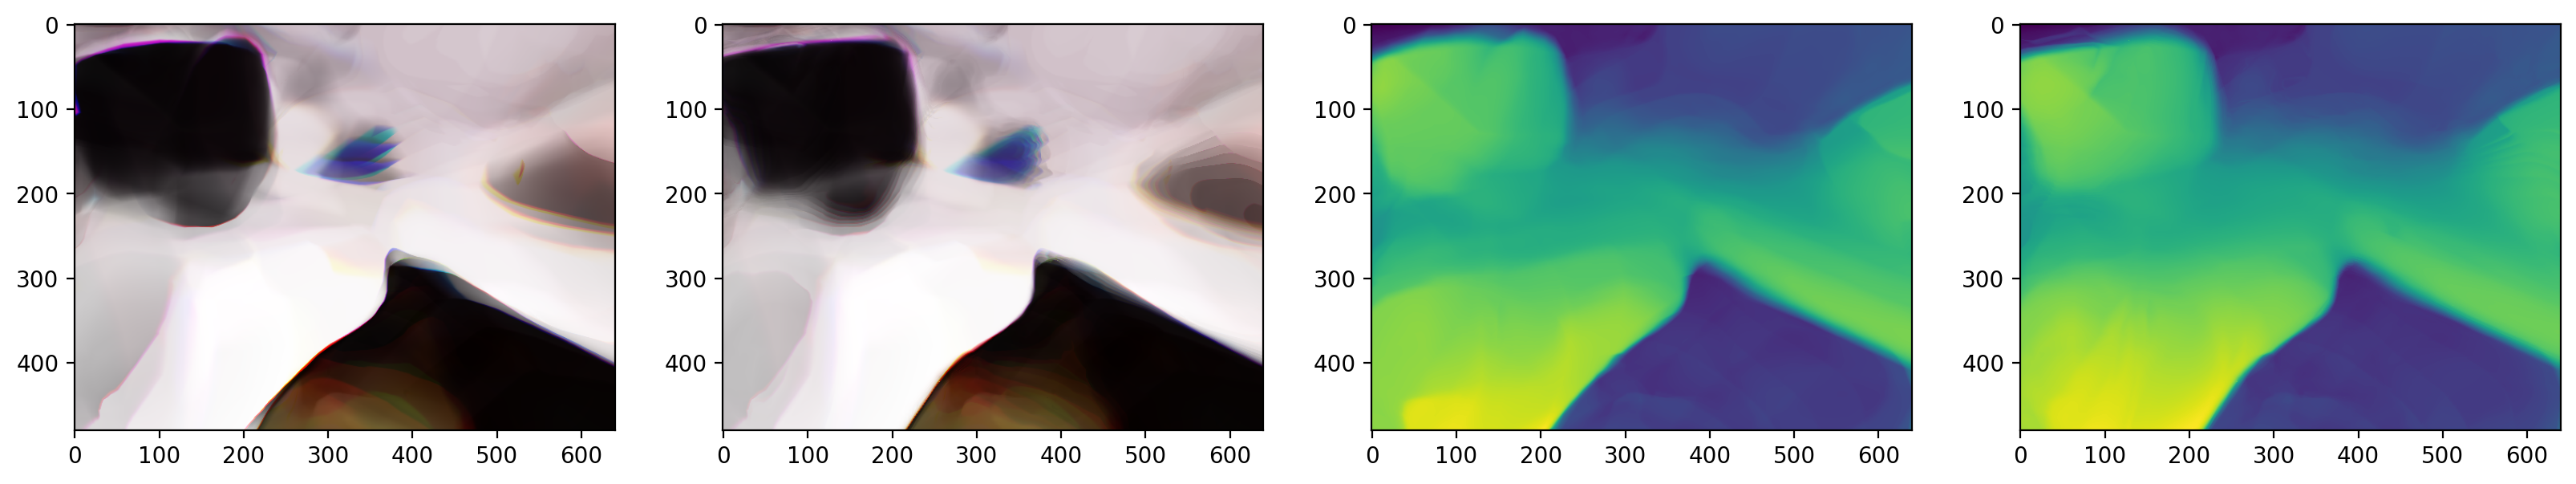

In [16]:
indx = 0
figure = plt.figure(dpi=200, figsize=(20,18))
plt.subplot(1,4,1)
plt.imshow(cv2.cvtColor(color_coarse_images[indx], cv2.COLOR_RGB2BGR))


plt.subplot(1,4,2)
plt.imshow(cv2.cvtColor(color_fine_images[indx], cv2.COLOR_RGB2BGR))

plt.subplot(1,4,3)
plt.imshow(1. /depth_coarse_images[indx])


plt.subplot(1,4,4)
plt.imshow(1. /depth_fine_images[indx])

### Tracking

In [18]:
dataset_params = {'dataset_path': "/home/quetalasj/datasets/TUM RGBD/", 
                  'scene_name': "rgbd_dataset_freiburg1_desk", 
                  'association_file_name': "data_association_file.txt", 
                  'frame_indices': [*range(573)],
                  'distance_koef': 0.1,
                  'clip_distance_threshold': 4.}
camera, tracking_dataset_loader = TUMDatasetLoaderFactory.make_dataset_loader(**dataset_params)

Reading /home/quetalasj/datasets/TUM RGBD/rgbd_dataset_freiburg1_desk/data_association_file.txt


In [19]:
poses = []
num_epochs = 100

model.cuda()
model.eval()
model.requires_grad_(False)

is_image_active_sampling = False

is_initialization = True

for color_image, depth_image, p in tracking_dataset_loader:
    if is_initialization:
        current_position = p
        process_position = True
    print(current_position)
    
    state = camera.create_state(color_image, depth_image, current_position, process_position)
    process_position = False
    state.train_position()
    state._position.cuda()
    if is_initialization:
        is_initialization = False
        trainer = ModelTrainer([state._position], image_active_sampler, lr=0.005)
    else:
        trainer.optimizer.add_param_group({'params':state._position})
    trainer.reset_params()
    # trainer.optimizer.param_groups.clear()
    # trainer.optimizer.state.clear()
    
    
    for i in tqdm(range(num_epochs)):
        loss = trainer.train(model, state, is_image_active_sampling)
        if i%20 == 0:
            print(f"loss {torch.mean(loss['loss']).item()}")
    print("-"*10)
    
    
    state.freeze_position()
    state._position.cpu()
    
    current_position = state.get_matrix_position().detach().numpy()
    poses.append(current_position.copy())

    # trainer.reset_params()

torch.cuda.empty_cache()

[[ 0.8722986   0.4882979   0.02569568  0.        ]
 [ 0.34789497 -0.58283824 -0.73434913  0.        ]
 [-0.34360474  0.64951116 -0.67828536  0.        ]
 [ 1.3112      0.8507      1.5186      1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5679318308830261
loss 0.7426658272743225
loss 0.6823748350143433
loss 0.6173368692398071
loss 0.6263941526412964
----------
[[ 0.86419976  0.50301254  0.01170731  0.        ]
 [ 0.34564152 -0.57659817 -0.74031484  0.        ]
 [-0.3656373   0.6438265  -0.6721581   0.        ]
 [ 0.13150893  0.08665265  0.15180813  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7641046643257141
loss 0.7325488328933716
loss 0.5652101039886475
loss 0.6234959959983826
loss 0.7960487008094788
----------
[[ 0.8784541   0.47781825  0.00284572  0.        ]
 [ 0.32427585 -0.5917758  -0.7380017   0.        ]
 [-0.35094666  0.64922345 -0.67479277  0.        ]
 [ 0.13245267  0.0855511   0.14985323  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6601274609565735
loss 0.6847758293151855
loss 0.5634874701499939
loss 0.630547821521759
loss 0.6146581768989563
----------
[[ 0.8875093   0.46073785  0.00692254  0.        ]
 [ 0.3141152  -0.5939454  -0.74064904  0.        ]
 [-0.33713338  0.65950745 -0.67185664  0.        ]
 [ 0.13549058  0.08469602  0.15100919  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7109397053718567
loss 0.7490600943565369
loss 0.782711386680603
loss 0.6291444301605225
loss 0.9809380173683167
----------
[[ 0.8961341   0.44377875  0.00202532  0.        ]
 [ 0.2984873  -0.5993533  -0.74275196  0.        ]
 [-0.3284037   0.6662098  -0.6695633   0.        ]
 [ 0.13341692  0.08378102  0.15160601  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8083879947662354
loss 0.5689374208450317
loss 0.6384816765785217
loss 0.6349488496780396
loss 0.7007290720939636
----------
[[ 0.90696347  0.42120203  0.00248219  0.        ]
 [ 0.28248242 -0.6038698  -0.7453491   0.        ]
 [-0.3124436   0.67670554 -0.66666996  0.        ]
 [ 0.13332921  0.08219535  0.15379041  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.854645848274231
loss 0.6470959186553955
loss 0.601294219493866
loss 0.6151506900787354
loss 0.6068043112754822
----------
[[ 0.91662073  0.39974943  0.00261317  0.        ]
 [ 0.26394406 -0.60028553 -0.7549777   0.        ]
 [-0.3002332   0.6927179  -0.6557455   0.        ]
 [ 0.13168503  0.08209583  0.1567316   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7204952836036682
loss 0.7662234902381897
loss 0.7360052466392517
loss 0.6326123476028442
loss 0.611498236656189
----------
[[ 0.9199538   0.39202386 -0.00149536  0.        ]
 [ 0.2535808  -0.59797275 -0.7603455   0.        ]
 [-0.29896778  0.69910353 -0.64951706  0.        ]
 [ 0.1323575   0.08080544  0.1563884   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7036359310150146
loss 0.6509023308753967
loss 0.5807451605796814
loss 0.619899570941925
loss 0.6000603437423706
----------
[[ 0.92280906  0.38514897 -0.00914626  0.        ]
 [ 0.2383239  -0.58935034 -0.77192473  0.        ]
 [-0.3026964   0.7101594  -0.635648    0.        ]
 [ 0.13682745  0.07981779  0.15633503  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6200271844863892
loss 0.7898472547531128
loss 0.7075713872909546
loss 0.6258920431137085
loss 0.6482837796211243
----------
[[ 0.9253771   0.37875968 -0.01477723  0.        ]
 [ 0.2262005  -0.58309054 -0.78028125  0.        ]
 [-0.3041556   0.7187118  -0.62525415  0.        ]
 [ 0.13743828  0.07768551  0.15868852  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7046876549720764
loss 0.7469573616981506
loss 0.5954471230506897
loss 0.6447046399116516
loss 0.6686444878578186
----------
[[ 0.92131835  0.38820636 -0.0216402   0.        ]
 [ 0.22387476 -0.5751747  -0.78679997  0.        ]
 [-0.31788766  0.7200486  -0.61682856  0.        ]
 [ 0.1365082   0.07685719  0.15768424  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7229887247085571
loss 0.8228846788406372
loss 0.7779956459999084
loss 0.7427730560302734
loss 0.703682541847229
----------
[[ 0.91604     0.40020326 -0.02660979  0.        ]
 [ 0.22601601 -0.5698668  -0.79004335  0.        ]
 [-0.33134198  0.717697   -0.612473    0.        ]
 [ 0.13815486  0.07432097  0.15781265  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7354342341423035
loss 0.7534536719322205
loss 0.6616388559341431
loss 0.657923698425293
loss 0.8000545501708984
----------
[[ 0.9110274   0.41130215 -0.02932084  0.        ]
 [ 0.22547418 -0.55643165 -0.7997158   0.        ]
 [-0.34523985  0.7219519  -0.5996624   0.        ]
 [ 0.13927156  0.07474917  0.15943772  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7755498290061951
loss 0.6137486696243286
loss 0.6091605424880981
loss 0.7033358812332153
loss 0.6183183789253235
----------
[[ 0.9011847   0.43214902 -0.03336695  0.        ]
 [ 0.23176065 -0.54549253 -0.80543464  0.        ]
 [-0.36626923  0.7181123  -0.59174466  0.        ]
 [ 0.13833062  0.07189789  0.15756759  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8548306226730347
loss 0.8291509747505188
loss 0.7000808715820312
loss 0.7909262776374817
loss 0.8384715914726257
----------
[[ 0.88994306  0.4541665  -0.0416435   0.        ]
 [ 0.23679808 -0.53817606 -0.8088839   0.        ]
 [-0.3897795   0.70999956 -0.5864918   0.        ]
 [ 0.13960631  0.07148002  0.15943812  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8183637857437134
loss 0.7897988557815552
loss 0.8007937669754028
loss 0.894354522228241
loss 0.7226671576499939
----------
[[ 0.8805138   0.47168088 -0.04703908  0.        ]
 [ 0.23934978 -0.5280628  -0.8147769   0.        ]
 [-0.40915424  0.7061635  -0.57786334  0.        ]
 [ 0.13973841  0.06880501  0.1594927   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8510468006134033
loss 0.673642635345459
loss 0.5843653082847595
loss 0.809518575668335
loss 0.7002999782562256
----------
[[ 0.8653905   0.49847555 -0.05120023  0.        ]
 [ 0.2512434  -0.5200287  -0.816362    0.        ]
 [-0.43356204  0.6936083  -0.5752666   0.        ]
 [ 0.13904329  0.06872781  0.15827721  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9421395659446716
loss 1.0114341974258423
loss 0.7131558060646057
loss 0.7068672776222229
loss 0.6525300741195679
----------
[[ 0.84777564  0.527043   -0.05917877  0.        ]
 [ 0.26497853 -0.51758254 -0.8135689   0.        ]
 [-0.45941573  0.67404276 -0.57844913  0.        ]
 [ 0.1374122   0.06729949  0.16144411  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0946648120880127
loss 1.1221362352371216
loss 0.7142297029495239
loss 0.7864678502082825
loss 0.7220428586006165
----------
[[ 0.8325515   0.5487051  -0.07603177  0.        ]
 [ 0.26901564 -0.5204712  -0.8103953   0.        ]
 [-0.48424032  0.6542421  -0.5809294   0.        ]
 [ 0.1388242   0.06434093  0.15984079  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0738545656204224
loss 0.7562280297279358
loss 0.8571920394897461
loss 0.8359166383743286
loss 0.959690511226654
----------
[[ 0.8054818   0.5863347  -0.08608502  0.        ]
 [ 0.28365988 -0.50899744 -0.81268597  0.        ]
 [-0.5203231   0.6301849  -0.5763078   0.        ]
 [ 0.14021212  0.06517572  0.1575729   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1041477918624878
loss 0.9883961081504822
loss 0.6942501068115234
loss 0.8822131752967834
loss 0.910212516784668
----------
[[ 0.7852864   0.6136197  -0.0824382   0.        ]
 [ 0.30401954 -0.49816728 -0.8120355   0.        ]
 [-0.53934896  0.6126177  -0.5777563   0.        ]
 [ 0.13658671  0.06232886  0.15807226  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9569763541221619
loss 0.8404685854911804
loss 0.9764283299446106
loss 0.8316435813903809
loss 0.8441847562789917
----------
[[ 0.7672783   0.6374276  -0.07049885  0.        ]
 [ 0.32188797 -0.47785676 -0.8173379   0.        ]
 [-0.554682    0.6044328  -0.57182944  0.        ]
 [ 0.13461825  0.06017824  0.1598123   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9578184485435486
loss 0.8011079430580139
loss 0.9236515760421753
loss 0.8426211476325989
loss 0.9041599035263062
----------
[[ 0.73970765  0.6690056  -0.07255453  0.        ]
 [ 0.33837265 -0.46298027 -0.81923944  0.        ]
 [-0.58166707  0.5814472  -0.56884325  0.        ]
 [ 0.1354162   0.06173214  0.15986164  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0174845457077026
loss 0.9413676261901855
loss 0.9407369494438171
loss 0.8187263011932373
loss 0.940946638584137
----------
[[ 0.7146293   0.6959235  -0.07067767  0.        ]
 [ 0.3580677  -0.45073688 -0.8176942   0.        ]
 [-0.6009097   0.5590409  -0.5712975   0.        ]
 [ 0.13341781  0.06188121  0.1579634   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.109674096107483
loss 1.0084171295166016
loss 0.8951884508132935
loss 0.9439347386360168
loss 0.8950850367546082
----------
[[ 0.6855031   0.72452736 -0.07173166  0.        ]
 [ 0.36513543 -0.42735243 -0.8270705   0.        ]
 [-0.62988997  0.54076767 -0.55750203  0.        ]
 [ 0.13259943  0.05959209  0.15838403  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1353930234909058
loss 1.039521336555481
loss 1.2142646312713623
loss 1.1160441637039185
loss 1.1249232292175293
----------
[[ 0.6476087   0.758505   -0.07261652  0.        ]
 [ 0.3874675  -0.40987313 -0.825756    0.        ]
 [-0.65610355  0.50663024 -0.55933344  0.        ]
 [ 0.1355337   0.06001085  0.15687428  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3396011590957642
loss 0.9530935287475586
loss 1.0342168807983398
loss 1.069666862487793
loss 0.9652926325798035
----------
[[ 0.619041    0.7837392  -0.05040985  0.        ]
 [ 0.41948056 -0.38422823 -0.82243836  0.        ]
 [-0.66394603  0.48797715 -0.5666164   0.        ]
 [ 0.13176975  0.0567845   0.16339198  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.308561086654663
loss 0.9997338056564331
loss 0.9740239977836609
loss 0.9193525314331055
loss 0.9603477120399475
----------
[[ 0.5887562   0.8075215  -0.0357098   0.        ]
 [ 0.43670923 -0.35495496 -0.82661504  0.        ]
 [-0.6801847   0.47108    -0.56163394  0.        ]
 [ 0.12592065  0.05393536  0.16179192  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1741286516189575
loss 0.912331759929657
loss 1.0528620481491089
loss 0.9643220901489258
loss 0.9725803732872009
----------
[[ 0.5618849   0.82709074 -0.01436543  0.        ]
 [ 0.4576181  -0.32525635 -0.82752293  0.        ]
 [-0.68910897  0.45839876 -0.5612483   0.        ]
 [ 0.1264049   0.05220518  0.15946005  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9803277254104614
loss 1.1362313032150269
loss 0.9339728951454163
loss 0.9667681455612183
loss 0.866542398929596
----------
[[ 0.537125    0.8434696  -0.00747061  0.        ]
 [ 0.47543922 -0.3100537  -0.82330084  0.        ]
 [-0.6967455   0.4386637  -0.56755626  0.        ]
 [ 0.1318456   0.0535248   0.15873215  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1719160079956055
loss 1.0548197031021118
loss 0.8758092522621155
loss 0.9824971556663513
loss 0.9051734805107117
----------
[[ 0.5088433   0.86079997  0.01010537  0.        ]
 [ 0.49226528 -0.28132188 -0.82373124  0.        ]
 [-0.70622486  0.42412466 -0.5668907   0.        ]
 [ 0.1294885   0.04869922  0.16085091  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9948919415473938
loss 0.8738858699798584
loss 1.0062941312789917
loss 0.8474525809288025
loss 0.8969711065292358
----------
[[ 0.4922943   0.8701682   0.02129909  0.        ]
 [ 0.48609173 -0.2545414  -0.8360165   0.        ]
 [-0.7220534   0.42191952 -0.5482907   0.        ]
 [ 0.13070488  0.04920267  0.16198997  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0540058612823486
loss 1.015214204788208
loss 0.9008514285087585
loss 0.9887124300003052
loss 0.9427902698516846
----------
[[ 0.46865726  0.88275814  0.03314266  0.        ]
 [ 0.49940154 -0.23381233 -0.8342241   0.        ]
 [-0.72866905  0.4075167  -0.55042875  0.        ]
 [ 0.12826388  0.04871829  0.16047424  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0776264667510986
loss 1.0153374671936035
loss 0.8099082708358765
loss 0.8842757344245911
loss 1.2071129083633423
----------
[[ 0.4361242   0.89862466  0.04763749  0.        ]
 [ 0.51196516 -0.20423758 -0.83437324  0.        ]
 [-0.740059    0.38827917 -0.5491376   0.        ]
 [ 0.12687297  0.04445148  0.16068336  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9423596262931824
loss 0.9718027114868164
loss 0.940464437007904
loss 0.9058679938316345
loss 0.922313392162323
----------
[[ 0.4059537   0.9117475   0.06259549  0.        ]
 [ 0.5285438  -0.17835283 -0.82995903  0.        ]
 [-0.7455489   0.37000945 -0.5543014   0.        ]
 [ 0.12754644  0.04812281  0.15770313  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1465331315994263
loss 0.929125964641571
loss 0.9154348373413086
loss 1.0081785917282104
loss 0.9654449224472046
----------
[[ 0.3794164   0.9217411   0.08022797  0.        ]
 [ 0.5401908  -0.15028882 -0.828014    0.        ]
 [-0.75115716  0.35750055 -0.5549382   0.        ]
 [ 0.1280501   0.04818836  0.16027826  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1203662157058716
loss 0.9178072214126587
loss 1.0112372636795044
loss 0.9890345335006714
loss 1.0599027872085571
----------
[[ 0.3514248   0.93220353  0.08658627  0.        ]
 [ 0.55422866 -0.13260925 -0.8217332   0.        ]
 [-0.7545403   0.33676594 -0.563256    0.        ]
 [ 0.1245172   0.04755918  0.15825285  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0802475214004517
loss 0.971781849861145
loss 0.8996388912200928
loss 1.010425090789795
loss 0.9992984533309937
----------
[[ 0.3229922   0.9413487   0.09766665  0.        ]
 [ 0.56264234 -0.10801554 -0.81961346  0.        ]
 [-0.7609925   0.31968018 -0.56453085  0.        ]
 [ 0.12624142  0.04514955  0.15777902  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.121806263923645
loss 0.8534156680107117
loss 0.9049345850944519
loss 0.9753777980804443
loss 0.987227737903595
----------
[[ 0.2878157   0.9518305   0.10573879  0.        ]
 [ 0.5781406  -0.08466554 -0.8115325   0.        ]
 [-0.763489    0.29470357 -0.5746598   0.        ]
 [ 0.12870045  0.04499411  0.15669025  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0470609664916992
loss 1.1549463272094727
loss 0.9664890766143799
loss 1.048038125038147
loss 1.089738130569458
----------
[[ 0.25353664  0.9630543   0.09080505  0.        ]
 [ 0.5805731  -0.07641172 -0.8106147   0.        ]
 [-0.7737274   0.25823954 -0.5784966   0.        ]
 [ 0.12704815  0.04683078  0.15723436  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3235141038894653
loss 1.0280358791351318
loss 0.9569404125213623
loss 0.9689454436302185
loss 0.8886779546737671
----------
[[ 0.21297652  0.97351956  0.08306888  0.        ]
 [ 0.584947   -0.05894411 -0.80892676  0.        ]
 [-0.7826097   0.2208733  -0.5820111   0.        ]
 [ 0.12686247  0.04583766  0.15539746  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0553975105285645
loss 0.8447049260139465
loss 0.8544292449951172
loss 0.7784401774406433
loss 0.8455459475517273
----------
[[ 0.196168    0.9773479   0.07943034  0.        ]
 [ 0.5942306  -0.05405235 -0.8024764   0.        ]
 [-0.7800052   0.20462003 -0.5913733   0.        ]
 [ 0.12579238  0.04226341  0.15414758  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.888691246509552
loss 0.8296533226966858
loss 0.7415652871131897
loss 0.8654714822769165
loss 0.8335528373718262
----------
[[ 0.16668344  0.9838419   0.06535742  0.        ]
 [ 0.5940281  -0.04729331 -0.8030528   0.        ]
 [-0.7869861   0.17267972 -0.5923128   0.        ]
 [ 0.12689148  0.04188716  0.1553001   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8164175152778625
loss 0.8363245725631714
loss 1.0662295818328857
loss 0.7836813926696777
loss 1.0585696697235107
----------
[[ 0.15873837  0.9863906   0.04284313  0.        ]
 [ 0.59592557 -0.06112301 -0.80070996  0.        ]
 [-0.78719413  0.15263459 -0.59751785  0.        ]
 [ 0.12745906  0.04069842  0.15287332  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8643315434455872
loss 0.9196819067001343
loss 0.8293644785881042
loss 1.023998498916626
loss 0.8466557264328003
----------
[[ 0.16849703  0.98515797  0.03274846  0.        ]
 [ 0.60213876 -0.07656944 -0.79471123  0.        ]
 [-0.7804087   0.15362558 -0.60610354  0.        ]
 [ 0.12858318  0.04113507  0.15486014  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8118971586227417
loss 0.8492456078529358
loss 0.7889665961265564
loss 0.8279468417167664
loss 0.802541196346283
----------
[[ 0.17383635  0.98465776  0.01516047  0.        ]
 [ 0.5934863  -0.09246707 -0.79951465  0.        ]
 [-0.7858466   0.14798215 -0.6004549   0.        ]
 [ 0.1322631   0.0436198   0.15445517  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.863475501537323
loss 0.9203335642814636
loss 0.8313765525817871
loss 0.8914544582366943
loss 0.902330219745636
----------
[[ 0.18891597  0.9819215   0.0118663   0.        ]
 [ 0.5990377  -0.10565937 -0.79371893  0.        ]
 [-0.778116    0.15705451 -0.6081687   0.        ]
 [ 0.12877718  0.04001129  0.1538193   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9139686226844788
loss 0.7835211157798767
loss 0.7918856739997864
loss 0.8225142955780029
loss 0.8241471648216248
----------
[[ 0.20210177  0.979318   -0.00955269  0.        ]
 [ 0.5930189  -0.13013232 -0.79460335  0.        ]
 [-0.7794124   0.15492591 -0.607054    0.        ]
 [ 0.13498741  0.04248016  0.15210432  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9012917876243591
loss 0.900530219078064
loss 0.6989150643348694
loss 0.7985356450080872
loss 0.7952327728271484
----------
[[ 0.23240584  0.97243804  0.01875117  0.        ]
 [ 0.59659237 -0.12730205 -0.7923835   0.        ]
 [-0.7681569   0.19534129 -0.609735    0.        ]
 [ 0.13209619  0.03568361  0.15201195  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9435254335403442
loss 0.9998739361763
loss 0.792448878288269
loss 0.8287033438682556
loss 0.8797283172607422
----------
[[ 0.25924885  0.96543616  0.02689087  0.        ]
 [ 0.5922391  -0.13691723 -0.7940445   0.        ]
 [-0.76291746  0.22178099 -0.60726476  0.        ]
 [ 0.12860289  0.03523573  0.15026739  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8199645280838013
loss 0.8580939769744873
loss 0.767865002155304
loss 0.7891448140144348
loss 0.7883773446083069
----------
[[ 0.26670486  0.9637529   0.00697508  0.        ]
 [ 0.59011143 -0.1575743  -0.79179454  0.        ]
 [-0.7619953   0.21529147 -0.61074746  0.        ]
 [ 0.12943141  0.03559732  0.14996412  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8024199604988098
loss 0.9407482147216797
loss 0.9557981491088867
loss 0.8245957493782043
loss 0.7513081431388855
----------
[[ 0.26656777  0.96381426 -0.00193653  0.        ]
 [ 0.59217596 -0.16536617 -0.78865814  0.        ]
 [-0.76044023  0.2090841  -0.61482894  0.        ]
 [ 0.13170323  0.03524467  0.14961885  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7014024257659912
loss 1.1485744714736938
loss 0.8017899394035339
loss 0.8140156269073486
loss 0.8536865711212158
----------
[[ 0.2774378   0.960739   -0.00297061  0.        ]
 [ 0.58953905 -0.1726842  -0.78906524  0.        ]
 [-0.7585988   0.21716523 -0.6143023   0.        ]
 [ 0.1343353   0.03846874  0.1477705   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8220440745353699
loss 0.7209793925285339
loss 0.7367284893989563
loss 0.8997674584388733
loss 0.7424894571304321
----------
[[ 0.2819513   0.9593591   0.01154813  0.        ]
 [ 0.5957646  -0.16563225 -0.7858945   0.        ]
 [-0.7520424   0.22846389 -0.6182525   0.        ]
 [ 0.12765992  0.03453771  0.15137991  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9014649987220764
loss 0.76725834608078
loss 0.7461757659912109
loss 0.7529417276382446
loss 0.6984485983848572
----------
[[ 0.29314977  0.9558631   0.01972127  0.        ]
 [ 0.5887325  -0.16422641 -0.79146945  0.        ]
 [-0.7532977   0.2436297  -0.6108905   0.        ]
 [ 0.13475662  0.03042042  0.14945348  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8491933941841125
loss 0.7840648293495178
loss 0.8173527121543884
loss 0.8068354725837708
loss 0.7330572605133057
----------
[[ 0.31024832  0.9504608   0.01923814  0.        ]
 [ 0.5937195  -0.17791688 -0.7847563   0.        ]
 [-0.7424574   0.25489137 -0.61950564  0.        ]
 [ 0.1325713   0.03217013  0.14757885  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8835539817810059
loss 0.7803618311882019
loss 0.8667831420898438
loss 0.8609199523925781
loss 0.9235574007034302
----------
[[ 0.3181082   0.947969    0.01271451  0.        ]
 [ 0.59142023 -0.1879443  -0.78415483  0.        ]
 [-0.740965    0.2569657  -0.62043476  0.        ]
 [ 0.13229267  0.03172028  0.14926988  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8713166117668152
loss 0.8445942401885986
loss 0.7616518139839172
loss 0.8072963356971741
loss 0.7417494058609009
----------
[[ 0.33060992  0.9437535   0.00513902  0.        ]
 [ 0.58669937 -0.20125759 -0.78439724  0.        ]
 [-0.7392434   0.26234457 -0.62023735  0.        ]
 [ 0.12997347  0.02923396  0.14640822  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7055719494819641
loss 0.6872504353523254
loss 0.9023705124855042
loss 0.8940500617027283
loss 0.7933685779571533
----------
[[ 0.34252405  0.9394474  -0.01075494  0.        ]
 [ 0.5782529  -0.21982646 -0.7856842   0.        ]
 [-0.74047333  0.26289657 -0.6185341   0.        ]
 [ 0.12948719  0.02784305  0.14790922  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8362700939178467
loss 0.8490655422210693
loss 0.8923600316047668
loss 1.189639925956726
loss 0.8899638056755066
----------
[[ 0.3671733   0.9301342  -0.00583437  0.        ]
 [ 0.5894164  -0.23751712 -0.77212286  0.        ]
 [-0.7195637   0.28006402 -0.6354462   0.        ]
 [ 0.13143665  0.02777633  0.1445853   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8571385145187378
loss 0.986405074596405
loss 0.9112315773963928
loss 1.0330584049224854
loss 0.990658700466156
----------
[[ 0.3913479   0.9202018  -0.00869739  0.        ]
 [ 0.58676517 -0.2568009  -0.7679584   0.        ]
 [-0.7089101   0.29543558 -0.6404408   0.        ]
 [ 0.13092865  0.02582788  0.14625518  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8118785619735718
loss 0.7433254718780518
loss 0.9681572318077087
loss 0.6812520623207092
loss 0.6780466437339783
----------
[[ 0.39776385  0.9173376  -0.01661101  0.        ]
 [ 0.5869362  -0.2683319  -0.76387453  0.        ]
 [-0.7051879   0.2940921  -0.64515126  0.        ]
 [ 0.12920696  0.02141652  0.1466509   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8845237493515015
loss 1.063569188117981
loss 0.7185190320014954
loss 0.7054013013839722
loss 0.7879620790481567
----------
[[ 0.4179399   0.9079008  -0.03228828  0.        ]
 [ 0.58514357 -0.29620993 -0.7548952   0.        ]
 [-0.694934    0.29660758 -0.65505016  0.        ]
 [ 0.12841885  0.02625943  0.14516614  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9451212882995605
loss 0.8502901196479797
loss 1.0522708892822266
loss 1.0377291440963745
loss 1.347271203994751
----------
[[ 0.43788648  0.898365   -0.03458026  0.        ]
 [ 0.5917181  -0.31695044 -0.7412235   0.        ]
 [-0.6768495   0.30411    -0.6703671   0.        ]
 [ 0.12477674  0.01909291  0.14663933  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8796610832214355
loss 1.0997823476791382
loss 0.8897534012794495
loss 0.8113802075386047
loss 0.7859592437744141
----------
[[ 0.45071614  0.890681   -0.05951688  0.        ]
 [ 0.5951371  -0.34951508 -0.7236372   0.        ]
 [-0.6653321   0.29073426 -0.6876093   0.        ]
 [ 0.11661194  0.02114695  0.14484832  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6074532270431519
loss 0.7776675224304199
loss 1.0007483959197998
loss 0.7346475124359131
loss 0.7563011050224304
----------
[[ 0.4781127   0.87646866 -0.0566645   0.        ]
 [ 0.58425343 -0.36555433 -0.72458106  0.        ]
 [-0.65578663  0.313325   -0.68685603  0.        ]
 [ 0.1250785   0.0190861   0.14582393  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8819795846939087
loss 0.8214735388755798
loss 0.7812809348106384
loss 1.0784027576446533
loss 0.8761082291603088
----------
[[ 0.49528283  0.8644292  -0.08635488  0.        ]
 [ 0.57038885 -0.39855647 -0.7181988   0.        ]
 [-0.65524924  0.30645573 -0.690459    0.        ]
 [ 0.12451398  0.01978726  0.1483135   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0073230266571045
loss 1.1052336692810059
loss 0.7761068344116211
loss 0.7851924896240234
loss 1.1041133403778076
----------
[[ 0.51585853  0.8513901  -0.09499958  0.        ]
 [ 0.55948246 -0.41880047 -0.7152523   0.        ]
 [-0.6487446   0.31581843 -0.6923796   0.        ]
 [ 0.11767244  0.01159544  0.15027723  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0029957294464111
loss 0.7589486241340637
loss 0.800535261631012
loss 0.9224545359611511
loss 0.7765057682991028
----------
[[ 0.5356877   0.8361915  -0.11756873  0.        ]
 [ 0.54603773 -0.44922984 -0.7071316   0.        ]
 [-0.64411294  0.31460476 -0.69723904  0.        ]
 [ 0.12163709  0.01175613  0.1473732   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.931464672088623
loss 0.7177006602287292
loss 0.8569431900978088
loss 0.7378516793251038
loss 0.9474212527275085
----------
[[ 0.5522356   0.8220949  -0.13854846  0.        ]
 [ 0.5382438  -0.47848582 -0.69379     0.        ]
 [-0.63665485  0.3085627  -0.7067245   0.        ]
 [ 0.12238918  0.01499392  0.14841685  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.210066318511963
loss 0.7478060126304626
loss 1.1582783460617065
loss 0.77827388048172
loss 0.7552419900894165
----------
[[ 0.568437    0.8115498  -0.13515376  0.        ]
 [ 0.5234029  -0.4834609  -0.7016517   0.        ]
 [-0.63476676  0.32810494 -0.6995846   0.        ]
 [ 0.11806874  0.00853521  0.15276167  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8812199234962463
loss 0.7956663966178894
loss 1.0480945110321045
loss 0.8412392139434814
loss 0.9079880118370056
----------
[[ 0.57049227  0.8096486  -0.13786821  0.        ]
 [ 0.51817745 -0.4850657  -0.70441675  0.        ]
 [-0.63720524  0.33042407 -0.69626784  0.        ]
 [ 0.11931604  0.01101953  0.15111488  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8222216367721558
loss 1.539199948310852
loss 0.9204612374305725
loss 0.7206629514694214
loss 0.7905302047729492
----------
[[ 0.57203805  0.8097878  -0.13044615  0.        ]
 [ 0.5251165  -0.48373485 -0.700181    0.        ]
 [-0.63009936  0.3320308  -0.70194757  0.        ]
 [ 0.11711098  0.01134458  0.14972046  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9840341210365295
loss 0.7834178805351257
loss 0.7224729657173157
loss 0.8106217980384827
loss 0.7416793704032898
----------
[[ 0.5742003   0.8111795  -0.11082453  0.        ]
 [ 0.53195894 -0.47254896 -0.70265037  0.        ]
 [-0.62234545  0.344508   -0.702852    0.        ]
 [ 0.11541469  0.0054006   0.15367846  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0767656564712524
loss 0.8872910737991333
loss 0.7595373392105103
loss 0.8504073619842529
loss 0.7670921683311462
----------
[[ 0.58626795  0.8050657  -0.09032798  0.        ]
 [ 0.53074354 -0.46593356 -0.7079669   0.        ]
 [-0.6120467   0.3671173  -0.7004453   0.        ]
 [ 0.11486667  0.00596446  0.15530346  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8740238547325134
loss 0.9608868956565857
loss 0.8020959496498108
loss 0.822344958782196
loss 0.857925534248352
----------
[[ 0.58734053  0.80334866 -0.0982959   0.        ]
 [ 0.5237434  -0.46986187 -0.71057934  0.        ]
 [-0.61702836  0.36587018 -0.6967174   0.        ]
 [ 0.11308838  0.0075116   0.15339774  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.102895975112915
loss 0.8197239637374878
loss 0.8408918380737305
loss 0.8883765339851379
loss 0.8389198780059814
----------
[[ 0.5937042   0.8017618  -0.06850797  0.        ]
 [ 0.5314657  -0.45462298 -0.7147464   0.        ]
 [-0.6042016   0.38793832 -0.6960205   0.        ]
 [ 0.11054772  0.00192533  0.15674266  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7974165678024292
loss 1.0467586517333984
loss 0.8902300000190735
loss 0.9329782724380493
loss 0.8799513578414917
----------
[[ 6.00930572e-01  7.96839952e-01 -6.26783371e-02  0.00000000e+00]
 [ 5.27888298e-01 -4.54536438e-01 -7.17447400e-01  0.00000000e+00]
 [-6.00180268e-01  3.98048997e-01 -6.93787336e-01  0.00000000e+00]
 [ 1.09958954e-01 -9.52246366e-04  1.58388019e-01  1.00000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7846426367759705
loss 1.0168226957321167
loss 0.7772858738899231
loss 0.7995932102203369
loss 0.8838085532188416
----------
[[ 6.0269988e-01  7.9566801e-01 -6.0541421e-02  0.0000000e+00]
 [ 5.3627646e-01 -4.6006000e-01 -7.0763838e-01  0.0000000e+00]
 [-5.9089792e-01  3.9402664e-01 -7.0397604e-01  0.0000000e+00]
 [ 1.0699677e-01  4.1816290e-04  1.5934862e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8247455954551697
loss 0.8882428407669067
loss 0.8588085770606995
loss 0.7856423854827881
loss 0.8647688031196594
----------
[[ 0.5984845   0.79869175 -0.06251279  0.        ]
 [ 0.5368204  -0.4577284  -0.7087374   0.        ]
 [-0.5946766   0.3906102  -0.7026973   0.        ]
 [ 0.11045551  0.00284216  0.16224147  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.992379903793335
loss 0.8289973139762878
loss 0.775642991065979
loss 0.9566858410835266
loss 0.8468764424324036
----------
[[ 6.0132760e-01  7.9764694e-01 -4.6525568e-02  0.0000000e+00]
 [ 5.4208618e-01 -4.5005858e-01 -7.0964074e-01  0.0000000e+00]
 [-5.8698189e-01  4.0150571e-01 -7.0302606e-01  0.0000000e+00]
 [ 1.0893797e-01 -7.9717324e-04  1.6003978e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8643305897712708
loss 1.0500686168670654
loss 0.8380277752876282
loss 0.9740618467330933
loss 1.0989996194839478
----------
[[ 0.61005354  0.7912049  -0.04277268  0.        ]
 [ 0.5459086  -0.4588182  -0.7010491   0.        ]
 [-0.5742984   0.4043275  -0.7118292   0.        ]
 [ 0.10995942 -0.00205357  0.16104934  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8044682741165161
loss 0.9880656003952026
loss 1.1528427600860596
loss 0.8878716826438904
loss 0.8037368655204773
----------
[[ 0.61096454  0.7913792  -0.02100551  0.        ]
 [ 0.5697428  -0.45796812 -0.68239146  0.        ]
 [-0.5496503   0.40494925 -0.7306849   0.        ]
 [ 0.10352664 -0.00468674  0.16187336  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9965535402297974
loss 0.9628745317459106
loss 0.7830055952072144
loss 0.9715760350227356
loss 0.9070088863372803
----------
[[ 0.61774063  0.7863697   0.00438082  0.        ]
 [ 0.58552647 -0.45623338 -0.6700821   0.        ]
 [-0.5249335   0.41650203 -0.74227405  0.        ]
 [ 0.10467236 -0.00498845  0.16531245  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8698742389678955
loss 0.824938178062439
loss 0.9764007329940796
loss 0.8936643004417419
loss 0.8467527627944946
----------
[[ 0.6157485   0.7879373  -0.0029397   0.        ]
 [ 0.58732796 -0.4614594  -0.6649069   0.        ]
 [-0.52526146  0.40768892 -0.7469206   0.        ]
 [ 0.10607018 -0.00214253  0.16375513  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8165766596794128
loss 0.9353570342063904
loss 0.7963431477546692
loss 0.7661312818527222
loss 0.8556113839149475
----------
[[ 0.61786443  0.7862676   0.00518253  0.        ]
 [ 0.5925048  -0.46124864 -0.66044515  0.        ]
 [-0.5168961   0.41113624 -0.7508565   0.        ]
 [ 0.10376766 -0.00391871  0.16140933  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.144557237625122
loss 1.392997145652771
loss 1.1686599254608154
loss 1.0284968614578247
loss 0.9318722486495972
----------
[[ 0.62950504  0.7767345   0.02017407  0.        ]
 [ 0.5876566  -0.45895982 -0.666345    0.        ]
 [-0.508314    0.43132296 -0.74537075  0.        ]
 [ 0.09846262 -0.005363    0.16449358  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1508333683013916
loss 1.4195199012756348
loss 1.165846824645996
loss 0.8254632353782654
loss 0.816199779510498
----------
[[ 0.6475606   0.7607591   0.04371454  0.        ]
 [ 0.580744   -0.45556283 -0.6746845   0.        ]
 [-0.49335766  0.46228608 -0.7368108   0.        ]
 [ 0.10183631 -0.00578122  0.16555677  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0178990364074707
loss 1.146121859550476
loss 1.020067811012268
loss 1.057398796081543
loss 0.8925755023956299
----------
[[ 0.67434347  0.73456895  0.07529579  0.        ]
 [ 0.58205175 -0.46602666 -0.6663596   0.        ]
 [-0.4543972   0.4931813  -0.741819    0.        ]
 [ 0.09827252 -0.01422726  0.16714498  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5085690021514893
loss 1.1873160600662231
loss 0.8928555846214294
loss 0.9512240290641785
loss 1.125421166419983
----------
[[ 0.6997715   0.707808    0.0965796   0.        ]
 [ 0.56500864 -0.46565485 -0.68112475  0.        ]
 [-0.43713278  0.5312     -0.72576964  0.        ]
 [ 0.09724576 -0.00836077  0.1661617   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0436853170394897
loss 0.9653565883636475
loss 0.9520460963249207
loss 0.7737716436386108
loss 0.8582821488380432
----------
[[ 0.7315505   0.6731525   0.10816462  0.        ]
 [ 0.53812796 -0.47267938 -0.6978486   0.        ]
 [-0.41863137  0.5687179  -0.70803094  0.        ]
 [ 0.09553528 -0.0103451   0.16715066  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8659546971321106
loss 1.3602956533432007
loss 1.0081243515014648
loss 0.8634943962097168
loss 0.944934070110321
----------
[[ 0.7516147   0.64813167  0.12247734  0.        ]
 [ 0.52662164 -0.47784102 -0.70309174  0.        ]
 [-0.39717126  0.5929533  -0.7004725   0.        ]
 [ 0.09306282 -0.01211081  0.16695     1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8574030995368958
loss 0.7570412755012512
loss 0.8119736313819885
loss 0.7788776159286499
loss 0.7920185923576355
----------
[[ 0.76534784  0.63476086  0.10640234  0.        ]
 [ 0.51602817 -0.50638235 -0.6908633   0.        ]
 [-0.38465267  0.5836573  -0.71511304  0.        ]
 [ 0.09301662 -0.00697773  0.16423954  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0473719835281372
loss 0.9732939004898071
loss 0.9156529903411865
loss 0.7856019139289856
loss 0.6888231039047241
----------
[[ 0.7692766   0.634444    0.07546031  0.        ]
 [ 0.4990002  -0.52284837 -0.6911065   0.        ]
 [-0.39901412  0.5693068  -0.7188027   0.        ]
 [ 0.09061304 -0.0082069   0.16524579  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8651357889175415
loss 0.8697223663330078
loss 0.9283666610717773
loss 0.8352064490318298
loss 0.8471179008483887
----------
[[ 0.78874135  0.60859984  0.08656421  0.        ]
 [ 0.49042693 -0.53808415 -0.6855268   0.        ]
 [-0.37063265  0.58315676 -0.722883    0.        ]
 [ 0.0890293  -0.01102144  0.16399649  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8843507766723633
loss 0.8038323521614075
loss 0.7808897495269775
loss 0.8654246926307678
loss 0.7598915100097656
----------
[[ 0.7950603   0.6016116   0.0770881   0.        ]
 [ 0.48965856 -0.5616524  -0.66691923  0.        ]
 [-0.35792965  0.5679879  -0.7411319   0.        ]
 [ 0.08652048 -0.00743038  0.1599855   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8746738433837891
loss 0.843571126461029
loss 0.7726765275001526
loss 0.9416292905807495
loss 0.8769016265869141
----------
[[ 0.820281    0.56659317  0.07817456  0.        ]
 [ 0.4682045  -0.586673   -0.6607566   0.        ]
 [-0.3285173   0.5786078  -0.74651825  0.        ]
 [ 0.08336062 -0.00963319  0.15712397  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7693833708763123
loss 0.8523140549659729
loss 1.100711703300476
loss 1.0035209655761719
loss 1.041155457496643
----------
[[ 0.8326584   0.54844946  0.07670202  0.        ]
 [ 0.4581816  -0.604475   -0.6516744   0.        ]
 [-0.311046    0.5777656  -0.75461066  0.        ]
 [ 0.08087939 -0.0118108   0.15544285  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.952107310295105
loss 1.097793459892273
loss 0.8330003023147583
loss 0.8422315716743469
loss 0.8772878050804138
----------
[[ 0.8351538   0.5490837   0.03201813  0.        ]
 [ 0.4345169  -0.62296844 -0.6504656   0.        ]
 [-0.33721378  0.5571513  -0.7588606   0.        ]
 [ 0.07295994 -0.00170826  0.14903677  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.535607933998108
loss 0.9459130167961121
loss 0.8130400776863098
loss 0.7829472422599792
loss 0.8419581651687622
----------
[[ 0.8430393   0.5376491   0.01477192  0.        ]
 [ 0.4201092  -0.6410891  -0.64227164  0.        ]
 [-0.33584666  0.5476661  -0.76633465  0.        ]
 [ 0.07414991 -0.00875024  0.15600766  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0803816318511963
loss 1.0033425092697144
loss 0.9164955019950867
loss 0.7716997861862183
loss 0.8813126683235168
----------
[[ 0.85496736  0.5186427   0.00636908  0.        ]
 [ 0.40718484 -0.6635246  -0.62764287  0.        ]
 [-0.3212964   0.5392076  -0.7784754   0.        ]
 [ 0.07551221 -0.01061937  0.15916377  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9363133311271667
loss 0.8472473621368408
loss 0.9006504416465759
loss 0.900235116481781
loss 0.8371033072471619
----------
[[ 0.8679634   0.49661082  0.0041607   0.        ]
 [ 0.38558346 -0.6685854  -0.6358609   0.        ]
 [-0.31299362  0.5535083  -0.77179253  0.        ]
 [ 0.07436711 -0.00831955  0.15435584  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0489908456802368
loss 1.1335210800170898
loss 0.8929305672645569
loss 0.9332935810089111
loss 0.813584566116333
----------
[[ 0.8746685   0.484719    0.00161119  0.        ]
 [ 0.38061073 -0.68474066 -0.6215028   0.        ]
 [-0.300151    0.5442222  -0.78341043  0.        ]
 [ 0.07218543 -0.00778151  0.15427455  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1077632904052734
loss 1.0415676832199097
loss 1.0357608795166016
loss 0.8985819816589355
loss 1.0022228956222534
----------
[[ 0.8792819   0.47627538  0.00501484  0.        ]
 [ 0.37774873 -0.6908951  -0.61641675  0.        ]
 [-0.2901194   0.5438984  -0.78740394  0.        ]
 [ 0.06981784 -0.00951708  0.15150113  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0236395597457886
loss 1.1583455801010132
loss 0.9172358512878418
loss 0.9336421489715576
loss 0.997920036315918
----------
[[ 0.88566655  0.46368432  0.02432214  0.        ]
 [ 0.38011473 -0.69396794 -0.6114908   0.        ]
 [-0.26665992  0.5508221  -0.79087734  0.        ]
 [ 0.06965774 -0.01124019  0.15181753  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1243330240249634
loss 1.0277127027511597
loss 1.0507855415344238
loss 0.9247280955314636
loss 0.9662278294563293
----------
[[ 0.89551425  0.44500634  0.004852    0.        ]
 [ 0.36326084 -0.72462726 -0.58562493  0.        ]
 [-0.25709096  0.526198   -0.8105675   0.        ]
 [ 0.06709533 -0.01186173  0.15382493  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8532164096832275
loss 1.2940539121627808
loss 0.9162710309028625
loss 0.9559425115585327
loss 0.9596702456474304
----------
[[ 0.9019199   0.43186542 -0.00572476  0.        ]
 [ 0.34631822 -0.7310538  -0.58789814  0.        ]
 [-0.25807795  0.5282544  -0.8089149   0.        ]
 [ 0.06783912 -0.01047323  0.15114515  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9741389155387878
loss 0.99566650390625
loss 1.08503258228302
loss 1.0670632123947144
loss 0.9591721892356873
----------
[[ 0.9163017   0.40048003  0.00262552  0.        ]
 [ 0.32481074 -0.73930275 -0.5898556   0.        ]
 [-0.23428431  0.5413385  -0.80750465  0.        ]
 [ 0.06807714 -0.01037503  0.1492105   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0856132507324219
loss 1.0426298379898071
loss 1.037214756011963
loss 0.9306891560554504
loss 1.0345796346664429
----------
[[ 0.92051196  0.39066926  0.0059332   0.        ]
 [ 0.3173634  -0.7387556  -0.59457606  0.        ]
 [-0.2278994   0.5491974  -0.80401754  0.        ]
 [ 0.06553699 -0.01919652  0.1545301   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5203484296798706
loss 1.020336389541626
loss 1.0098896026611328
loss 1.164590835571289
loss 1.1017757654190063
----------
[[ 0.932662    0.3603089  -0.01786263  0.        ]
 [ 0.27813148 -0.74971414 -0.60047585  0.        ]
 [-0.22974867  0.55507284 -0.7994431   0.        ]
 [ 0.06807465 -0.01243652  0.15358667  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0118227005004883
loss 1.2355657815933228
loss 1.5023168325424194
loss 1.199375867843628
loss 1.0034595727920532
----------
[[ 9.4130301e-01  3.3756277e-01  1.6902387e-04  0.0000000e+00]
 [ 2.6667550e-01 -7.4332464e-01 -6.1347556e-01  0.0000000e+00]
 [-2.0696090e-01  5.7751143e-01 -7.8971338e-01  0.0000000e+00]
 [ 6.5403417e-02 -1.5866635e-02  1.5272270e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0479751825332642
loss 1.0554378032684326
loss 0.9946302771568298
loss 1.0168818235397339
loss 1.1760528087615967
----------
[[ 0.94777244  0.31773615 -0.02776949  0.        ]
 [ 0.23552465 -0.7559289  -0.610819    0.        ]
 [-0.21507101  0.57237697 -0.79128337  0.        ]
 [ 0.06618134 -0.01542355  0.15486279  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3057609796524048
loss 1.1325660943984985
loss 1.2026526927947998
loss 1.14736807346344
loss 1.3185672760009766
----------
[[ 0.9556172   0.2933622  -0.02709953  0.        ]
 [ 0.21841908 -0.7672019  -0.6030711   0.        ]
 [-0.19770905  0.57038605 -0.79722714  0.        ]
 [ 0.06439909 -0.0173973   0.15766102  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2659374475479126
loss 1.0587602853775024
loss 1.2206887006759644
loss 1.4775652885437012
loss 1.084197998046875
----------
[[ 0.97297704  0.22394049  0.05626984  0.        ]
 [ 0.20511958 -0.7263763  -0.65597546  0.        ]
 [-0.1060264   0.6497911  -0.752682    0.        ]
 [ 0.05559643 -0.02008492  0.15352397  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2498664855957031
loss 1.1225676536560059
loss 1.1109014749526978
loss 1.1240288019180298
loss 1.2125920057296753
----------
[[ 0.97610277  0.20909362  0.05918781  0.        ]
 [ 0.19460471 -0.7198622  -0.6662785   0.        ]
 [-0.09670752  0.66187453 -0.74335     0.        ]
 [ 0.05362793 -0.02397386  0.15413906  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1090806722640991
loss 1.0448520183563232
loss 1.3300578594207764
loss 1.3194713592529297
loss 1.1994789838790894
----------
[[ 0.97812647  0.20164159  0.05108097  0.        ]
 [ 0.18355125 -0.7211455  -0.6680255   0.        ]
 [-0.09786491  0.66278934 -0.742383    0.        ]
 [ 0.05185448 -0.02167219  0.15765908  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1695541143417358
loss 1.5587083101272583
loss 1.3337799310684204
loss 1.199258804321289
loss 1.2311806678771973
----------
[[ 0.9796499   0.1920802   0.05823508  0.        ]
 [ 0.17940453 -0.7078761  -0.683173    0.        ]
 [-0.09000078  0.67971796 -0.72793067  0.        ]
 [ 0.0518741  -0.02875618  0.15718117  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1226565837860107
loss 1.1359827518463135
loss 1.3010995388031006
loss 1.2309471368789673
loss 1.1532139778137207
----------
[[ 0.98288697  0.17447796  0.05908196  0.        ]
 [ 0.1680708  -0.7181138  -0.67532593  0.        ]
 [-0.07540191  0.67369896 -0.7351494   0.        ]
 [ 0.04755712 -0.03020708  0.16286999  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.416995644569397
loss 1.217055320739746
loss 1.3679418563842773
loss 1.1768423318862915
loss 1.2432464361190796
----------
[[ 0.9837747   0.17279881  0.04824837  0.        ]
 [ 0.16027126 -0.7256048  -0.66918653  0.        ]
 [-0.0806254   0.6660616  -0.74152625  0.        ]
 [ 0.04910979 -0.02532594  0.16315737  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.448103904724121
loss 1.4659316539764404
loss 1.28912353515625
loss 1.2598588466644287
loss 1.1209566593170166
----------
[[ 0.9867641   0.15330108  0.05287153  0.        ]
 [ 0.14841963 -0.72243345 -0.6753237   0.        ]
 [-0.06533168  0.67423236 -0.7356243   0.        ]
 [ 0.04969372 -0.03517544  0.16058268  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3618046045303345
loss 1.144128680229187
loss 1.1834784746170044
loss 1.4423933029174805
loss 1.2398931980133057
----------
[[ 0.9861539   0.15556785  0.05743816  0.        ]
 [ 0.15348768 -0.7251086  -0.6713116   0.        ]
 [-0.06278561  0.67083263 -0.73894644  0.        ]
 [ 0.0479616  -0.02825273  0.15663803  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.556709885597229
loss 1.2608999013900757
loss 1.1667174100875854
loss 1.2152671813964844
loss 1.5818159580230713
----------
[[ 0.9863143   0.15542288  0.0550256   0.        ]
 [ 0.15165405 -0.72425365 -0.67264974  0.        ]
 [-0.06469267  0.67178893 -0.7379123   0.        ]
 [ 0.04696929 -0.03102902  0.16226403  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.32004976272583
loss 1.1927964687347412
loss 1.185805320739746
loss 1.2224916219711304
loss 1.196569561958313
----------
[[ 0.9841689   0.15690069  0.08242413  0.        ]
 [ 0.17027096 -0.7079717  -0.6854077   0.        ]
 [-0.04918699  0.6885914  -0.7234795   0.        ]
 [ 0.04422561 -0.03351786  0.1635322   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4602835178375244
loss 1.307240605354309
loss 1.486641526222229
loss 1.5348583459854126
loss 1.2262681722640991
----------
[[ 0.98458683  0.15111405  0.08805316  0.        ]
 [ 0.16876999 -0.6888149  -0.7050181   0.        ]
 [-0.04588581  0.7090122  -0.7037016   0.        ]
 [ 0.04323491 -0.03229211  0.15903103  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5459285974502563
loss 1.3688410520553589
loss 1.550689458847046
loss 1.1191952228546143
loss 1.4073494672775269
----------
[[ 0.98575085  0.13245928  0.10368118  0.        ]
 [ 0.16703781 -0.6981182  -0.69622505  0.        ]
 [-0.01983975  0.70362306 -0.7102963   0.        ]
 [ 0.03931548 -0.03127477  0.16607344  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3341162204742432
loss 1.5425961017608643
loss 1.1079710721969604
loss 1.2994885444641113
loss 1.249972939491272
----------
[[ 0.98692685  0.11612485  0.11176063  0.        ]
 [ 0.16114853 -0.6999794  -0.6957444   0.        ]
 [-0.00256309  0.70465887 -0.7095417   0.        ]
 [ 0.03884956 -0.02970637  0.16876209  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3385870456695557
loss 1.4109084606170654
loss 1.3218460083007812
loss 1.1535598039627075
loss 1.1681019067764282
----------
[[ 0.98923963  0.09117798  0.11441799  0.        ]
 [ 0.14552844 -0.69365954 -0.70544875  0.        ]
 [ 0.01504573  0.7145089  -0.69946456  0.        ]
 [ 0.03521379 -0.02864709  0.17053396  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3152973651885986
loss 1.2908211946487427
loss 1.5210241079330444
loss 1.246738076210022
loss 1.4344011545181274
----------
[[ 0.99174565  0.08085156  0.099517    0.        ]
 [ 0.12802276 -0.6675277  -0.7334966   0.        ]
 [ 0.007126    0.74018246 -0.6723685   0.        ]
 [ 0.03357934 -0.03074034  0.168677    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2180418968200684
loss 1.477441430091858
loss 1.3668017387390137
loss 1.1148180961608887
loss 1.178660273551941
----------
[[ 0.99219066  0.07517727  0.09952942  0.        ]
 [ 0.12443066 -0.6518787  -0.74804497  0.        ]
 [ 0.00864513  0.75458777 -0.65614235  0.        ]
 [ 0.03329656 -0.03098397  0.16937837  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2313743829727173
loss 1.2056255340576172
loss 1.246212124824524
loss 1.1390109062194824
loss 1.5580592155456543
----------
[[ 0.9929382   0.06270435  0.10070655  0.        ]
 [ 0.11714852 -0.65210867 -0.74901944  0.        ]
 [ 0.01870485  0.7555277  -0.6548494   0.        ]
 [ 0.02859269 -0.02735849  0.16986299  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1761674880981445
loss 1.2801716327667236
loss 1.2641209363937378
loss 1.164880633354187
loss 1.2530256509780884
----------
[[ 0.9914079   0.05003626  0.12085876  0.        ]
 [ 0.12500182 -0.6345985  -0.7626658   0.        ]
 [ 0.03853584  0.7712204  -0.63540053  0.        ]
 [ 0.03006787 -0.03319934  0.16980799  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.27315354347229
loss 1.234494924545288
loss 1.1879336833953857
loss 1.2419763803482056
loss 1.2006607055664062
----------
[[ 0.99184376  0.0530441   0.11589789  0.        ]
 [ 0.12311442 -0.6340991  -0.763388    0.        ]
 [ 0.03299751  0.7714303  -0.63545775  0.        ]
 [ 0.02206673 -0.03588996  0.17146662  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3539146184921265
loss 1.1835963726043701
loss 1.2628440856933594
loss 1.2077558040618896
loss 1.1549814939498901
----------
[[ 0.9916839   0.03185192  0.12469372  0.        ]
 [ 0.11636728 -0.6357603  -0.7630647   0.        ]
 [ 0.05497023  0.7712292  -0.6341797   0.        ]
 [ 0.02635923 -0.03236027  0.16856334  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4066399335861206
loss 1.2168583869934082
loss 1.039102554321289
loss 1.197746992111206
loss 1.1579269170761108
----------
[[ 0.9926055   0.0327733   0.11687687  0.        ]
 [ 0.11120567 -0.6314937  -0.7673651   0.        ]
 [ 0.04865792  0.77468824 -0.6304687   0.        ]
 [ 0.02192613 -0.02961814  0.16724077  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2117424011230469
loss 1.580740213394165
loss 1.0755276679992676
loss 1.2476541996002197
loss 1.0450550317764282
----------
[[ 0.99131954  0.03117352  0.12772535  0.        ]
 [ 0.1181423  -0.63748074 -0.76135415  0.        ]
 [ 0.05768839  0.76983505 -0.63563013  0.        ]
 [ 0.02195771 -0.03356516  0.1679042   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2810698747634888
loss 1.2123700380325317
loss 1.111928939819336
loss 1.0177721977233887
loss 1.0210245847702026
----------
[[ 0.99304444  0.02704398  0.11459209  0.        ]
 [ 0.10406826 -0.65681446 -0.7468363   0.        ]
 [ 0.05506833  0.7535671  -0.6550604   0.        ]
 [ 0.0177409  -0.02805794  0.16793212  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0802562236785889
loss 1.291752576828003
loss 1.14214026927948
loss 1.170810341835022
loss 1.246464490890503
----------
[[ 0.99253356  0.02777686  0.11876685  0.        ]
 [ 0.10885711 -0.64096665 -0.7598105   0.        ]
 [ 0.05502044  0.76706606 -0.63920474  0.        ]
 [ 0.01456275 -0.02590694  0.16697255  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1171207427978516
loss 1.0750236511230469
loss 1.0208185911178589
loss 1.198398232460022
loss 1.0414748191833496
----------
[[ 0.9926963   0.03039792  0.11674792  0.        ]
 [ 0.10943346 -0.63421977 -0.7653688   0.        ]
 [ 0.05077823  0.7725549  -0.63291407  0.        ]
 [ 0.01128856 -0.02941424  0.16429487  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0620338916778564
loss 1.3492661714553833
loss 1.1762478351593018
loss 1.256493330001831
loss 0.9797573685646057
----------
[[ 0.9945246   0.02784887  0.10072388  0.        ]
 [ 0.09558761 -0.6319641  -0.7690801   0.        ]
 [ 0.04223587  0.774497   -0.63116586  0.        ]
 [ 0.01269879 -0.02331439  0.1622126   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4130358695983887
loss 1.12173330783844
loss 1.157541036605835
loss 1.016533613204956
loss 0.9937899708747864
----------
[[ 0.9952689   0.02932991  0.09262598  0.        ]
 [ 0.09109859 -0.6131333  -0.7847091   0.        ]
 [ 0.03377663  0.7894347  -0.6129043   0.        ]
 [ 0.00751768 -0.02297753  0.1639784   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0395516157150269
loss 0.9994664788246155
loss 0.9818337559700012
loss 0.9952442049980164
loss 1.2976598739624023
----------
[[ 0.99720824  0.01907176  0.07219441  0.        ]
 [ 0.06948721 -0.590968   -0.80369675  0.        ]
 [ 0.02733667  0.80646956 -0.5906434   0.        ]
 [ 0.00773087 -0.02404014  0.1647986   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0553604364395142
loss 1.1913009881973267
loss 0.9185975193977356
loss 0.8705158233642578
loss 0.8772134184837341
----------
[[ 0.996921    0.00551312  0.07821874  0.        ]
 [ 0.06691028 -0.57992697 -0.8119161   0.        ]
 [ 0.04088496  0.8146498  -0.5785103   0.        ]
 [ 0.00519525 -0.02555444  0.16002187  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2465856075286865
loss 1.0741835832595825
loss 1.028978943824768
loss 0.9862809777259827
loss 0.9533555507659912
----------
[[ 0.99604726 -0.01644105  0.08729028  0.        ]
 [ 0.06462146 -0.54011154 -0.8391087   0.        ]
 [ 0.06094233  0.8414327  -0.5369142   0.        ]
 [ 0.00381793 -0.02290283  0.15892322  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3354018926620483
loss 1.2940785884857178
loss 0.9558067321777344
loss 1.119963526725769
loss 0.973887026309967
----------
[[ 0.99564785 -0.0275695   0.0890241   0.        ]
 [ 0.06280065 -0.5073118  -0.8594714   0.        ]
 [ 0.06885815  0.8613216  -0.50337243  0.        ]
 [ 0.00315309 -0.02353652  0.16019908  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.083927869796753
loss 0.8347577452659607
loss 1.1878281831741333
loss 0.9573732614517212
loss 1.0666320323944092
----------
[[ 0.99494463 -0.03483148  0.09419084  0.        ]
 [ 0.06523225 -0.48895466 -0.869867    0.        ]
 [ 0.07635378  0.8716138  -0.4842106   0.        ]
 [ 0.00322257 -0.02375206  0.15578416  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0478215217590332
loss 1.03144109249115
loss 1.0137892961502075
loss 0.8851327896118164
loss 0.7744469046592712
----------
[[ 0.99423766 -0.04016151  0.09939057  0.        ]
 [ 0.06897104 -0.47011757 -0.8799047   0.        ]
 [ 0.08206356  0.8816895  -0.4646386   0.        ]
 [ 0.0038429  -0.02094643  0.15652665  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0208684206008911
loss 0.8443705439567566
loss 0.8127749562263489
loss 1.0633776187896729
loss 1.21701979637146
----------
[[ 0.9926435  -0.03989918  0.11431067  0.        ]
 [ 0.08351114 -0.4579667  -0.8850381   0.        ]
 [ 0.08766277  0.8880735  -0.4512657   0.        ]
 [ 0.00374457 -0.02279096  0.15566158  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2597559690475464
loss 0.9672896265983582
loss 0.8452792167663574
loss 0.9522814154624939
loss 0.8927978873252869
----------
[[ 0.9923739  -0.03486609  0.11823021  0.        ]
 [ 0.08748566 -0.47646868 -0.8748279   0.        ]
 [ 0.08683482  0.8784998  -0.46978486  0.        ]
 [-0.00114456 -0.02692659  0.15405549  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1027357578277588
loss 1.047098994255066
loss 0.9626100063323975
loss 1.148060917854309
loss 1.1551746129989624
----------
[[ 0.9937107  -0.00736656  0.11173544  0.        ]
 [ 0.09407564 -0.48629558 -0.8687154   0.        ]
 [ 0.06073589  0.8737633  -0.48254406  0.        ]
 [-0.00156924 -0.02423424  0.15208004  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3306527137756348
loss 1.348810076713562
loss 0.8747151494026184
loss 0.814523458480835
loss 1.0345520973205566
----------
[[ 0.99296314  0.02626561  0.11547436  0.        ]
 [ 0.11362146 -0.48616874 -0.8664469   0.        ]
 [ 0.03338226  0.87347025 -0.48573184  0.        ]
 [-0.00376905 -0.01879795  0.14735416  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.195716381072998
loss 0.9094408750534058
loss 0.9706505537033081
loss 0.8422810435295105
loss 0.8947106003761292
----------
[[ 0.99066764  0.07730016  0.11225997  0.        ]
 [ 0.13555755 -0.47294772 -0.87060016  0.        ]
 [-0.01420445  0.8776931  -0.4790126   0.        ]
 [-0.00135091 -0.02226392  0.14562711  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.975239098072052
loss 1.0899444818496704
loss 0.864182710647583
loss 0.8457260131835938
loss 0.8138630986213684
----------
[[ 0.9876788   0.1219252   0.09810589  0.        ]
 [ 0.14455536 -0.47063577 -0.87040555  0.        ]
 [-0.05995224  0.87386286 -0.4824618   0.        ]
 [-0.00145817 -0.01898159  0.14538564  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8449584245681763
loss 0.9382508397102356
loss 0.8675554990768433
loss 0.7514641284942627
loss 0.709540069103241
----------
[[ 9.8552620e-01  1.4198059e-01  9.2625976e-02  0.0000000e+00]
 [ 1.5026379e-01 -4.7868979e-01 -8.6503005e-01  0.0000000e+00]
 [-7.8478381e-02  8.6642814e-01 -4.9309587e-01  0.0000000e+00]
 [-5.3674914e-05 -1.8552393e-02  1.4471611e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.967937171459198
loss 1.0098991394042969
loss 0.9077879786491394
loss 0.8896899223327637
loss 0.858893096446991
----------
[[ 0.9820473   0.16043149  0.09922123  0.        ]
 [ 0.16417296 -0.46786344 -0.86841875  0.        ]
 [-0.09289971  0.8691177  -0.48580253  0.        ]
 [-0.00313514 -0.01302626  0.14226864  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9336797595024109
loss 0.9843575358390808
loss 0.8942127227783203
loss 0.8688788414001465
loss 0.8431715965270996
----------
[[ 0.9836423   0.14501087  0.10686286  0.        ]
 [ 0.16325416 -0.46692872 -0.8690947   0.        ]
 [-0.07613085  0.8723241  -0.4829644   0.        ]
 [-0.00352817 -0.01546291  0.14062618  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0948138236999512
loss 0.8515341281890869
loss 1.0215435028076172
loss 1.1531035900115967
loss 0.9540002346038818
----------
[[ 0.98678887  0.12297418  0.10547571  0.        ]
 [ 0.15229516 -0.4820248  -0.86281985  0.        ]
 [-0.05526264  0.8674844  -0.49438512  0.        ]
 [-0.00400607 -0.01447473  0.14207019  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7960454225540161
loss 0.8111289143562317
loss 0.8317102789878845
loss 0.9104978442192078
loss 0.9283766150474548
----------
[[ 0.98999614  0.10265212  0.09679963  0.        ]
 [ 0.13483258 -0.48618233 -0.86339265  0.        ]
 [-0.04156681  0.8678071  -0.4951595   0.        ]
 [-0.00794101 -0.01290055  0.14105743  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0168238878250122
loss 0.946659505367279
loss 0.83418208360672
loss 1.0114222764968872
loss 0.9058151245117188
----------
[[ 0.9905676   0.09964563  0.09405619  0.        ]
 [ 0.12983002 -0.46302366 -0.87678593  0.        ]
 [-0.04381764  0.8807271  -0.47159326  0.        ]
 [-0.00700287 -0.01265651  0.14263628  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0500930547714233
loss 0.8330466151237488
loss 0.7656775712966919
loss 0.679728090763092
loss 0.8672352433204651
----------
[[ 0.9923147   0.10787041  0.06062622  0.        ]
 [ 0.10455798 -0.46893108 -0.8770243   0.        ]
 [-0.06617545  0.87662303 -0.47660577  0.        ]
 [-0.0052117  -0.01035874  0.14364034  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.026405096054077
loss 0.9904261827468872
loss 0.8005717396736145
loss 0.936664879322052
loss 0.9283537268638611
----------
[[ 0.9905242   0.13732038 -0.00224202  0.        ]
 [ 0.05930173 -0.4423678  -0.89487106  0.        ]
 [-0.12387583  0.8862584  -0.44631946  0.        ]
 [-0.0144501  -0.00612456  0.13930972  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.276186466217041
loss 0.9436964392662048
loss 0.882497251033783
loss 1.0576828718185425
loss 0.9861243963241577
----------
[[ 0.9838176   0.17543401 -0.03641241  0.        ]
 [ 0.04408985 -0.434016   -0.89982545  0.        ]
 [-0.17366359  0.88365865 -0.43472755  0.        ]
 [-0.01257503 -0.0080095   0.14052907  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5306670665740967
loss 0.7437264919281006
loss 0.9016000032424927
loss 0.855699896812439
loss 0.8922882080078125
----------
[[ 0.97604454  0.20476946 -0.07352954  0.        ]
 [ 0.02387631 -0.43672478 -0.89927846  0.        ]
 [-0.21625692  0.8759802  -0.43115187  0.        ]
 [-0.01742056 -0.00738236  0.13766196  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9249528050422668
loss 0.7800253629684448
loss 0.8551838994026184
loss 0.7475553750991821
loss 0.7163135409355164
----------
[[ 0.9699697   0.21379572 -0.11597495  0.        ]
 [-0.01043109 -0.43981624 -0.8980272   0.        ]
 [-0.24300204  0.8722689  -0.4243784   0.        ]
 [-0.01664177 -0.00707061  0.14139298  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8457554578781128
loss 0.7127054333686829
loss 0.7998707294464111
loss 0.7753844857215881
loss 0.8176188468933105
----------
[[ 0.96870655  0.21062994 -0.13131115  0.        ]
 [-0.02473061 -0.44449723 -0.89543897  0.        ]
 [-0.24697366  0.870665   -0.42537832  0.        ]
 [-0.01597465 -0.00833249  0.13836628  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9815999865531921
loss 1.0412529706954956
loss 0.8992049694061279
loss 0.9011407494544983
loss 1.148606777191162
----------
[[ 0.9779892   0.1432406  -0.15172099  0.        ]
 [-0.07041559 -0.4579054  -0.8862078   0.        ]
 [-0.19641478  0.87738514 -0.4377402   0.        ]
 [-0.01784795 -0.00721582  0.13818978  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.162382960319519
loss 0.8398535251617432
loss 0.9183549284934998
loss 0.7210832238197327
loss 0.8529527187347412
----------
[[ 9.87488329e-01  6.96914941e-02 -1.41456291e-01  0.00000000e+00]
 [-9.69609320e-02 -4.39086676e-01 -8.93197358e-01  0.00000000e+00]
 [-1.24359824e-01  8.95737708e-01 -4.26835537e-01  0.00000000e+00]
 [-2.06693280e-02 -7.78365880e-04  1.33365542e-01  1.00000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1183528900146484
loss 0.8263654708862305
loss 0.788999617099762
loss 0.8278382420539856
loss 0.9768208861351013
----------
[[ 0.98826593  0.00868651 -0.15249597  0.        ]
 [-0.13389798 -0.4311329  -0.8922981   0.        ]
 [-0.07349698  0.9022467  -0.4249109   0.        ]
 [-0.02022144 -0.00926736  0.13244338  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.487163782119751
loss 0.9747037291526794
loss 1.0202560424804688
loss 0.8811638951301575
loss 0.8972980380058289
----------
[[ 0.98303574 -0.09986107 -0.15384567  0.        ]
 [-0.18222947 -0.43658698 -0.88101315  0.        ]
 [ 0.02081192  0.8941027  -0.44737816  0.        ]
 [-0.02178486 -0.006514    0.12945354  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2545639276504517
loss 0.9904616475105286
loss 0.9985605478286743
loss 0.945705771446228
loss 0.8248963952064514
----------
[[ 0.96183586 -0.21433114 -0.17009991  0.        ]
 [-0.24747927 -0.4162109  -0.8749413   0.        ]
 [ 0.1167297   0.8836461  -0.45336914  0.        ]
 [-0.02602601 -0.00767514  0.12899508  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6045687198638916
loss 1.082234263420105
loss 1.1730678081512451
loss 1.042297601699829
loss 1.0102732181549072
----------
[[ 0.9167997  -0.33973965 -0.20989336  0.        ]
 [-0.35087684 -0.4343139  -0.8296127   0.        ]
 [ 0.19069271  0.83423537 -0.5173856   0.        ]
 [-0.02467496 -0.01097237  0.13312991  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2158145904541016
loss 0.9999704360961914
loss 0.9527871012687683
loss 0.9398158192634583
loss 0.896653413772583
----------
[[ 0.8781171  -0.42522135 -0.21931078  0.        ]
 [-0.39828375 -0.39568532 -0.8275283   0.        ]
 [ 0.2651046   0.8140146  -0.51681685  0.        ]
 [-0.03054629 -0.01083697  0.1300034   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9319572448730469
loss 0.9817678332328796
loss 0.88917475938797
loss 0.9537583589553833
loss 0.8072249293327332
----------
[[ 0.8534783  -0.4585744  -0.24755652  0.        ]
 [-0.44211245 -0.38567245 -0.8098109   0.        ]
 [ 0.2758828   0.80060387 -0.53190446  0.        ]
 [-0.031223   -0.0095482   0.1283519   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9949657917022705
loss 0.8294642567634583
loss 0.8613542914390564
loss 0.8006603717803955
loss 0.798979640007019
----------
[[ 0.8455931  -0.46793717 -0.25691852  0.        ]
 [-0.45327204 -0.37514162 -0.8085872   0.        ]
 [ 0.28198716  0.80018973 -0.52932     0.        ]
 [-0.03298272 -0.00963278  0.12691382  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8994373679161072
loss 0.8555437922477722
loss 0.7952669858932495
loss 0.845150351524353
loss 0.721608579158783
----------
[[ 0.8420984  -0.48198962 -0.24198398  0.        ]
 [-0.445086   -0.36768746 -0.8165197   0.        ]
 [ 0.3045796   0.7952936  -0.52415586  0.        ]
 [-0.03503914 -0.01604467  0.12858354  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9220109581947327
loss 0.8295133709907532
loss 0.9010317921638489
loss 0.8313151597976685
loss 1.0068819522857666
----------
[[ 0.83074236 -0.50710386 -0.22959256  0.        ]
 [-0.44864967 -0.3658005  -0.81541616  0.        ]
 [ 0.32951564  0.78040737 -0.53139794  0.        ]
 [-0.03416979 -0.0152869   0.1284582   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8685795664787292
loss 0.8277705907821655
loss 0.8383143544197083
loss 0.8972501754760742
loss 0.8059759140014648
----------
[[ 0.82077426 -0.52436143 -0.2266598   0.        ]
 [-0.4625904  -0.37729025 -0.8022857   0.        ]
 [ 0.3351712   0.7633461  -0.55223465  0.        ]
 [-0.03578672 -0.01210536  0.12822297  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9220728278160095
loss 1.0323418378829956
loss 0.8104835152626038
loss 0.6520599126815796
loss 0.8773886561393738
----------
[[ 0.8165697  -0.53800786 -0.20919245  0.        ]
 [-0.45122257 -0.36888838 -0.81260055  0.        ]
 [ 0.36001688  0.7579374  -0.5439843   0.        ]
 [-0.04248825 -0.00824356  0.12770502  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8218874335289001
loss 0.965491533279419
loss 0.9410665035247803
loss 0.810221254825592
loss 0.9082397818565369
----------
[[ 0.8164207  -0.5295113  -0.23038039  0.        ]
 [-0.47281685 -0.38393617 -0.7931189   0.        ]
 [ 0.33151403  0.7564464  -0.56381536  0.        ]
 [-0.03940775 -0.0116525   0.13196053  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7859231233596802
loss 0.8426571488380432
loss 0.7153538465499878
loss 0.9639260768890381
loss 0.789408266544342
----------
[[ 0.8038498  -0.56230855 -0.19399618  0.        ]
 [-0.4622352  -0.38523638 -0.7987061   0.        ]
 [ 0.37438488  0.7317117  -0.56959116  0.        ]
 [-0.04617257 -0.00613643  0.13039552  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.881585955619812
loss 0.8887833952903748
loss 0.8723227977752686
loss 0.8967440128326416
loss 0.788960337638855
----------
[[ 0.803013   -0.5545485  -0.21827967  0.        ]
 [-0.4827864  -0.39057446 -0.7838169   0.        ]
 [ 0.34941006  0.73479766 -0.58136487  0.        ]
 [-0.04374393 -0.00548347  0.13139935  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9580866694450378
loss 0.8181965947151184
loss 0.6537571549415588
loss 0.6861968040466309
loss 0.6362287998199463
----------
[[ 0.80192876 -0.5540845  -0.2233845   0.        ]
 [-0.49034184 -0.3968476  -0.775936    0.        ]
 [ 0.3412845   0.7317802  -0.58993435  0.        ]
 [-0.04613636 -0.00432755  0.13091642  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8866879940032959
loss 0.8633968830108643
loss 0.7492501735687256
loss 0.6869333386421204
loss 0.7746056914329529
----------
[[ 0.8027786  -0.5437976  -0.2446032   0.        ]
 [-0.5040268  -0.39967442 -0.76564854  0.        ]
 [ 0.31859618  0.73793286 -0.59493864  0.        ]
 [-0.04983526 -0.00166253  0.13358647  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6393240690231323
loss 0.6307252645492554
loss 0.8181793093681335
loss 0.7553640604019165
loss 0.8531304597854614
----------
[[ 0.79519945 -0.5535201  -0.24753447  0.        ]
 [-0.5120001  -0.39426625 -0.7631578   0.        ]
 [ 0.32482868  0.7336003  -0.59692264  0.        ]
 [-0.04914852 -0.00111527  0.13246521  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7806824445724487
loss 0.8378310799598694
loss 0.7099467515945435
loss 0.6671621799468994
loss 0.6802686452865601
----------
[[ 7.9609352e-01 -5.5544287e-01 -2.4024618e-01  0.0000000e+00]
 [-5.0415820e-01 -3.8911545e-01 -7.7098197e-01  0.0000000e+00]
 [ 3.3475298e-01  7.3489577e-01 -5.8980346e-01  0.0000000e+00]
 [-5.4998532e-02 -3.3108145e-04  1.3376611e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6993759274482727
loss 0.6858689188957214
loss 0.7225876450538635
loss 0.6916932463645935
loss 0.7868484258651733
----------
[[ 0.7922691  -0.5525949  -0.25874433  0.        ]
 [-0.5154722  -0.37924683 -0.7684142   0.        ]
 [ 0.32649377  0.74216634 -0.58531296  0.        ]
 [-0.05304625  0.00211211  0.13286713  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7787429690361023
loss 0.9218652248382568
loss 0.735522449016571
loss 0.7218204140663147
loss 0.7189560532569885
----------
[[ 0.7850314  -0.54932666 -0.28629702  0.        ]
 [-0.5353153  -0.36903155 -0.759772    0.        ]
 [ 0.31171036  0.74970406 -0.5837643   0.        ]
 [-0.05531819  0.00231272  0.13286768  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7847663164138794
loss 0.9414210319519043
loss 0.7941070199012756
loss 0.7878831028938293
loss 0.785675048828125
----------
[[ 0.78550756 -0.5285929  -0.32181886  0.        ]
 [-0.5517059  -0.3625604  -0.75111276  0.        ]
 [ 0.28035405  0.7675541  -0.57642174  0.        ]
 [-0.05460824  0.00253157  0.13174243  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7586151957511902
loss 0.7369425892829895
loss 0.6699793338775635
loss 0.7413377165794373
loss 0.8709138035774231
----------
[[ 0.77858555 -0.5351972  -0.3276713   0.        ]
 [-0.5613707  -0.36062825 -0.74485564  0.        ]
 [ 0.28047717  0.76387894 -0.58122396  0.        ]
 [-0.05138756 -0.00164326  0.13556968  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8812585473060608
loss 0.7682240605354309
loss 0.757840096950531
loss 0.6440154314041138
loss 0.7138415575027466
----------
[[ 0.7730531  -0.5356007  -0.3398835   0.        ]
 [-0.5734841  -0.36109674 -0.7353401   0.        ]
 [ 0.27111787  0.7633748  -0.5863054   0.        ]
 [-0.0521289   0.00586759  0.13339329  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8429180979728699
loss 0.7837388515472412
loss 0.8695099949836731
loss 0.8496667146682739
loss 0.780813455581665
----------
[[ 0.7645076  -0.5531254  -0.3310294   0.        ]
 [-0.5697609  -0.33963895 -0.74834335  0.        ]
 [ 0.30149725  0.7607218  -0.57480574  0.        ]
 [-0.05497482  0.00493343  0.1370482   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8136513829231262
loss 0.6951209306716919
loss 0.8025330901145935
loss 0.7650668025016785
loss 0.8707190752029419
----------
[[ 0.7577897  -0.57230836 -0.31339756  0.        ]
 [-0.56492704 -0.3351078  -0.75402945  0.        ]
 [ 0.32651535  0.7484425  -0.5772536   0.        ]
 [-0.05942506  0.00728835  0.13570899  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1129885911941528
loss 0.913003146648407
loss 0.7766727805137634
loss 0.9866229295730591
loss 0.8648480772972107
----------
[[ 0.73203    -0.6073519  -0.30863547  0.        ]
 [-0.583277   -0.3246448  -0.7445763   0.        ]
 [ 0.3520229   0.7250721  -0.59190404  0.        ]
 [-0.05532186  0.00518404  0.13888873  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8379887342453003
loss 1.0856343507766724
loss 0.9475309252738953
loss 0.7443632483482361
loss 0.8575312495231628
----------
[[ 0.71516824 -0.63072884 -0.3011901   0.        ]
 [-0.5910934  -0.3158002  -0.742212    0.        ]
 [ 0.37301865  0.7088379  -0.59867     0.        ]
 [-0.05881565  0.01254318  0.13452409  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0754536390304565
loss 1.1190775632858276
loss 0.7289559841156006
loss 0.7447118163108826
loss 0.8988964557647705
----------
[[ 0.70315254 -0.6495194  -0.28931147  0.        ]
 [-0.58759564 -0.3016864  -0.7508106   0.        ]
 [ 0.40038472  0.6979325  -0.59378624  0.        ]
 [-0.05756291  0.01291144  0.13607544  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.98526930809021
loss 1.0452955961227417
loss 0.8468701243400574
loss 1.1489107608795166
loss 0.7937606573104858
----------
[[ 0.6866257  -0.6779255  -0.26260638  0.        ]
 [-0.5865788  -0.30319417 -0.7509986   0.        ]
 [ 0.42950034  0.6696943  -0.6058377   0.        ]
 [-0.05881725  0.00798927  0.14208794  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8759862184524536
loss 0.7736805081367493
loss 1.0146383047103882
loss 0.9217878580093384
loss 0.9111445546150208
----------
[[ 0.6598556  -0.7106744  -0.24399279  0.        ]
 [-0.5970191  -0.29870725 -0.7445415   0.        ]
 [ 0.45624417  0.63695824 -0.62139     0.        ]
 [-0.05997057  0.01481114  0.13624907  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9866456389427185
loss 0.8393527865409851
loss 0.8174505233764648
loss 0.9416777491569519
loss 0.7880756855010986
----------
[[ 0.64635444 -0.7212901  -0.2489304   0.        ]
 [-0.61782706 -0.3032639  -0.7254794   0.        ]
 [ 0.4477896   0.6227128  -0.64164853  0.        ]
 [-0.05799393  0.01463348  0.13863921  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8383212089538574
loss 0.92264723777771
loss 0.8708927035331726
loss 0.9635255932807922
loss 0.8145161867141724
----------
[[ 0.6347476  -0.7325583  -0.24587345  0.        ]
 [-0.6252045  -0.2998855  -0.72054696  0.        ]
 [ 0.45410877  0.6110866  -0.64835036  0.        ]
 [-0.05687555  0.01798612  0.13544518  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0298739671707153
loss 1.0284839868545532
loss 0.756463885307312
loss 1.0197246074676514
loss 0.9571534991264343
----------
[[ 0.6188435  -0.7531762  -0.22306578  0.        ]
 [-0.62445164 -0.29942548 -0.72139055  0.        ]
 [ 0.4765426   0.58572155 -0.6556195   0.        ]
 [-0.05700127  0.01846106  0.13978717  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8845217823982239
loss 0.8269382119178772
loss 0.8243578672409058
loss 0.9862502813339233
loss 0.9267297387123108
----------
[[ 0.60778385 -0.7674647  -0.2039525   0.        ]
 [-0.61134106 -0.28829038 -0.7369875   0.        ]
 [ 0.50681436  0.5726136  -0.6444011   0.        ]
 [-0.06200948  0.02120851  0.14072277  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9548384547233582
loss 0.8891613483428955
loss 1.035879135131836
loss 0.8652292490005493
loss 0.8327938914299011
----------
[[ 0.5958202  -0.7799107  -0.19167075  0.        ]
 [-0.6170769  -0.29182267 -0.7307912   0.        ]
 [ 0.51401806  0.5536957  -0.65513873  0.        ]
 [-0.06236841  0.02132539  0.14078605  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7929369807243347
loss 0.8151814341545105
loss 1.0818753242492676
loss 0.9010358452796936
loss 0.9468895792961121
----------
[[ 0.5889019  -0.78714216 -0.18330744  0.        ]
 [-0.6200491  -0.29454875 -0.72717243  0.        ]
 [ 0.5183952   0.5418928  -0.66152704  0.        ]
 [-0.06243611  0.02199001  0.14323731  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7936689853668213
loss 1.2171415090560913
loss 0.787013828754425
loss 0.979737401008606
loss 0.8201087713241577
----------
[[ 0.588125   -0.7918838  -0.16440508  0.        ]
 [-0.6060052  -0.29685807 -0.7379925   0.        ]
 [ 0.53559935  0.5336622  -0.65447533  0.        ]
 [-0.06494638  0.02520658  0.1399752   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.825404942035675
loss 0.8873516917228699
loss 0.8891616463661194
loss 0.8103916645050049
loss 0.9802467226982117
----------
[[ 0.57189167 -0.80692077 -0.14771214  0.        ]
 [-0.6151447  -0.3027109  -0.7279857   0.        ]
 [ 0.5427127   0.50719327 -0.6694908   0.        ]
 [-0.0671266   0.02647731  0.14026873  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0154534578323364
loss 0.8706419467926025
loss 0.8827865123748779
loss 0.8026469945907593
loss 0.8076699376106262
----------
[[ 0.5527326  -0.8234703  -0.12799783  0.        ]
 [-0.61239296 -0.29718435 -0.7325685   0.        ]
 [ 0.56520945  0.4832995  -0.66855085  0.        ]
 [-0.06748267  0.0280749   0.14192943  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7585101127624512
loss 0.794585108757019
loss 0.9024336338043213
loss 0.917760968208313
loss 0.7339755296707153
----------
[[ 0.558182   -0.8217315  -0.11484848  0.        ]
 [-0.6127921  -0.3149581  -0.7247669   0.        ]
 [ 0.5593913   0.4749301  -0.6793544   0.        ]
 [-0.06799946  0.02897691  0.14473167  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7771580815315247
loss 0.947499692440033
loss 0.8366897106170654
loss 0.8473736643791199
loss 0.8773989677429199
----------
[[ 0.55332696 -0.82575953 -0.10931818  0.        ]
 [-0.61548185 -0.3168894  -0.7216393   0.        ]
 [ 0.56125873  0.4665858  -0.6835835   0.        ]
 [-0.06603488  0.03042714  0.14399055  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8517277240753174
loss 0.9930306077003479
loss 0.8338996767997742
loss 0.9054715633392334
loss 0.8934527635574341
----------
[[ 0.55432713 -0.8259742  -0.10241109  0.        ]
 [-0.61485744 -0.32346392 -0.7192506   0.        ]
 [ 0.5609562   0.4616683  -0.6871612   0.        ]
 [-0.06751806  0.02887923  0.14461002  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9253525137901306
loss 0.9146578907966614
loss 0.8223029375076294
loss 0.7725575566291809
loss 0.8357651233673096
----------
[[ 0.51599616 -0.8540704  -0.06566429  0.        ]
 [-0.6112677  -0.31343186 -0.72671354  0.        ]
 [ 0.6000832   0.4151199  -0.68379533  0.        ]
 [-0.07086223  0.03520026  0.14767537  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9027767777442932
loss 0.8836950659751892
loss 0.9322976469993591
loss 1.037861943244934
loss 0.8273427486419678
----------
[[ 0.50582105 -0.8610348  -0.05257326  0.        ]
 [-0.6048712  -0.31056368 -0.733267    0.        ]
 [ 0.6150412   0.4027019  -0.67790484  0.        ]
 [-0.07050128  0.03592532  0.14756323  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0685895681381226
loss 0.8796795606613159
loss 0.872548520565033
loss 0.9544239044189453
loss 0.807418167591095
----------
[[ 0.5087993  -0.8585532  -0.0633215   0.        ]
 [-0.60314083 -0.3030175  -0.7378354   0.        ]
 [ 0.61428344  0.41360188 -0.6720036   0.        ]
 [-0.07490203  0.03808165  0.14535528  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9380218386650085
loss 0.9646192789077759
loss 0.8889379501342773
loss 0.9061238169670105
loss 0.940184473991394
----------
[[ 0.50957    -0.8582473  -0.06124026  0.        ]
 [-0.6030475  -0.30546808 -0.7369013   0.        ]
 [ 0.6137364   0.41243362 -0.67322123  0.        ]
 [-0.0708205   0.04149551  0.14306068  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8659638166427612
loss 0.9308186173439026
loss 0.8716652393341064
loss 0.985108494758606
loss 0.8450272679328918
----------
[[ 0.52334243 -0.8490857  -0.07187623  0.        ]
 [-0.60893464 -0.3136481  -0.72857636  0.        ]
 [ 0.5960799   0.42506284 -0.681183    0.        ]
 [-0.07016493  0.04204891  0.14384715  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9456275701522827
loss 0.9300374984741211
loss 0.920589804649353
loss 1.1101069450378418
loss 0.9850761294364929
----------
[[ 0.540942   -0.8366347  -0.08616333  0.        ]
 [-0.6041483  -0.31525052 -0.731862    0.        ]
 [ 0.5851381   0.4479503  -0.67598367  0.        ]
 [-0.07228839  0.04245569  0.14572698  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2305124998092651
loss 0.9624233841896057
loss 0.8774855136871338
loss 0.8845890760421753
loss 0.9146404266357422
----------
[[ 0.53866595 -0.8394108  -0.07230848  0.        ]
 [-0.5969192  -0.31966543 -0.735868    0.        ]
 [ 0.59458095  0.43954936 -0.6732534   0.        ]
 [-0.06958273  0.04178969  0.1480903   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0407776832580566
loss 1.024699330329895
loss 0.9247578382492065
loss 0.9157201051712036
loss 0.8852789402008057
----------
[[ 0.53912014 -0.83966917 -0.06561363  0.        ]
 [-0.5932924  -0.32332432 -0.73720115  0.        ]
 [ 0.5977906   0.43636805 -0.67248     0.        ]
 [-0.06813685  0.04454713  0.14493972  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9792672991752625
loss 0.9214721322059631
loss 1.0753775835037231
loss 0.9226710796356201
loss 1.0053106546401978
----------
[[ 0.54773825 -0.8345339  -0.05946392  0.        ]
 [-0.58748597 -0.33303893 -0.7375264   0.        ]
 [ 0.595687    0.43890563 -0.67269516  0.        ]
 [-0.06681624  0.0451396   0.14552394  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0095051527023315
loss 1.0112807750701904
loss 1.03250253200531
loss 1.15658700466156
loss 0.9070967435836792
----------
[[ 0.55201256 -0.83170676 -0.05954733  0.        ]
 [-0.5752561  -0.3281591  -0.74926096  0.        ]
 [ 0.60362446  0.4478565  -0.6595924   0.        ]
 [-0.06639034  0.04352999  0.1474834   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0591261386871338
loss 0.9348052740097046
loss 0.9498641490936279
loss 0.8651701211929321
loss 0.8355756998062134
----------
[[ 0.5530938  -0.83218515 -0.03943542  0.        ]
 [-0.5623064  -0.33796048 -0.7547146   0.        ]
 [ 0.61473465  0.43960273 -0.65486693  0.        ]
 [-0.06771477  0.04371591  0.14611232  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1001695394515991
loss 1.324055790901184
loss 1.0980021953582764
loss 1.0529078245162964
loss 0.9655930995941162
----------
[[ 0.54822147 -0.8358901  -0.02721992  0.        ]
 [-0.567035   -0.3475741  -0.7467687   0.        ]
 [ 0.61475563  0.42482927 -0.66452646  0.        ]
 [-0.0692961   0.04806793  0.14558065  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.956957995891571
loss 0.9786103367805481
loss 0.9944477677345276
loss 0.9675770401954651
loss 1.0454779863357544
----------
[[ 0.54604065 -0.83745867 -0.02241525  0.        ]
 [-0.56603163 -0.34907508 -0.7468298   0.        ]
 [ 0.6176145   0.42048723 -0.6646373   0.        ]
 [-0.06749918  0.04625069  0.14830561  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1561791896820068
loss 0.9037197828292847
loss 0.9355867505073547
loss 1.2912861108779907
loss 1.0369479656219482
----------
[[ 0.5489774  -0.8356699  -0.01672488  0.        ]
 [-0.56462574 -0.3560177  -0.7446135   0.        ]
 [ 0.6162967   0.41821933 -0.6672864   0.        ]
 [-0.06858195  0.05065991  0.14142103  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2176589965820312
loss 0.9556066393852234
loss 1.0127232074737549
loss 0.8951429724693298
loss 1.0555579662322998
----------
[[ 0.5346112  -0.8450823  -0.00517574  0.        ]
 [-0.57094324 -0.3566581  -0.73947215  0.        ]
 [ 0.6230688   0.39828518 -0.67316747  0.        ]
 [-0.06621698  0.05167645  0.1446178   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9911652207374573
loss 1.0827735662460327
loss 1.1171258687973022
loss 1.0580849647521973
loss 1.1705673933029175
----------
[[ 0.54107773 -0.8409418  -0.00719142  0.        ]
 [-0.5605279  -0.35425282 -0.7485408   0.        ]
 [ 0.6269317   0.4090498  -0.6630497   0.        ]
 [-0.06773958  0.05160473  0.14329721  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1051076650619507
loss 1.3082969188690186
loss 1.172130823135376
loss 1.1940383911132812
loss 1.0691113471984863
----------
[[ 0.54404247 -0.839019   -0.00805452  0.        ]
 [-0.5584604  -0.3549229  -0.74976754  0.        ]
 [ 0.6262106   0.41240346 -0.6616521   0.        ]
 [-0.06662029  0.04946112  0.14303713  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.161574125289917
loss 1.1999871730804443
loss 1.0963548421859741
loss 1.0605753660202026
loss 1.1589510440826416
----------
[[ 0.54279494 -0.8398645  -0.00110894  0.        ]
 [-0.5469214  -0.35246646 -0.7593709   0.        ]
 [ 0.63737786  0.41278914 -0.65065694  0.        ]
 [-0.06647681  0.04649044  0.14349425  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1527690887451172
loss 1.1168302297592163
loss 1.3295639753341675
loss 1.1579351425170898
loss 1.2722095251083374
----------
[[ 0.5337109  -0.84561324  0.00952867  0.        ]
 [-0.54100883 -0.35007584 -0.7646935   0.        ]
 [ 0.64997077  0.4029702  -0.6443236   0.        ]
 [-0.06818425  0.05127195  0.14394832  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.515695571899414
loss 1.3272372484207153
loss 1.1684783697128296
loss 1.1545758247375488
loss 1.0991398096084595
----------
[[ 0.52154756 -0.8527429   0.02859795  0.        ]
 [-0.54219913 -0.35712278 -0.76058125  0.        ]
 [ 0.6587931   0.38117352 -0.64861286  0.        ]
 [-0.06748775  0.04982919  0.14467952  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2089385986328125
loss 1.2822747230529785
loss 1.209604263305664
loss 1.359755516052246
loss 1.1321810483932495
----------
[[ 0.5131138  -0.85801613  0.02285606  0.        ]
 [-0.5533432  -0.3510338  -0.7553717   0.        ]
 [ 0.65614444  0.37494433 -0.6548976   0.        ]
 [-0.06821828  0.04813594  0.14390373  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.19132399559021
loss 1.2674963474273682
loss 1.1767497062683105
loss 1.1030892133712769
loss 1.0606428384780884
----------
[[ 0.5103775  -0.8596312   0.02343202  0.        ]
 [-0.5587306  -0.3521949  -0.7508523   0.        ]
 [ 0.65370864  0.37012607 -0.6600548   0.        ]
 [-0.06642532  0.04526667  0.14323366  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1314691305160522
loss 1.0534889698028564
loss 1.0664832592010498
loss 1.0700331926345825
loss 1.0623551607131958
----------
[[ 0.5018779  -0.864663    0.02183029  0.        ]
 [-0.5568944  -0.34234512 -0.7567488   0.        ]
 [ 0.6618061   0.36763838 -0.6533414   0.        ]
 [-0.06405513  0.0477006   0.14083593  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1911249160766602
loss 0.9537646770477295
loss 1.1613719463348389
loss 0.9694552421569824
loss 1.0713529586791992
----------
[[ 0.48727202 -0.8728483   0.0264895   0.        ]
 [-0.57199216 -0.34194458 -0.74558604  0.        ]
 [ 0.65984154  0.34815142 -0.66588235  0.        ]
 [-0.06396104  0.0477101   0.14212434  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1374419927597046
loss 0.956925094127655
loss 1.0220258235931396
loss 1.1089283227920532
loss 1.0140364170074463
----------
[[ 0.47294056 -0.8810473   0.00909948  0.        ]
 [-0.5920332  -0.32541442 -0.73729366  0.        ]
 [ 0.6525518   0.34330887 -0.675511    0.        ]
 [-0.06033888  0.04349879  0.14127037  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8984501957893372
loss 1.1106855869293213
loss 1.1265090703964233
loss 0.9154590368270874
loss 0.9419411420822144
----------
[[ 0.45687735 -0.8891258   0.02680311  0.        ]
 [-0.582795   -0.32196152 -0.74611723  0.        ]
 [ 0.6720216   0.32526338 -0.665275    0.        ]
 [-0.06428207  0.04254942  0.14237903  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.000253438949585
loss 0.9004932045936584
loss 0.9045809507369995
loss 0.8971752524375916
loss 0.8780511021614075
----------
[[ 0.43809313 -0.8988327   0.01319835  0.        ]
 [-0.6189562  -0.31226313 -0.7206837   0.        ]
 [ 0.6518954   0.30755734 -0.69313836  0.        ]
 [-0.05847464  0.04667081  0.14124146  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1535483598709106
loss 1.1308505535125732
loss 0.8998969793319702
loss 0.7708290219306946
loss 0.791576623916626
----------
[[ 4.2468727e-01 -9.0534008e-01 -1.1321902e-04  0.0000000e+00]
 [-6.3448679e-01 -2.9754293e-01 -7.1336830e-01  0.0000000e+00]
 [ 6.4580727e-01  3.0303025e-01 -7.0078909e-01  0.0000000e+00]
 [-6.1636396e-02  4.2599000e-02  1.4028583e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.946480929851532
loss 0.8747110366821289
loss 0.8749512434005737
loss 0.8147872686386108
loss 0.8570712208747864
----------
[[ 0.41159862 -0.91131413  0.00964865  0.        ]
 [-0.6302129  -0.2922541  -0.7193185   0.        ]
 [ 0.658345    0.28998983 -0.69461334  0.        ]
 [-0.0610936   0.04127936  0.1383071   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.865707516670227
loss 0.7410786151885986
loss 0.8583240509033203
loss 0.6818755269050598
loss 0.7327114939689636
----------
[[ 0.43194187 -0.9006058  -0.04832646  0.        ]
 [-0.6477721  -0.27250445 -0.71143     0.        ]
 [ 0.6275488   0.33860093 -0.70109355  0.        ]
 [-0.05987047  0.03117638  0.138892    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8364751935005188
loss 0.7549893856048584
loss 0.6839393973350525
loss 0.678803563117981
loss 0.8163641095161438
----------
[[ 0.42378175 -0.90203184 -0.08214447  0.        ]
 [-0.67319447 -0.25299585 -0.69483984  0.        ]
 [ 0.6059854   0.34975967 -0.71445787  0.        ]
 [-0.0583286   0.03252164  0.13401158  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8542861938476562
loss 0.9421757459640503
loss 0.9119729995727539
loss 0.7433082461357117
loss 0.6594807505607605
----------
[[ 0.4097038  -0.9072195  -0.09537023  0.        ]
 [-0.6457536  -0.21459317 -0.7327699   0.        ]
 [ 0.6443174   0.3618042  -0.6737598   0.        ]
 [-0.06889507  0.02151857  0.13764596  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8680714964866638
loss 0.846110999584198
loss 0.7037811875343323
loss 0.6676347255706787
loss 0.7381098866462708
----------
[[ 0.40052426 -0.90750176 -0.12657344  0.        ]
 [-0.6752235  -0.19894302 -0.71027803  0.        ]
 [ 0.61939764  0.36994898 -0.692448    0.        ]
 [-0.06449856  0.02600473  0.13349682  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8398699760437012
loss 0.7024585604667664
loss 0.6167674660682678
loss 0.6778407096862793
loss 0.5830966234207153
----------
[[ 0.39804506 -0.9078989  -0.13145189  0.        ]
 [-0.7014806  -0.2088902  -0.6813881   0.        ]
 [ 0.5911725   0.36343414 -0.72002125  0.        ]
 [-0.06156052  0.02561004  0.13332711  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6628862023353577
loss 0.6277704238891602
loss 0.715175449848175
loss 0.6537342667579651
loss 0.5773342251777649
----------
[[ 0.39721978 -0.9085145  -0.12968424  0.        ]
 [-0.71784854 -0.21955025 -0.66067505  0.        ]
 [ 0.57176054  0.35552683 -0.73938537  0.        ]
 [-0.05996808  0.02244559  0.13328059  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6163478493690491
loss 0.7875975370407104
loss 0.5997269153594971
loss 0.634568452835083
loss 0.6280113458633423
----------
[[ 0.41543728 -0.8980431  -0.14467356  0.        ]
 [-0.73178095 -0.23549116 -0.63956267  0.        ]
 [ 0.54028547  0.37156755 -0.75500274  0.        ]
 [-0.05843382  0.02381485  0.13529436  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7722053527832031
loss 0.6976632475852966
loss 0.5790078043937683
loss 0.6287763714790344
loss 0.5611795783042908
----------
[[ 0.4062168  -0.9083613  -0.09933616  0.        ]
 [-0.7135844  -0.24743831 -0.6554171   0.        ]
 [ 0.570776    0.33712617 -0.748706    0.        ]
 [-0.06019     0.02400924  0.13444267  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7787124514579773
loss 0.6455773115158081
loss 0.619407594203949
loss 0.5286505818367004
loss 0.697355329990387
----------
[[ 0.4126318  -0.90617645 -0.09262405  0.        ]
 [-0.7234405  -0.26422763 -0.63782257  0.        ]
 [ 0.55350596  0.33019388 -0.7645935   0.        ]
 [-0.05655631  0.02269178  0.13244025  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6838157773017883
loss 0.6249617338180542
loss 0.5063319802284241
loss 0.5670176148414612
loss 0.5989746451377869
----------
[[ 0.4124123  -0.9088497  -0.06251593  0.        ]
 [-0.7197683  -0.28300822 -0.6339085   0.        ]
 [ 0.5584351   0.30642867 -0.77087724  0.        ]
 [-0.06121504  0.02596209  0.13136071  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5796552896499634
loss 0.6516607999801636
loss 0.5415319204330444
loss 0.6326025724411011
loss 0.6010315418243408
----------
[[ 0.42382115 -0.9043934  -0.04947945  0.        ]
 [-0.7233996  -0.3051182  -0.61935127  0.        ]
 [ 0.54504013  0.29828763 -0.78355324  0.        ]
 [-0.0568464   0.02375536  0.13163385  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6463817358016968
loss 0.585530698299408
loss 0.5344768166542053
loss 0.5831312537193298
loss 0.4579821527004242
----------
[[ 0.45363623 -0.8902335  -0.04121116  0.        ]
 [-0.7077075  -0.3317504  -0.62377197  0.        ]
 [ 0.541631    0.312131   -0.7805189   0.        ]
 [-0.06105176  0.02502582  0.13429667  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9814456105232239
loss 0.46146196126937866
loss 0.5720536112785339
loss 0.5567125678062439
loss 0.4952658414840698
----------
[[ 0.47431475 -0.88002646 -0.02405748  0.        ]
 [-0.70482063 -0.36322474 -0.60934     0.        ]
 [ 0.5274972   0.30597508 -0.79254365  0.        ]
 [-0.05941747  0.02499047  0.1267146   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6996464133262634
loss 0.4788289964199066
loss 0.5432068109512329
loss 0.5599281787872314
loss 0.5106979012489319
----------
[[ 0.49391365 -0.86935204 -0.01662232  0.        ]
 [-0.70494205 -0.38916814 -0.59296274  0.        ]
 [ 0.50902456  0.30459017 -0.80505824  0.        ]
 [-0.05798265  0.02177358  0.1295884   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9198630452156067
loss 0.627060055732727
loss 0.6689181327819824
loss 0.5962895154953003
loss 0.5588134527206421
----------
[[ 0.4876848  -0.8727277   0.022578    0.        ]
 [-0.64510804 -0.37767363 -0.6642274   0.        ]
 [ 0.58821684  0.30936837 -0.7471894   0.        ]
 [-0.07022741  0.01882447  0.12550469  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6091932058334351
loss 0.546345591545105
loss 0.508591890335083
loss 0.49080008268356323
loss 0.6190515160560608
----------
[[ 0.5132259  -0.858077    0.0174101   0.        ]
 [-0.6525541  -0.4033159  -0.6414901   0.        ]
 [ 0.55746967  0.3178683  -0.7669338   0.        ]
 [-0.07260092  0.01859126  0.12349686  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.44783225655555725
loss 0.47864827513694763
loss 0.4657341241836548
loss 0.4408993721008301
loss 0.4472934603691101
----------
[[ 0.524705   -0.85127413 -0.00412291  0.        ]
 [-0.66790867 -0.4086703  -0.62200207  0.        ]
 [ 0.5278094   0.3291213  -0.78300464  0.        ]
 [-0.07201175  0.01745115  0.12781784  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5497803092002869
loss 0.491036593914032
loss 0.473406583070755
loss 0.5350407958030701
loss 0.42760053277015686
----------
[[ 0.5309124  -0.8474234  -0.00238523  0.        ]
 [-0.66855484 -0.4171182  -0.61566794  0.        ]
 [ 0.52073646  0.32846043 -0.78800225  0.        ]
 [-0.06997582  0.01636059  0.12430928  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5306783318519592
loss 0.44946974515914917
loss 0.41191399097442627
loss 0.46620020270347595
loss 0.47888147830963135
----------
[[ 0.5437175  -0.83925205  0.00522134  0.        ]
 [-0.6602071  -0.4315461  -0.6147313   0.        ]
 [ 0.51816773  0.33079302 -0.7887194   0.        ]
 [-0.07405277  0.01887381  0.12326782  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5067912936210632
loss 0.4921824634075165
loss 0.5899562835693359
loss 0.5500638484954834
loss 0.4294801950454712
----------
[[ 0.55877936 -0.8292948  -0.00599283  0.        ]
 [-0.665802   -0.4442861  -0.59943104  0.        ]
 [ 0.49444246  0.33893973 -0.80040395  0.        ]
 [-0.07215437  0.01605823  0.12213319  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5234449505805969
loss 0.4378218650817871
loss 0.42880767583847046
loss 0.5113797783851624
loss 0.48612090945243835
----------
[[ 5.7801640e-01 -8.1602490e-01  8.0142915e-04  0.0000000e+00]
 [-6.5212297e-01 -4.6250951e-01 -6.0068375e-01  0.0000000e+00]
 [ 4.9054343e-01  3.4668243e-01 -7.9948664e-01  0.0000000e+00]
 [-6.9788665e-02  1.3951895e-02  1.2560678e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4220576286315918
loss 0.597639262676239
loss 0.40392759442329407
loss 0.4742274284362793
loss 0.451641708612442
----------
[[ 0.5973507  -0.80197924  0.00122073  0.        ]
 [-0.6450296  -0.48135078 -0.59349656  0.        ]
 [ 0.47655952  0.35373813 -0.80483556  0.        ]
 [-0.070713    0.01585012  0.12502752  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.47627511620521545
loss 0.7621700763702393
loss 1.1394332647323608
loss 0.5952344536781311
loss 0.5162171721458435
----------
[[ 0.60960114 -0.7926557   0.00913711  0.        ]
 [-0.6265906  -0.48888326 -0.6069412   0.        ]
 [ 0.48556232  0.36426684 -0.7946944   0.        ]
 [-0.07251139  0.01475     0.1267749   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6004646420478821
loss 0.6847095489501953
loss 0.5451716780662537
loss 0.510861337184906
loss 0.5108917355537415
----------
[[ 0.6397623  -0.76856893  0.00241533  0.        ]
 [-0.62776893 -0.5243671  -0.57527816  0.        ]
 [ 0.44340754  0.366525   -0.81795406  0.        ]
 [-0.07143072  0.01320129  0.12940562  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.508903443813324
loss 0.4657708704471588
loss 0.5333477854728699
loss 0.5681679248809814
loss 0.424315869808197
----------
[[ 0.657134   -0.75345254  0.02200529  0.        ]
 [-0.6070652  -0.54631436 -0.5770725   0.        ]
 [ 0.4468185   0.36585534 -0.8163966   0.        ]
 [-0.06669988  0.01384595  0.12789026  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7124930620193481
loss 0.49706512689590454
loss 0.525687038898468
loss 0.4829219579696655
loss 0.4015115201473236
----------
[[ 0.6794389  -0.73369443  0.00743833  0.        ]
 [-0.6067606  -0.5675341  -0.5565489   0.        ]
 [ 0.41255832  0.3736277  -0.8307816   0.        ]
 [-0.07226665  0.01141584  0.12733015  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5141807198524475
loss 0.4983524978160858
loss 0.4348060190677643
loss 0.46384990215301514
loss 0.38499948382377625
----------
[[ 0.69086766 -0.7228745   0.01242281  0.        ]
 [-0.6012049  -0.58395934 -0.545476    0.        ]
 [ 0.40156513  0.36938307 -0.8380344   0.        ]
 [-0.06788947  0.01136648  0.12576681  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4152374267578125
loss 0.43781915307044983
loss 0.47364315390586853
loss 0.5382126569747925
loss 0.4666075110435486
----------
[[ 0.69062555 -0.7227154   0.02680892  0.        ]
 [-0.5946171  -0.5885345  -0.547775    0.        ]
 [ 0.41166344  0.36236635 -0.8361958   0.        ]
 [-0.06828682  0.01134316  0.12593766  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4681597054004669
loss 0.39839765429496765
loss 0.45012474060058594
loss 0.5044416189193726
loss 0.5686783194541931
----------
[[ 0.691094   -0.72173685  0.0385364   0.        ]
 [-0.58146006 -0.586859   -0.563472    0.        ]
 [ 0.42929393  0.36700475 -0.82523584  0.        ]
 [-0.0700899   0.00789146  0.12544972  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4643695056438446
loss 0.568843424320221
loss 0.5118387341499329
loss 0.5209639668464661
loss 0.6533279418945312
----------
[[ 0.7062487  -0.70742995  0.0274893   0.        ]
 [-0.5754896  -0.5962775  -0.5597006   0.        ]
 [ 0.41234022  0.37946796 -0.8282387   0.        ]
 [-0.06703926  0.00768916  0.13124496  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5681886076927185
loss 0.6279863119125366
loss 0.45793700218200684
loss 0.632534921169281
loss 0.414848655462265
----------
[[ 0.70969677 -0.70404303  0.02557181  0.        ]
 [-0.57307196 -0.59802544 -0.5603162   0.        ]
 [ 0.40977937  0.3830001  -0.82788396  0.        ]
 [-0.06672162  0.00535389  0.1293257   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.46797922253608704
loss 0.42851242423057556
loss 0.3970511555671692
loss 0.4326357841491699
loss 0.4092963933944702
----------
[[ 0.71855533 -0.6948978   0.02819939  0.        ]
 [-0.5536951  -0.5961393  -0.5814115   0.        ]
 [ 0.42083234  0.40216243 -0.8131206   0.        ]
 [-0.07035829  0.00479106  0.1276378   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4772775173187256
loss 0.4245861768722534
loss 0.41559064388275146
loss 0.6388116478919983
loss 0.4777066707611084
----------
[[ 0.73743975 -0.67525756  0.01448987  0.        ]
 [-0.54302466 -0.60551417 -0.5817876   0.        ]
 [ 0.40163028  0.42116487 -0.8132117   0.        ]
 [-0.06741882  0.00154001  0.12914024  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.42842355370521545
loss 0.5380145311355591
loss 0.45426633954048157
loss 0.426727831363678
loss 0.5049617886543274
----------
[[ 7.5986385e-01 -6.5004891e-01  6.5876395e-03  0.0000000e+00]
 [-5.2614027e-01 -6.2091172e-01 -5.8107257e-01  0.0000000e+00]
 [ 3.8181585e-01  4.3807006e-01 -8.1382537e-01  0.0000000e+00]
 [-6.5531030e-02  7.5921323e-04  1.3289647e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4678093492984772
loss 0.45132482051849365
loss 0.4786093831062317
loss 0.4372943043708801
loss 0.4073256552219391
----------
[[ 0.7735168  -0.6335784   0.01581804  0.        ]
 [-0.50605357 -0.63246655 -0.58642673  0.        ]
 [ 0.38155162  0.44560614 -0.80984807  0.        ]
 [-0.06465067 -0.00209982  0.13155533  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4546250104904175
loss 0.5869901180267334
loss 0.4990190267562866
loss 0.5068541169166565
loss 0.46811965107917786
----------
[[ 0.78653204 -0.61751246  0.0067611   0.        ]
 [-0.48966396 -0.6302867  -0.60246843  0.        ]
 [ 0.37629315  0.47055012 -0.7981143   0.        ]
 [-0.06387242 -0.00356261  0.13192534  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.45673856139183044
loss 0.5469846725463867
loss 0.5070295929908752
loss 0.5050185918807983
loss 0.6879220604896545
----------
[[ 0.7983815  -0.6019413   0.01592574  0.        ]
 [-0.4688074  -0.6379633  -0.6109192   0.        ]
 [ 0.37789756  0.48028046 -0.7915325   0.        ]
 [-0.06473223 -0.00487957  0.12890226  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.561275064945221
loss 0.4736689627170563
loss 0.437634140253067
loss 0.44626671075820923
loss 0.6488329768180847
----------
[[ 0.7975936  -0.60190046  0.0395003   0.        ]
 [-0.4560447  -0.64458597 -0.61362207  0.        ]
 [ 0.39480075  0.47140718 -0.7886113   0.        ]
 [-0.06196779 -0.00643171  0.1315279   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.49116551876068115
loss 0.6392210721969604
loss 0.590880274772644
loss 0.424796462059021
loss 0.4734523296356201
----------
[[ 0.8077101  -0.58903456  0.02535069  0.        ]
 [-0.449681   -0.6432903  -0.61964834  0.        ]
 [ 0.3813022   0.4890965  -0.7844697   0.        ]
 [-0.06213375 -0.00635302  0.1326599   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4917438328266144
loss 0.6701399087905884
loss 0.6518753170967102
loss 0.476336270570755
loss 0.5058858394622803
----------
[[ 0.81203496 -0.583111    0.02410029  0.        ]
 [-0.44347462 -0.6433697  -0.62402356  0.        ]
 [ 0.3793804   0.49604106 -0.78103364  0.        ]
 [-0.0607761  -0.00830355  0.13160045  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4862079918384552
loss 0.5182639360427856
loss 0.5217627882957458
loss 0.520222008228302
loss 0.5892625451087952
----------
[[ 0.81561327 -0.5772704   0.03916498  0.        ]
 [-0.4348339  -0.65620744 -0.6166938   0.        ]
 [ 0.38169938  0.4859534  -0.7862282   0.        ]
 [-0.05893248 -0.00840117  0.13298471  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5078668594360352
loss 0.4953629970550537
loss 0.6404427289962769
loss 0.4903445839881897
loss 0.6050368547439575
----------
[[ 0.8264518  -0.5629411   0.00865366  0.        ]
 [-0.43232    -0.6443839  -0.6307686   0.        ]
 [ 0.3606618   0.51755863 -0.7759229   0.        ]
 [-0.05825904 -0.01185279  0.13246362  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5501134991645813
loss 0.5723251700401306
loss 0.5239796042442322
loss 0.5393093824386597
loss 0.5565631985664368
----------
[[ 0.8313642  -0.55373913  0.04697366  0.        ]
 [-0.39789677 -0.65212846 -0.6452958   0.        ]
 [ 0.3879584   0.51778513 -0.7624872   0.        ]
 [-0.06105144 -0.01133498  0.13113254  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.57857346534729
loss 0.6457993984222412
loss 0.45741450786590576
loss 0.535513162612915
loss 0.6123070120811462
----------
[[ 0.8376287  -0.5442041   0.04711632  0.        ]
 [-0.3884542  -0.65409493 -0.6490478   0.        ]
 [ 0.38403302  0.5253585  -0.759287    0.        ]
 [-0.05945396 -0.01348837  0.1334763   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5173376202583313
loss 0.5604181289672852
loss 0.49485906958580017
loss 0.4892769455909729
loss 0.5860356688499451
----------
[[ 0.84507746 -0.5335626   0.0339849   0.        ]
 [-0.3893347  -0.6577165  -0.64484656  0.        ]
 [ 0.3664185   0.53171384 -0.763556    0.        ]
 [-0.05663669 -0.01618467  0.13343024  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5305790305137634
loss 0.6243895888328552
loss 0.6006611585617065
loss 0.6970341205596924
loss 0.5490013360977173
----------
[[ 0.8426002  -0.5364598   0.04728331  0.        ]
 [-0.37832236 -0.6521236  -0.65696794  0.        ]
 [ 0.38327146  0.53567296 -0.75243425  0.        ]
 [-0.05716437 -0.01784497  0.1351556   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6325533390045166
loss 0.6588891744613647
loss 0.45630186796188354
loss 0.5220015048980713
loss 0.6981006264686584
----------
[[ 0.8372758  -0.5439816   0.05525638  0.        ]
 [-0.37594754 -0.64611495 -0.6642282   0.        ]
 [ 0.39702988  0.5353687  -0.74548507  0.        ]
 [-0.05608802 -0.01560296  0.13278808  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6079811453819275
loss 0.935947835445404
loss 0.5383118391036987
loss 0.5400830507278442
loss 0.6980169415473938
----------
[[ 0.83161926 -0.5500335   0.07663304  0.        ]
 [-0.3573354  -0.6356145  -0.684329    0.        ]
 [ 0.42511284  0.54171747 -0.72513556  0.        ]
 [-0.05861475 -0.02242753  0.13083892  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6851850748062134
loss 0.5980494022369385
loss 0.505402147769928
loss 0.7075775265693665
loss 0.5813177227973938
----------
[[ 0.8369012  -0.54318637  0.06741595  0.        ]
 [-0.35902447 -0.63773584 -0.68146443  0.        ]
 [ 0.41315585  0.54611444 -0.728739    0.        ]
 [-0.05428992 -0.02159311  0.13404392  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5793594121932983
loss 0.5591867566108704
loss 0.7281304001808167
loss 0.5619592666625977
loss 0.5184662342071533
----------
[[ 0.8443893  -0.5337707   0.04577687  0.        ]
 [-0.36309066 -0.63302016 -0.68370336  0.        ]
 [ 0.3939185   0.5606907  -0.7283226   0.        ]
 [-0.0528304  -0.02279723  0.13511173  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6780828833580017
loss 0.7463515400886536
loss 0.816637396812439
loss 0.6451331973075867
loss 0.5795075297355652
----------
[[ 0.8696488  -0.49362072 -0.00703637  0.        ]
 [-0.37425938 -0.649932   -0.6614514   0.        ]
 [ 0.32193297  0.5778639  -0.7499548   0.        ]
 [-0.04195671 -0.0253666   0.13463776  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7477341890335083
loss 0.6204444766044617
loss 0.7595476508140564
loss 0.7308077812194824
loss 0.7083365321159363
----------
[[ 0.8766109  -0.4811861   0.00365248  0.        ]
 [-0.36224818 -0.6648916  -0.65321934  0.        ]
 [ 0.31674856  0.5712961  -0.75715995  0.        ]
 [-0.04019449 -0.02300509  0.13505824  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.696595311164856
loss 0.7050783634185791
loss 0.5822719931602478
loss 0.7010555863380432
loss 0.729665219783783
----------
[[ 0.8752546  -0.4813447   0.04729386  0.        ]
 [-0.32727623 -0.66141045 -0.674853    0.        ]
 [ 0.3561176   0.57519    -0.7364352   0.        ]
 [-0.04410866 -0.0196622   0.13469598  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6906645894050598
loss 0.7133508324623108
loss 0.5780959725379944
loss 0.6184900999069214
loss 0.5826901197433472
----------
[[ 0.88039625 -0.47249213  0.0406651   0.        ]
 [-0.31564572 -0.647815   -0.69332767  0.        ]
 [ 0.35393536  0.5975673  -0.7194741   0.        ]
 [-0.03565453 -0.0253045   0.13612555  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7157506346702576
loss 0.7364309430122375
loss 0.675230085849762
loss 0.69272381067276
loss 0.715657651424408
----------
[[ 0.8793398  -0.47409412  0.0446794   0.        ]
 [-0.3130394  -0.646211   -0.696001    0.        ]
 [ 0.35884234  0.5980349  -0.7166492   0.        ]
 [-0.04052976 -0.02561413  0.14101134  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7674090266227722
loss 0.6873714923858643
loss 0.6989868879318237
loss 0.6471307873725891
loss 0.8146204948425293
----------
[[ 0.87244505 -0.48512244  0.059126    0.        ]
 [-0.31449628 -0.6499162  -0.69188213  0.        ]
 [ 0.37407452  0.58503425 -0.7195853   0.        ]
 [-0.03846182 -0.0269943   0.14003654  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9067261815071106
loss 0.800280749797821
loss 0.7976524233818054
loss 0.7728500962257385
loss 0.87644362449646
----------
[[ 0.9013779  -0.4330051  -0.00494632  0.        ]
 [-0.32099402 -0.6604527  -0.678797    0.        ]
 [ 0.2906557   0.6134404  -0.73430955  0.        ]
 [-0.02627496 -0.02557268  0.14390978  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8779886364936829
loss 0.7348535060882568
loss 0.7622464299201965
loss 1.1064417362213135
loss 0.9367938041687012
----------
[[ 0.89984393 -0.4356245   0.02263293  0.        ]
 [-0.2972218  -0.6502776  -0.69914114  0.        ]
 [ 0.31928068  0.62239087 -0.7146255   0.        ]
 [-0.03310402 -0.03141689  0.14756043  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.963790774345398
loss 0.8697941303253174
loss 0.8567951917648315
loss 0.7877078056335449
loss 0.8973632454872131
----------
[[ 0.882671   -0.46046823  0.09413214  0.        ]
 [-0.26919872 -0.65950286 -0.701846    0.        ]
 [ 0.38525826  0.5941589  -0.7060815   0.        ]
 [-0.03842235 -0.02684517  0.14829628  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8868594765663147
loss 0.8824551105499268
loss 0.7501711845397949
loss 1.2119195461273193
loss 0.9269450306892395
----------
[[ 0.8857513  -0.45341     0.09931737  0.        ]
 [-0.26093176 -0.66336215 -0.701331    0.        ]
 [ 0.3838739   0.5952898  -0.7058829   0.        ]
 [-0.04020257 -0.02543559  0.14848098  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9378983974456787
loss 1.0326716899871826
loss 0.9297426342964172
loss 0.8628579378128052
loss 0.8548910617828369
----------
[[ 0.890171   -0.44632745  0.09158286  0.        ]
 [-0.25871998 -0.6606077  -0.70474213  0.        ]
 [ 0.37504607  0.6036467  -0.7035277   0.        ]
 [-0.03514749 -0.02981761  0.15052962  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9584023952484131
loss 0.980047881603241
loss 1.0621371269226074
loss 0.9368903040885925
loss 0.9195473790168762
----------
[[ 0.8961942  -0.4273948   0.11903615  0.        ]
 [-0.22981729 -0.6767099  -0.69946253  0.        ]
 [ 0.37949955  0.5994977  -0.70468616  0.        ]
 [-0.03814008 -0.01204883  0.1479171   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3256312608718872
loss 0.9548739194869995
loss 1.050533413887024
loss 1.4465653896331787
loss 1.1897602081298828
----------
[[ 0.9136914  -0.39752954  0.08448835  0.        ]
 [-0.22672975 -0.6711308  -0.7058166   0.        ]
 [ 0.3372857   0.62574255 -0.70333815  0.        ]
 [-0.03389666 -0.02685659  0.15189266  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.267459511756897
loss 0.8713651299476624
loss 1.0738625526428223
loss 0.8813315629959106
loss 1.0437349081039429
----------
[[ 0.9258857  -0.36708584  0.08935189  0.        ]
 [-0.19374982 -0.66438866 -0.72183704  0.        ]
 [ 0.32434052  0.6510266  -0.6862707   0.        ]
 [-0.02430002 -0.03206622  0.15457445  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9646676182746887
loss 1.008252501487732
loss 1.0753192901611328
loss 0.8904351592063904
loss 0.9707653522491455
----------
[[ 0.9259684  -0.36365634  0.10166876  0.        ]
 [-0.18385726 -0.6693888  -0.7198024   0.        ]
 [ 0.32981658  0.6478218  -0.6866938   0.        ]
 [-0.029935   -0.03299757  0.15800753  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0418444871902466
loss 1.0063331127166748
loss 0.9997770190238953
loss 0.9611650705337524
loss 1.2089040279388428
----------
[[ 0.9209064  -0.3717563   0.11716937  0.        ]
 [-0.17479327 -0.66255    -0.7283373   0.        ]
 [ 0.34839445  0.6502501  -0.6751269   0.        ]
 [-0.02845627 -0.02947632  0.15954496  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9613214135169983
loss 0.9340851902961731
loss 0.9876531958580017
loss 1.0535346269607544
loss 1.067923903465271
----------
[[ 0.9330544  -0.35043356  0.08127632  0.        ]
 [-0.17910644 -0.64848006 -0.73986095  0.        ]
 [ 0.31197822  0.6757733  -0.667832    0.        ]
 [-0.02451265 -0.02954458  0.15655306  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1979572772979736
loss 0.9007740616798401
loss 1.1629501581192017
loss 1.0100674629211426
loss 1.105014443397522
----------
[[ 0.94191176 -0.3273145   0.0752825   0.        ]
 [-0.16699792 -0.65090036 -0.7405677   0.        ]
 [ 0.29139996  0.6849774  -0.66775155  0.        ]
 [-0.02572822 -0.03219956  0.16180722  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.060477375984192
loss 0.9915840029716492
loss 1.258109450340271
loss 1.0419317483901978
loss 0.9718291163444519
----------
[[ 0.95553964 -0.28993687  0.05367127  0.        ]
 [-0.1517111  -0.6395061  -0.7536685   0.        ]
 [ 0.25283933  0.7120176  -0.6550602   0.        ]
 [-0.02661425 -0.03633695  0.16408232  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0178085565567017
loss 1.2132107019424438
loss 1.390118956565857
loss 1.0347578525543213
loss 1.2757620811462402
----------
[[ 0.9659199  -0.25786316  0.0224785   0.        ]
 [-0.15598454 -0.6491928  -0.74445814  0.        ]
 [ 0.20656118  0.71558064 -0.6672909   0.        ]
 [-0.01985463 -0.03551403  0.16555338  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0831620693206787
loss 1.118346095085144
loss 0.9848629832267761
loss 1.0876877307891846
loss 1.0826319456100464
----------
[[ 0.97253877 -0.23261891  0.00753655  0.        ]
 [-0.14703949 -0.6392026  -0.7548507   0.        ]
 [ 0.18040994  0.73301333 -0.6558534   0.        ]
 [-0.01840413 -0.03660008  0.16473301  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1575915813446045
loss 1.0775903463363647
loss 1.0064395666122437
loss 1.0791271924972534
loss 1.1030648946762085
----------
[[ 0.981296   -0.19239536  0.00649807  0.        ]
 [-0.12020438 -0.638759   -0.7599586   0.        ]
 [ 0.15036325  0.7449633  -0.64993846  0.        ]
 [-0.01571217 -0.03643304  0.1674909   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9381473064422607
loss 1.225589632987976
loss 1.1257375478744507
loss 1.032666802406311
loss 1.0196186304092407
----------
[[ 0.98435956 -0.17567874 -0.013164    0.        ]
 [-0.12465114 -0.6417397  -0.7567249   0.        ]
 [ 0.1244926   0.74653023 -0.65360117  0.        ]
 [-0.0141111  -0.0355752   0.16913442  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9741107821464539
loss 0.8995341062545776
loss 1.1466233730316162
loss 1.0169658660888672
loss 1.0474916696548462
----------
[[ 0.98848575 -0.15127866  0.00326713  0.        ]
 [-0.09435477 -0.6331258  -0.76827675  0.        ]
 [ 0.11829238  0.7591223  -0.64010966  0.        ]
 [-0.01359222 -0.0370955   0.1685965   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9562740921974182
loss 0.921113133430481
loss 0.9893410205841064
loss 1.1097403764724731
loss 0.8934924006462097
----------
[[ 0.9900475  -0.14042073  0.00937661  0.        ]
 [-0.08175398 -0.628086   -0.7738373   0.        ]
 [ 0.11455213  0.7653692  -0.63331497  0.        ]
 [-0.01202297 -0.03527017  0.16965552  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8915100693702698
loss 1.5223956108093262
loss 1.0294946432113647
loss 0.9709218144416809
loss 0.9980711340904236
----------
[[ 0.9928796  -0.11849944  0.01216023  0.        ]
 [-0.06544721 -0.6279478  -0.7754989   0.        ]
 [ 0.09953217  0.7691813  -0.631232    0.        ]
 [-0.01088652 -0.03949627  0.171168    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0331248044967651
loss 1.1229383945465088
loss 1.048591136932373
loss 1.0807476043701172
loss 0.9421746730804443
----------
[[ 0.9943978  -0.10342644  0.02181697  0.        ]
 [-0.04763579 -0.62273765 -0.7809794   0.        ]
 [ 0.09436017  0.7755649  -0.62417567  0.        ]
 [-0.00699425 -0.04091932  0.17172931  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8604004979133606
loss 0.9475152492523193
loss 1.001193881034851
loss 1.1063563823699951
loss 1.0753295421600342
----------
[[ 0.9948221  -0.08921443  0.04868121  0.        ]
 [-0.01805869 -0.6265416  -0.77917874  0.        ]
 [ 0.10001479  0.77426505 -0.62490857  0.        ]
 [-0.00975821 -0.0410554   0.17099988  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1998093128204346
loss 1.0880147218704224
loss 0.985100507736206
loss 1.0335049629211426
loss 0.9096317887306213
----------
[[ 0.9948199  -0.08129187  0.0610329   0.        ]
 [-0.00295061 -0.6232418  -0.78202367  0.        ]
 [ 0.10161041  0.7777926  -0.6202533   0.        ]
 [-0.00673498 -0.03984025  0.17530307  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4845452308654785
loss 1.3784552812576294
loss 1.0360180139541626
loss 1.178734540939331
loss 1.1457325220108032
----------
[[ 0.99139845 -0.0984282   0.08626154  0.        ]
 [ 0.00786001 -0.6131302  -0.78994304  0.        ]
 [ 0.1306422   0.7838263  -0.6070826   0.        ]
 [-0.00745027 -0.04015508  0.17366357  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6445432901382446
loss 1.316585659980774
loss 0.9837525486946106
loss 1.274743676185608
loss 1.4353017807006836
----------
[[ 0.98585457 -0.1025476   0.13257006  0.        ]
 [ 0.04484536 -0.60074043 -0.79818535  0.        ]
 [ 0.16149217  0.79283977 -0.58764386  0.        ]
 [-0.00475527 -0.03951458  0.17644715  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5653705596923828
loss 1.9722161293029785
loss 1.0012383460998535
loss 1.106024146080017
loss 1.1755849123001099
----------
[[ 0.9828898  -0.09314098  0.1589101   0.        ]
 [ 0.07493154 -0.58592737 -0.80689204  0.        ]
 [ 0.16826445  0.8049933  -0.56892264  0.        ]
 [-0.00682787 -0.03675602  0.17984131  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5503188371658325
loss 1.491212010383606
loss 1.2007787227630615
loss 1.0006269216537476
loss 1.0646942853927612
----------
[[ 0.9744769  -0.09405465  0.2038347   0.        ]
 [ 0.12014708 -0.54849267 -0.82747847  0.        ]
 [ 0.18963002  0.83084875 -0.5231931   0.        ]
 [-0.00514665 -0.03841913  0.17928241  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6347969770431519
loss 1.714400291442871
loss 1.3891500234603882
loss 0.938216507434845
loss 1.1592562198638916
----------
[[ 0.97381955 -0.07068819  0.21605241  0.        ]
 [ 0.14939007 -0.51736736 -0.84262294  0.        ]
 [ 0.17134199  0.8528388  -0.4932623   0.        ]
 [-0.00112498 -0.03924593  0.17746043  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4544271230697632
loss 0.9886719584465027
loss 1.0668178796768188
loss 1.0914074182510376
loss 0.9853115677833557
----------
[[ 0.97177887 -0.03094026  0.2338557   0.        ]
 [ 0.18686698 -0.5040628  -0.84320897  0.        ]
 [ 0.14396706  0.8631126  -0.48405576  0.        ]
 [-0.00109165 -0.04074408  0.1843487   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.181783676147461
loss 1.0932365655899048
loss 1.3013982772827148
loss 1.1170462369918823
loss 1.1818042993545532
----------
[[ 0.97204226  0.00743406  0.23468813  0.        ]
 [ 0.21020499 -0.472934   -0.855656    0.        ]
 [ 0.10463101  0.88106644 -0.4612745   0.        ]
 [-0.00133226 -0.04284399  0.18034923  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2483106851577759
loss 1.1453973054885864
loss 1.4173014163970947
loss 1.1217708587646484
loss 1.2656971216201782
----------
[[ 0.97039646  0.04177327  0.23787758  0.        ]
 [ 0.22885528 -0.47376835 -0.8503931   0.        ]
 [ 0.0771752   0.87965804 -0.46930313  0.        ]
 [ 0.00328924 -0.04224652  0.18414016  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.1522064208984375
loss 1.079188585281372
loss 1.255897879600525
loss 1.029988408088684
loss 1.153936505317688
----------
[[ 0.96077806  0.09486315  0.2605888   0.        ]
 [ 0.27386016 -0.47249496 -0.8377046   0.        ]
 [ 0.04365961  0.87621313 -0.4799422   0.        ]
 [-0.0014322  -0.04383359  0.18510762  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1735851764678955
loss 1.5621426105499268
loss 1.23660409450531
loss 0.974195659160614
loss 1.164654016494751
----------
[[ 0.9518826   0.16230348  0.259956    0.        ]
 [ 0.30604732 -0.4592713  -0.83390963  0.        ]
 [-0.01595612  0.8733429  -0.4868449   0.        ]
 [ 0.003102   -0.03601728  0.18670224  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1546076536178589
loss 1.3351407051086426
loss 1.135693073272705
loss 1.0602749586105347
loss 1.103109359741211
----------
[[ 0.9405561   0.18664703  0.28375536  0.        ]
 [ 0.338379   -0.44308305 -0.830167    0.        ]
 [-0.02922103  0.8768355  -0.4799019   0.        ]
 [ 0.00649011 -0.0383005   0.18504436  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1208363771438599
loss 1.006334900856018
loss 1.2056927680969238
loss 0.9813503623008728
loss 1.1358866691589355
----------
[[ 0.9287323   0.2094354   0.3059299   0.        ]
 [ 0.36769754 -0.41463077 -0.8323939   0.        ]
 [-0.04748479  0.88556075 -0.46208978  0.        ]
 [ 0.01069403 -0.03818266  0.1827614   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.8953145742416382
loss 1.045729160308838
loss 1.1032015085220337
loss 1.1580792665481567
loss 1.139277696609497
----------
[[ 0.9105777   0.23558643  0.33962813  0.        ]
 [ 0.40921566 -0.39806187 -0.82102937  0.        ]
 [-0.05823034  0.8865922  -0.45887208  0.        ]
 [ 0.00507795 -0.032811    0.18312275  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.206534504890442
loss 1.0802174806594849
loss 1.184253454208374
loss 1.1710338592529297
loss 1.1447216272354126
----------
[[ 0.8988928   0.24905872  0.3605017   0.        ]
 [ 0.43269658 -0.37493646 -0.8198758   0.        ]
 [-0.06903195  0.89296824 -0.44479454  0.        ]
 [ 0.00714881 -0.03691443  0.18283236  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2142918109893799
loss 1.0718514919281006
loss 1.0339210033416748
loss 0.9707615971565247
loss 1.0625697374343872
----------
[[ 0.8768108   0.30152577  0.37454647  0.        ]
 [ 0.46995085 -0.37258828 -0.80020267  0.        ]
 [-0.10173011  0.8776447  -0.46839166  0.        ]
 [ 0.01178362 -0.03647979  0.1824521   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3705556392669678
loss 1.826404094696045
loss 0.9882287383079529
loss 0.9459831714630127
loss 1.4400454759597778
----------
[[ 0.85778135  0.34284478  0.38297328  0.        ]
 [ 0.5005063  -0.38741183 -0.77421284  0.        ]
 [-0.11706647  0.85578585 -0.50391054  0.        ]
 [ 0.01082133 -0.03592058  0.18347315  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6291700601577759
loss 1.266496181488037
loss 1.060950756072998
loss 1.0804789066314697
loss 1.1387770175933838
----------
[[ 0.8502749   0.37015823  0.3741864   0.        ]
 [ 0.51100063 -0.4101727  -0.7554052   0.        ]
 [-0.1261384   0.8335116  -0.5379107   0.        ]
 [ 0.01502215 -0.03346752  0.17974448  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.7430559396743774
loss 1.3313735723495483
loss 1.0178394317626953
loss 1.1749573945999146
loss 1.1038894653320312
----------
[[ 0.8398628   0.39959913  0.36735666  0.        ]
 [ 0.5239351  -0.4199369  -0.74104315  0.        ]
 [-0.14185357  0.8148456  -0.5620533   0.        ]
 [ 0.0166005  -0.03187363  0.1778603   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4445648193359375
loss 1.7044085264205933
loss 0.9840720295906067
loss 1.2025936841964722
loss 1.232677698135376
----------
[[ 0.8305264   0.42851543  0.35580942  0.        ]
 [ 0.5333046  -0.42754245 -0.72992694  0.        ]
 [-0.16066137  0.7959784  -0.5836146   0.        ]
 [ 0.01979196 -0.03030664  0.17721501  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4153698682785034
loss 1.0994333028793335
loss 1.2261704206466675
loss 0.966672956943512
loss 1.2115509510040283
----------
[[ 0.8238315   0.4466029   0.34906662  0.        ]
 [ 0.54179823 -0.4394194  -0.71649516  0.        ]
 [-0.16660225  0.779395   -0.60397613  0.        ]
 [ 0.01776177 -0.03075759  0.17385122  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0519294738769531
loss 0.9610539078712463
loss 0.9152455925941467
loss 1.0440282821655273
loss 1.2376396656036377
----------
[[ 0.8290804   0.45707121  0.32204282  0.        ]
 [ 0.52814764 -0.45112824 -0.719405    0.        ]
 [-0.18353675  0.7665308  -0.6154226   0.        ]
 [ 0.02180013 -0.0297656   0.17180575  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2475528717041016
loss 1.2217192649841309
loss 1.2989498376846313
loss 1.327301025390625
loss 1.0398269891738892
----------
[[ 0.8387033   0.4659292   0.28193402  0.        ]
 [ 0.5069468  -0.47883582 -0.71674347  0.        ]
 [-0.19895163  0.74406064 -0.6378025   0.        ]
 [ 0.0223313  -0.02641713  0.16906205  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.013766884803772
loss 1.1321693658828735
loss 0.9447569251060486
loss 0.8923631310462952
loss 1.3190906047821045
----------
[[ 0.84911656  0.46466246  0.25117692  0.        ]
 [ 0.48460963 -0.49614215 -0.72041404  0.        ]
 [-0.21012992  0.73343825 -0.6464623   0.        ]
 [ 0.02073506 -0.02423029  0.17104962  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.28645658493042
loss 1.0787943601608276
loss 1.0167304277420044
loss 1.0181881189346313
loss 0.9769777655601501
----------
[[ 0.85141957  0.4844641   0.2009458   0.        ]
 [ 0.45877826 -0.50225115 -0.7329844   0.        ]
 [-0.25417942  0.7162669  -0.64988804  0.        ]
 [ 0.0249645  -0.0216043   0.16646858  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0623942613601685
loss 1.136050820350647
loss 1.0887292623519897
loss 1.0249327421188354
loss 0.975395917892456
----------
[[ 0.85076296  0.50166434  0.15663727  0.        ]
 [ 0.4352937  -0.5056251  -0.744891    0.        ]
 [-0.2944855   0.7019089  -0.64853835  0.        ]
 [ 0.0310429  -0.02255745  0.16608906  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.052392840385437
loss 0.9777348041534424
loss 0.9670116305351257
loss 0.9449702501296997
loss 0.9418967962265015
----------
[[ 0.851025    0.5116051   0.11839237  0.        ]
 [ 0.411736   -0.51015174 -0.7551284   0.        ]
 [-0.32592943  0.69137955 -0.64479816  0.        ]
 [ 0.0329643  -0.02259891  0.16543794  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9300793409347534
loss 1.041574478149414
loss 0.9981510639190674
loss 0.9866474866867065
loss 1.0674086809158325
----------
[[ 0.8552228   0.5110062   0.08640978  0.        ]
 [ 0.39012396 -0.52500486 -0.7564213   0.        ]
 [-0.3411704   0.68061924 -0.6483518   0.        ]
 [ 0.03520557 -0.02281831  0.16641341  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0407195091247559
loss 1.1418710947036743
loss 0.9559089541435242
loss 1.0321094989776611
loss 0.9764189124107361
----------
[[ 0.854965    0.5140138   0.06945959  0.        ]
 [ 0.38307822 -0.5354674  -0.75267893  0.        ]
 [-0.349694    0.67012256 -0.6547134   0.        ]
 [ 0.03582086 -0.02366633  0.16460864  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0302702188491821
loss 1.0376324653625488
loss 1.0469439029693604
loss 0.9695576429367065
loss 1.0468043088912964
----------
[[ 0.85344064  0.5188453   0.04938228  0.        ]
 [ 0.36687234 -0.530746   -0.7640112   0.        ]
 [-0.3701942   0.6701552  -0.6433102   0.        ]
 [ 0.03911932 -0.02064671  0.16206801  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9473867416381836
loss 1.0828969478607178
loss 0.8453336954116821
loss 1.0205880403518677
loss 0.9781222343444824
----------
[[ 0.8482485   0.52907443  0.02355585  0.        ]
 [ 0.35209516 -0.53016126 -0.77133536  0.        ]
 [-0.3956054   0.662578   -0.635993    0.        ]
 [ 0.04000887 -0.01994099  0.16488454  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.176381230354309
loss 1.0091819763183594
loss 1.0748549699783325
loss 1.1207672357559204
loss 1.1167253255844116
----------
[[ 0.8528998   0.52201945  0.00759634  0.        ]
 [ 0.32918486 -0.52643037 -0.7839059   0.        ]
 [-0.40521514  0.67109376 -0.62083316  0.        ]
 [ 0.04168936 -0.01857525  0.16260323  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.148074984550476
loss 1.2405165433883667
loss 0.990924596786499
loss 1.0782867670059204
loss 0.955513596534729
----------
[[ 0.84974873  0.52635384 -0.02964428  0.        ]
 [ 0.30383408 -0.53491354 -0.78838605  0.        ]
 [-0.4308271   0.66092306 -0.6144664   0.        ]
 [ 0.04531883 -0.02294326  0.16244441  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8851853609085083
loss 1.2912371158599854
loss 1.0359328985214233
loss 1.0028882026672363
loss 1.080897331237793
----------
[[ 0.84995973  0.52464634 -0.04811056  0.        ]
 [ 0.28486264 -0.5344651  -0.79573876  0.        ]
 [-0.44319487  0.662641   -0.6037259   0.        ]
 [ 0.05176454 -0.02201714  0.1591365   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2734841108322144
loss 1.0286343097686768
loss 0.9295117259025574
loss 0.9846627712249756
loss 1.0939021110534668
----------
[[ 0.8476507   0.5260785  -0.06877229  0.        ]
 [ 0.26276046 -0.5288724  -0.8070012   0.        ]
 [-0.46091774  0.66598445 -0.58653176  0.        ]
 [ 0.05216584 -0.02336584  0.16170308  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0830676555633545
loss 1.1451208591461182
loss 0.9881311058998108
loss 1.0482347011566162
loss 1.3763281106948853
----------
[[ 0.8471511   0.5245603  -0.08468507  0.        ]
 [ 0.24001272 -0.51995945 -0.8197782   0.        ]
 [-0.47405583  0.67415047 -0.5663854   0.        ]
 [ 0.05515186 -0.02353846  0.1616236   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2746891975402832
loss 1.0840502977371216
loss 1.0961613655090332
loss 0.9953911900520325
loss 0.9924281239509583
----------
[[ 0.844578    0.5260073  -0.10002145  0.        ]
 [ 0.22782995 -0.52209735 -0.82189274  0.        ]
 [-0.48454252  0.67136467 -0.5607921   0.        ]
 [ 0.06041306 -0.02475827  0.15926206  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0656402111053467
loss 0.9832624793052673
loss 0.9443320035934448
loss 1.1175155639648438
loss 1.0041674375534058
----------
[[ 0.8448945   0.5232978  -0.11096254  0.        ]
 [ 0.21118401 -0.5168811  -0.8295996   0.        ]
 [-0.49148205  0.6774906  -0.54722214  0.        ]
 [ 0.06162812 -0.02359507  0.15688603  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0156010389328003
loss 1.0638034343719482
loss 1.0473688840866089
loss 0.9662315249443054
loss 1.0141769647598267
----------
[[ 0.84614503  0.5208241  -0.11305231  0.        ]
 [ 0.19819108 -0.5044099  -0.8404112   0.        ]
 [-0.49473107  0.6887038  -0.5300267   0.        ]
 [ 0.06474683 -0.02563502  0.15774596  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9524210095405579
loss 0.9442307949066162
loss 0.9131714701652527
loss 1.0592278242111206
loss 0.9140723943710327
----------
[[ 0.8438065   0.5223068  -0.12323222  0.        ]
 [ 0.18947832 -0.5048115  -0.84217775  0.        ]
 [-0.50208426  0.6872852  -0.52492917  0.        ]
 [ 0.0697764  -0.02304528  0.15646368  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8338130116462708
loss 1.109306812286377
loss 0.9386906027793884
loss 1.0456324815750122
loss 0.8954282999038696
----------
[[ 0.85433924  0.5084278  -0.10772923  0.        ]
 [ 0.18360929 -0.48919034 -0.8526315   0.        ]
 [-0.48620167  0.7086565  -0.5112866   0.        ]
 [ 0.07270961 -0.0268517   0.15580645  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0185186862945557
loss 0.9472373723983765
loss 0.9384534955024719
loss 0.9080829620361328
loss 0.9583743810653687
----------
[[ 0.8535996   0.5072791  -0.11847244  0.        ]
 [ 0.16555595 -0.47980678 -0.8616131   0.        ]
 [-0.49392205  0.71585876 -0.493546    0.        ]
 [ 0.07617287 -0.0257868   0.1536449   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0075552463531494
loss 0.9283839464187622
loss 1.076698899269104
loss 0.9733827114105225
loss 1.0363796949386597
----------
[[ 0.86195743  0.49669212 -0.10161822  0.        ]
 [ 0.16668983 -0.4669454  -0.86843324  0.        ]
 [-0.4787941   0.73161376 -0.48528063  0.        ]
 [ 0.07856982 -0.0276608   0.15170924  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.016578197479248
loss 1.1044386625289917
loss 0.939935564994812
loss 0.9926373362541199
loss 1.0960232019424438
----------
[[ 0.85681885  0.5064992  -0.09654036  0.        ]
 [ 0.16514353 -0.4469409  -0.87918794  0.        ]
 [-0.4884558   0.7373618  -0.46659243  0.        ]
 [ 0.08116729 -0.03108856  0.1501716   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0047969818115234
loss 1.2325077056884766
loss 1.0243980884552002
loss 0.9414418339729309
loss 0.976771354675293
----------
[[ 0.85638064  0.5052809  -0.10631731  0.        ]
 [ 0.16035867 -0.45598495 -0.8754215   0.        ]
 [-0.49081287  0.73264515 -0.47152293  0.        ]
 [ 0.08424421 -0.02580673  0.14892499  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.954736590385437
loss 1.0196866989135742
loss 1.0272223949432373
loss 1.0506131649017334
loss 0.9771339893341064
----------
[[ 0.8537776   0.51209843 -0.0939097   0.        ]
 [ 0.17306967 -0.4492731  -0.8764704   0.        ]
 [-0.49103028  0.73205787 -0.47220802  0.        ]
 [ 0.0877342  -0.02970197  0.15098745  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2454683780670166
loss 1.0971101522445679
loss 0.895071268081665
loss 1.1456419229507446
loss 0.9390853047370911
----------
[[ 0.8471081   0.5192512  -0.11307535  0.        ]
 [ 0.1705233  -0.46712446 -0.8675923   0.        ]
 [-0.50331867  0.7156624  -0.48424923  0.        ]
 [ 0.09055191 -0.02851861  0.14867437  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2412196397781372
loss 0.9376589059829712
loss 0.8917663097381592
loss 1.0191575288772583
loss 0.9366056323051453
----------
[[ 0.84456325  0.5190458  -0.13154595  0.        ]
 [ 0.16317287 -0.4834677  -0.86001956  0.        ]
 [-0.5099878   0.7048762  -0.49301326  0.        ]
 [ 0.08941222 -0.03137635  0.14628713  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0104094743728638
loss 0.949611246585846
loss 0.969190776348114
loss 0.9522039294242859
loss 0.8626298904418945
----------
[[ 0.8373731   0.52869236 -0.1388909   0.        ]
 [ 0.1696478  -0.49288964 -0.8533929   0.        ]
 [-0.5196402   0.6910457  -0.5024241   0.        ]
 [ 0.09209672 -0.03245997  0.1457616   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2219281196594238
loss 1.3964358568191528
loss 1.367915153503418
loss 1.1352003812789917
loss 1.1336718797683716
----------
[[ 0.82546294  0.5459842  -0.14322072  0.        ]
 [ 0.18706685 -0.50400746 -0.8431977   0.        ]
 [-0.53255695  0.66923666 -0.518175    0.        ]
 [ 0.09529468 -0.03237932  0.14510266  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9969711303710938
loss 1.0501165390014648
loss 1.2370702028274536
loss 1.096139907836914
loss 1.3849544525146484
----------
[[ 0.8180095   0.55759215 -0.14124969  0.        ]
 [ 0.19866732 -0.5043303  -0.8403468   0.        ]
 [-0.5398072   0.65935004 -0.52332234  0.        ]
 [ 0.09649129 -0.0293379   0.1424992   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9920056462287903
loss 0.9932986497879028
loss 1.0132999420166016
loss 0.9540159106254578
loss 1.009469747543335
----------
[[ 0.8087571   0.5738841  -0.12872027  0.        ]
 [ 0.21409163 -0.49110448 -0.8443818   0.        ]
 [-0.5477925   0.65534186 -0.520048    0.        ]
 [ 0.10016561 -0.02878592  0.14631593  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.185366153717041
loss 0.9427224397659302
loss 0.8430680632591248
loss 0.9944361448287964
loss 1.1078016757965088
----------
[[ 0.81527346  0.5713467  -0.0942983   0.        ]
 [ 0.23470725 -0.47489762 -0.8481656   0.        ]
 [-0.5293786   0.6693544  -0.5212705   0.        ]
 [ 0.10096537 -0.03430004  0.1460369   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1361340284347534
loss 1.1903892755508423
loss 1.1223998069763184
loss 1.0566664934158325
loss 0.8493421077728271
----------
[[ 0.82412374  0.56206805 -0.06999697  0.        ]
 [ 0.2557882  -0.4795786  -0.83939046  0.        ]
 [-0.5053637   0.67385715 -0.53900254  0.        ]
 [ 0.10088567 -0.03133946  0.14362206  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9972559213638306
loss 1.3497616052627563
loss 1.0551426410675049
loss 1.0942047834396362
loss 1.2127583026885986
----------
[[ 0.82350564  0.5638959  -0.06212847  0.        ]
 [ 0.2603799  -0.47299266 -0.8417127   0.        ]
 [-0.5040246   0.6769781  -0.5363394   0.        ]
 [ 0.10317635 -0.03322681  0.14470798  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.152645468711853
loss 1.1439616680145264
loss 1.8456414937973022
loss 1.066744089126587
loss 0.9558910727500916
----------
[[ 0.83097994  0.5551368  -0.03599267  0.        ]
 [ 0.2679517  -0.45611572 -0.84862256  0.        ]
 [-0.48751837  0.695544   -0.5277729   0.        ]
 [ 0.10405324 -0.03742517  0.14768647  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9017722606658936
loss 0.9123048186302185
loss 0.9638901948928833
loss 1.0147323608398438
loss 1.570331335067749
----------
[[ 0.8311257   0.5551871  -0.03157982  0.        ]
 [ 0.26656875 -0.44761074 -0.8535722   0.        ]
 [-0.48802778  0.70100754 -0.52001643  0.        ]
 [ 0.10613277 -0.04047807  0.1456759   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9763988852500916
loss 1.5978589057922363
loss 1.200257658958435
loss 0.9420479536056519
loss 1.0220764875411987
----------
[[ 0.81459063  0.5784802  -0.04245888  0.        ]
 [ 0.2788521  -0.45474982 -0.84583944  0.        ]
 [-0.5086095   0.6771732  -0.5317452   0.        ]
 [ 0.10913675 -0.03548189  0.1460146   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9750769734382629
loss 0.8608178496360779
loss 1.05128812789917
loss 1.1565579175949097
loss 1.043862223625183
----------
[[ 0.81374216  0.5791477  -0.04910789  0.        ]
 [ 0.28076762 -0.46565986 -0.8392438   0.        ]
 [-0.50891376  0.66914016 -0.541533    0.        ]
 [ 0.10985051 -0.03955095  0.14740364  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2904472351074219
loss 1.1160200834274292
loss 1.0258172750473022
loss 0.9783065319061279
loss 1.010430932044983
----------
[[ 0.81466216  0.578441   -0.04161172  0.        ]
 [ 0.280981   -0.4564575  -0.8442132   0.        ]
 [-0.5073216   0.67605644 -0.5343895   0.        ]
 [ 0.11579171 -0.03626863  0.14670627  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0889443159103394
loss 1.1352423429489136
loss 1.1249206066131592
loss 1.3391889333724976
loss 1.106497883796692
----------
[[ 0.81497943  0.5789654  -0.02464861  0.        ]
 [ 0.3002961  -0.45832455 -0.8365171   0.        ]
 [-0.49561155  0.6743423  -0.54738617  0.        ]
 [ 0.11454751 -0.03566369  0.14637148  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.8641732931137085
loss 1.308863639831543
loss 1.0987154245376587
loss 1.8852869272232056
loss 1.0758259296417236
----------
[[ 0.8095971   0.5860789  -0.03261983  0.        ]
 [ 0.31277627 -0.47775328 -0.82092774  0.        ]
 [-0.49671274  0.654418   -0.57009923  0.        ]
 [ 0.12013582 -0.03616736  0.14738433  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0633231401443481
loss 1.795621633529663
loss 1.3079984188079834
loss 0.8563135862350464
loss 0.8975279927253723
----------
[[ 0.80335575  0.59479743 -0.02890582  0.        ]
 [ 0.30881375 -0.45761633 -0.8337994   0.        ]
 [-0.5091695   0.660911   -0.5513104   0.        ]
 [ 0.12097964 -0.03400393  0.14557905  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8784185647964478
loss 1.0190708637237549
loss 0.8487272262573242
loss 0.8336070775985718
loss 0.7715492248535156
----------
[[ 0.8053065   0.59281594 -0.00712126  0.        ]
 [ 0.32145435 -0.446707   -0.834937    0.        ]
 [-0.4981451   0.67009103 -0.5502993   0.        ]
 [ 0.12251108 -0.03571472  0.14740412  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6175028085708618
loss 1.2392878532409668
loss 0.9769179224967957
loss 1.161095142364502
loss 1.5644875764846802
----------
[[ 0.79942286  0.60031414  0.02336879  0.        ]
 [ 0.34730417 -0.4300567  -0.8333253   0.        ]
 [-0.49020708  0.67429537 -0.5522888   0.        ]
 [ 0.12298487 -0.04765441  0.14496829  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.8634960651397705
loss 1.0101618766784668
loss 0.8812417387962341
loss 0.903317391872406
loss 1.6460022926330566
----------
[[ 0.78312266  0.6217426   0.01245105  0.        ]
 [ 0.358222   -0.4346553  -0.8262882   0.        ]
 [-0.5083266   0.6515453  -0.56311023  0.        ]
 [ 0.1251243  -0.03073998  0.14444277  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0182654857635498
loss 1.6244959831237793
loss 2.0945284366607666
loss 0.9235154390335083
loss 1.7594529390335083
----------
[[ 0.7812246   0.6239891   0.01804338  0.        ]
 [ 0.3633891  -0.43107533 -0.8259069   0.        ]
 [-0.5075789   0.6517756  -0.56351745  0.        ]
 [ 0.12529014 -0.0285276   0.14478767  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1000490188598633
loss 0.9490885138511658
loss 1.394822359085083
loss 0.9639173150062561
loss 1.5405895709991455
----------
[[ 0.77377737  0.632942    0.02555482  0.        ]
 [ 0.36809713 -0.41643798 -0.83131456  0.        ]
 [-0.5155319   0.65265906 -0.5552145   0.        ]
 [ 0.12966782 -0.03029047  0.14213003  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4657142162322998
loss 1.0301439762115479
loss 0.932357132434845
loss 1.4255144596099854
loss 1.4254463911056519
----------
[[ 0.77206063  0.6352029   0.020969    0.        ]
 [ 0.3666985  -0.4182726  -0.8310116   0.        ]
 [-0.5190902   0.6492806  -0.5558597   0.        ]
 [ 0.13276774 -0.02170836  0.14412959  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9415496587753296
loss 1.2295795679092407
loss 1.2009187936782837
loss 0.9244462251663208
loss 1.1186038255691528
----------
[[ 0.75789976  0.6521524   0.01688585  0.        ]
 [ 0.3673929  -0.40529096 -0.83711493  0.        ]
 [-0.5390829   0.6406529  -0.54676604  0.        ]
 [ 0.13045645 -0.03378504  0.1474405   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.164915919303894
loss 0.9943389892578125
loss 1.8914910554885864
loss 1.0871390104293823
loss 1.113321304321289
----------
[[ 0.74101067  0.6714907   0.00183436  0.        ]
 [ 0.36673206 -0.40240872 -0.8387937   0.        ]
 [-0.56250405  0.62222785 -0.54444623  0.        ]
 [ 0.1326875  -0.03311485  0.14461845  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8485018610954285
loss 1.3191821575164795
loss 0.8825113773345947
loss 1.701483130455017
loss 1.220253348350525
----------
[[ 0.72302306  0.6904292  -0.02334872  0.        ]
 [ 0.36577156 -0.4112736  -0.8349043   0.        ]
 [-0.586045    0.5951148  -0.5498997   0.        ]
 [ 0.13691464 -0.02953722  0.14458415  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9559950232505798
loss 1.4948490858078003
loss 1.692492961883545
loss 0.8379539251327515
loss 1.1006783246994019
----------
[[ 0.71660733  0.697164   -0.02088892  0.        ]
 [ 0.3687659  -0.4041314  -0.837072    0.        ]
 [-0.5920183   0.5921488  -0.5466938   0.        ]
 [ 0.1355023  -0.02992781  0.14467384  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9944385886192322
loss 1.2533499002456665
loss 1.2749013900756836
loss 0.9898583292961121
loss 1.2040997743606567
----------
[[ 0.70867085  0.7051599  -0.02313417  0.        ]
 [ 0.37316695 -0.40244937 -0.8359312   0.        ]
 [-0.59877545  0.5837672  -0.5483465   0.        ]
 [ 0.13762976 -0.02969835  0.14453036  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9581937789916992
loss 1.7652746438980103
loss 1.114740014076233
loss 0.9425773620605469
loss 0.8210111856460571
----------
[[ 0.69244736  0.72059345 -0.03551981  0.        ]
 [ 0.36269298 -0.3902408  -0.8462657   0.        ]
 [-0.62367487  0.57311165 -0.53157544  0.        ]
 [ 0.14170274 -0.02705853  0.14437753  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.931312620639801
loss 1.1942462921142578
loss 0.9266576766967773
loss 0.9286943078041077
loss 0.9759958386421204
----------
[[ 0.67970604  0.7327958  -0.03178012  0.        ]
 [ 0.3806402  -0.38943744 -0.83872014  0.        ]
 [-0.626987    0.5579863  -0.54363465  0.        ]
 [ 0.14294074 -0.02347254  0.14292048  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3981820344924927
loss 2.0449774265289307
loss 1.1678024530410767
loss 1.0139883756637573
loss 0.9463880062103271
----------
[[ 0.67386377  0.7382601  -0.02965882  0.        ]
 [ 0.3827973  -0.383178   -0.8406193   0.        ]
 [-0.6319603   0.5551096  -0.5408137   0.        ]
 [ 0.14630395 -0.02497011  0.14365545  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9052302837371826
loss 1.523661494255066
loss 1.0504252910614014
loss 0.9525628685951233
loss 0.8092728853225708
----------
[[ 6.6917849e-01  7.4310148e-01 -5.8558583e-04  0.0000000e+00]
 [ 4.0378189e-01 -3.6427546e-01 -8.3920413e-01  0.0000000e+00]
 [-6.2382722e-01  5.6134087e-01 -5.4381609e-01  0.0000000e+00]
 [ 1.4711216e-01 -2.7238276e-02  1.4450972e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8320095539093018
loss 0.8688134551048279
loss 1.5150610208511353
loss 1.2592445611953735
loss 0.928288996219635
----------
[[ 6.5494657e-01  7.5567502e-01 -5.0333142e-04  0.0000000e+00]
 [ 4.0439767e-01 -3.5105538e-01 -8.4452498e-01  0.0000000e+00]
 [-6.3836312e-01  5.5291510e-01 -5.3551567e-01  0.0000000e+00]
 [ 1.4920039e-01 -2.6998272e-02  1.4478073e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0366384983062744
loss 1.1994597911834717
loss 0.9513905644416809
loss 1.8735915422439575
loss 0.8820327520370483
----------
[[ 0.64640397  0.7629929   0.00192228  0.        ]
 [ 0.41607624 -0.35038376 -0.8391137   0.        ]
 [-0.6395643   0.5432062  -0.5439527   0.        ]
 [ 0.14606494 -0.02158809  0.14057705  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5091041326522827
loss 2.192758083343506
loss 2.0133838653564453
loss 1.2759180068969727
loss 1.4480440616607666
----------
[[ 0.63583845  0.77179676  0.00626123  0.        ]
 [ 0.41740352 -0.33702815 -0.8439113   0.        ]
 [-0.64921784  0.5392047  -0.5364461   0.        ]
 [ 0.1482768  -0.0272245   0.14676283  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8504067659378052
loss 2.124150276184082
loss 1.331127643585205
loss 0.8592118620872498
loss 0.8689253330230713
----------
[[ 6.1463547e-01  7.8881079e-01 -8.9466572e-04  0.0000000e+00]
 [ 4.1357726e-01 -3.2322168e-01 -8.5116494e-01  0.0000000e+00]
 [-6.7169720e-01  5.2278614e-01 -5.2489769e-01  0.0000000e+00]
 [ 1.5662712e-01 -2.0626586e-02  1.4382720e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4354530572891235
loss 1.0394923686981201
loss 0.8607353568077087
loss 0.9369436502456665
loss 0.8643140196800232
----------
[[ 0.58479124  0.8111438  -0.0080646   0.        ]
 [ 0.42193896 -0.3126564  -0.85100746  0.        ]
 [-0.6928108   0.4942589  -0.52509177  0.        ]
 [ 0.153478   -0.02091925  0.14041251  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0396449565887451
loss 2.5327115058898926
loss 3.0624144077301025
loss 1.0130980014801025
loss 1.097711443901062
----------
[[ 0.58623886  0.81009233 -0.00862831  0.        ]
 [ 0.4194429  -0.3126154  -0.85225546  0.        ]
 [-0.69310296  0.49600622 -0.52305484  0.        ]
 [ 0.1547595  -0.02553792  0.14441155  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.953660786151886
loss 1.0523402690887451
loss 1.0343971252441406
loss 1.0275863409042358
loss 0.8978111147880554
----------
[[ 0.5755954   0.8177312  -0.0023919   0.        ]
 [ 0.43299645 -0.30726194 -0.8474103   0.        ]
 [-0.69368875  0.48672983 -0.5309334   0.        ]
 [ 0.1548464  -0.02522282  0.14380126  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9704513549804688
loss 1.5654270648956299
loss 2.4312214851379395
loss 0.807422935962677
loss 0.9527369737625122
----------
[[ 0.55208343  0.8335171  -0.02128819  0.        ]
 [ 0.43150795 -0.30747163 -0.8480933   0.        ]
 [-0.7134458   0.45903218 -0.52941906  0.        ]
 [ 0.15618977 -0.02380183  0.1449199   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0996074676513672
loss 1.0576242208480835
loss 1.4731591939926147
loss 1.3219108581542969
loss 0.8371825814247131
----------
[[ 0.55438715  0.83212835 -0.0147402   0.        ]
 [ 0.43301064 -0.3035184  -0.84875107  0.        ]
 [-0.71074367  0.46415403 -0.5285871   0.        ]
 [ 0.15970379 -0.02528574  0.1442367   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7320390343666077
loss 0.8460044860839844
loss 1.0216349363327026
loss 0.8947098255157471
loss 1.3025294542312622
----------
[[ 0.5271385   0.84935075 -0.02699018  0.        ]
 [ 0.43291408 -0.29574227 -0.851541    0.        ]
 [-0.731239    0.4371956  -0.52359307  0.        ]
 [ 0.1650374  -0.01883104  0.14311965  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9259728789329529
loss 1.458008050918579
loss 1.6087390184402466
loss 1.1617525815963745
loss 0.9881166815757751
----------
[[ 0.52117956  0.8531003  -0.02432901  0.        ]
 [ 0.44881725 -0.29821706 -0.8423953   0.        ]
 [-0.7259029   0.42811993 -0.53831077  0.        ]
 [ 0.16557431 -0.02041353  0.14306912  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8348827958106995
loss 0.8957522511482239
loss 0.8987247943878174
loss 0.9943456649780273
loss 0.8677210807800293
----------
[[ 0.5088662   0.86055315 -0.02243724  0.        ]
 [ 0.45328915 -0.2900169  -0.84286356  0.        ]
 [-0.7318361   0.4187342  -0.53765917  0.        ]
 [ 0.1668291  -0.0198808   0.14259617  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.768907904624939
loss 1.1229544878005981
loss 0.8725268244743347
loss 1.5404446125030518
loss 1.1217290163040161
----------
[[ 0.49875557  0.86590934 -0.03799677  0.        ]
 [ 0.44642362 -0.29421806 -0.845069    0.        ]
 [-0.7429325   0.4045202  -0.5333054   0.        ]
 [ 0.16945763 -0.01699971  0.14054826  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9166900515556335
loss 0.9426641464233398
loss 1.7385653257369995
loss 0.8066108226776123
loss 0.9939106702804565
----------
[[ 0.49629593  0.8676512  -0.02952623  0.        ]
 [ 0.46002924 -0.29167533 -0.8386291   0.        ]
 [-0.7362496   0.40262532 -0.5439023   0.        ]
 [ 0.16777834 -0.01782036  0.14311369  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.112979531288147
loss 3.2260797023773193
loss 1.31290864944458
loss 0.893663763999939
loss 0.7992587685585022
----------
[[ 0.4793719   0.8761026  -0.05144569  0.        ]
 [ 0.4458353  -0.29359925 -0.8455946   0.        ]
 [-0.7559321   0.38241798 -0.5313407   0.        ]
 [ 0.1674907  -0.01122089  0.14308257  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8961674571037292
loss 1.4744857549667358
loss 1.1851965188980103
loss 0.839121401309967
loss 0.9905197620391846
----------
[[ 0.4767124   0.87761277 -0.05040911  0.        ]
 [ 0.4374686  -0.28658724 -0.85234326  0.        ]
 [-0.76247394  0.38427013 -0.5205476   0.        ]
 [ 0.17034096 -0.01421387  0.14585838  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.833594024181366
loss 0.8583733439445496
loss 0.8726682066917419
loss 0.9269985556602478
loss 1.0404483079910278
----------
[[ 0.47910917  0.8769735  -0.03703868  0.        ]
 [ 0.4452059  -0.27915883 -0.85080093  0.        ]
 [-0.75646955  0.3911367  -0.52418137  0.        ]
 [ 0.17024823 -0.01458986  0.1474479   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9201939105987549
loss 1.397523045539856
loss 0.9066094160079956
loss 0.9171786308288574
loss 1.3781352043151855
----------
[[ 0.47814494  0.8779566  -0.02386487  0.        ]
 [ 0.45488405 -0.27079558 -0.84838074  0.        ]
 [-0.7513041   0.3947931  -0.52884793  0.        ]
 [ 0.17128557 -0.014765    0.14386187  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.5691734552383423
loss 1.2779535055160522
loss 0.8739829063415527
loss 1.6036245822906494
loss 1.3948742151260376
----------
[[ 0.45364028  0.88965106 -0.05226281  0.        ]
 [ 0.42064282 -0.2654519  -0.8675222   0.        ]
 [-0.7856654   0.37155896 -0.494645    0.        ]
 [ 0.17285296 -0.00791857  0.14459081  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0935404300689697
loss 1.0802619457244873
loss 0.8265296220779419
loss 1.5097591876983643
loss 0.8581997752189636
----------
[[ 0.44215423  0.896058   -0.03974539  0.        ]
 [ 0.42870468 -0.25004923 -0.86815184  0.        ]
 [-0.7878527   0.366818   -0.4947046   0.        ]
 [ 0.17227437 -0.00359692  0.14439222  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2872287034988403
loss 0.8683195114135742
loss 1.2779273986816406
loss 1.1760799884796143
loss 1.7667092084884644
----------
[[ 0.45165503  0.89174914 -0.02812532  0.        ]
 [ 0.43479252 -0.24752295 -0.8658451   0.        ]
 [-0.77907836  0.3788346  -0.4995209   0.        ]
 [ 0.16858222 -0.00392851  0.14381161  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6206573247909546
loss 1.1127793788909912
loss 1.7128976583480835
loss 1.7766163349151611
loss 0.8383392691612244
----------
[[ 0.4338978   0.8991523  -0.0570775   0.        ]
 [ 0.40946934 -0.25323284 -0.87647486  0.        ]
 [-0.8025383   0.35692906 -0.4780525   0.        ]
 [ 0.17158286 -0.00274855  0.14579271  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0537878274917603
loss 1.3179055452346802
loss 1.383339762687683
loss 1.0453687906265259
loss 0.9747082591056824
----------
[[ 0.42900294  0.90196663 -0.0491195   0.        ]
 [ 0.3997504  -0.23833442 -0.88509685  0.        ]
 [-0.81003463  0.36007363 -0.46280777  0.        ]
 [ 0.17642656 -0.0030993   0.14301172  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9932345151901245
loss 1.0561296939849854
loss 1.1262006759643555
loss 0.9671581983566284
loss 1.380456805229187
----------
[[ 0.42698365  0.90253705 -0.05578503  0.        ]
 [ 0.3935458  -0.2410177  -0.8871485   0.        ]
 [-0.8141295   0.35684407 -0.45810032  0.        ]
 [ 0.16900282 -0.00345951  0.14893533  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.121779441833496
loss 0.8566210865974426
loss 0.982122004032135
loss 1.8913542032241821
loss 1.4016779661178589
----------
[[ 0.42341208  0.9045818  -0.04953763  0.        ]
 [ 0.39280275 -0.23258507 -0.88972473  0.        ]
 [-0.81635046  0.35726166 -0.45380163  0.        ]
 [ 0.17537083 -0.00139649  0.14733335  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2902218103408813
loss 1.1582378149032593
loss 1.1603734493255615
loss 1.3436766862869263
loss 2.389838695526123
----------
[[ 0.4190814   0.9066753  -0.04806951  0.        ]
 [ 0.40236443 -0.2329191  -0.8853538   0.        ]
 [-0.8139248   0.35169384 -0.46242583  0.        ]
 [ 0.17380963  0.00317692  0.14682132  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2703807353973389
loss 0.9536172151565552
loss 1.6523003578186035
loss 1.9323922395706177
loss 0.9022560119628906
----------
[[ 0.38804895  0.919258   -0.06620198  0.        ]
 [ 0.39691618 -0.23151493 -0.8881769   0.        ]
 [-0.8317905   0.3183795  -0.45470762  0.        ]
 [ 0.16358972  0.01291021  0.1460963   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4955133199691772
loss 1.1626554727554321
loss 0.8792622685432434
loss 1.303192138671875
loss 1.662489891052246
----------
[[ 0.38224012  0.9223833  -0.05569276  0.        ]
 [ 0.39740288 -0.21849883 -0.89125156  0.        ]
 [-0.8342444   0.3185397  -0.4500767   0.        ]
 [ 0.16900598  0.00766907  0.14942835  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9629705548286438
loss 1.0923489332199097
loss 1.5859525203704834
loss 1.6875158548355103
loss 0.8052493333816528
----------
[[ 0.36594945  0.92855656 -0.06215975  0.        ]
 [ 0.39741758 -0.21632218 -0.89177585  0.        ]
 [-0.8415108   0.30164155 -0.4481876   0.        ]
 [ 0.16658816  0.01251025  0.14387839  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.956940770149231
loss 1.1168018579483032
loss 1.2909115552902222
loss 2.4315085411071777
loss 1.2650924921035767
----------
[[ 0.38154066  0.923591   -0.03750196  0.        ]
 [ 0.41638553 -0.20794988 -0.8850876   0.        ]
 [-0.8252574   0.32208169 -0.4639113   0.        ]
 [ 0.15647547  0.00884223  0.14714351  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.470231294631958
loss 0.9520909190177917
loss 1.1307018995285034
loss 2.1641976833343506
loss 2.3621487617492676
----------
[[ 0.3681485   0.92878056 -0.04281574  0.        ]
 [ 0.40759933 -0.20260978 -0.89039975  0.        ]
 [-0.835661    0.31034762 -0.45316076  0.        ]
 [ 0.16780818  0.0136728   0.14836277  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8518486022949219
loss 1.002748966217041
loss 0.9436477422714233
loss 1.0252853631973267
loss 1.3920432329177856
----------
[[ 0.35160214  0.93449545 -0.05562806  0.        ]
 [ 0.40709022 -0.20613599 -0.8898235   0.        ]
 [-0.8430028   0.2902183  -0.45290184  0.        ]
 [ 0.1646854   0.01748129  0.14398335  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1994762420654297
loss 1.165794849395752
loss 0.8685967922210693
loss 1.0303919315338135
loss 0.9951279759407043
----------
[[ 0.35684866  0.9321542  -0.06121808  0.        ]
 [ 0.40598834 -0.21377385 -0.8885237   0.        ]
 [-0.84132785  0.29221466 -0.4547286   0.        ]
 [ 0.16573769  0.0206814   0.14449163  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1344085931777954
loss 1.5298254489898682
loss 1.8168624639511108
loss 1.144778847694397
loss 1.0109330415725708
----------
[[ 0.35904276  0.93165886 -0.05567706  0.        ]
 [ 0.41130623 -0.21149468 -0.8866211   0.        ]
 [-0.8378039   0.29543456 -0.4591328   0.        ]
 [ 0.16323584  0.02281781  0.14941     1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.4512598514556885
loss 0.9781059622764587
loss 1.2951542139053345
loss 0.7977873086929321
loss 1.539930820465088
----------
[[ 0.37129837  0.92752385 -0.0428586   0.        ]
 [ 0.41701898 -0.20782256 -0.88481903  0.        ]
 [-0.82959783  0.31065893 -0.46395922  0.        ]
 [ 0.17424437  0.02275919  0.14804271  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.6923524141311646
loss 1.5098545551300049
loss 0.9080839157104492
loss 0.9493154883384705
loss 1.8776575326919556
----------
[[ 0.3722936   0.92728734 -0.03918821  0.        ]
 [ 0.41361678 -0.2035644  -0.8874023   0.        ]
 [-0.8308542   0.31416535 -0.45932734  0.        ]
 [ 0.16673659  0.02351677  0.15164591  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8348228335380554
loss 0.8835409283638
loss 1.0162436962127686
loss 1.057303547859192
loss 1.3921384811401367
----------
[[ 0.37325865  0.926527   -0.04717618  0.        ]
 [ 0.41928676 -0.21383762 -0.88231057  0.        ]
 [-0.82757264  0.30954975 -0.46829724  0.        ]
 [ 0.16094127  0.02864423  0.151318    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0227051973342896
loss 1.0577056407928467
loss 0.9033901691436768
loss 1.6594548225402832
loss 0.9717680811882019
----------
[[ 0.3670894   0.9287461  -0.05173343  0.        ]
 [ 0.4196773  -0.21499956 -0.8818427   0.        ]
 [-0.83013046  0.3020038  -0.46869767  0.        ]
 [ 0.15891637  0.0300372   0.15534045  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3873310089111328
loss 0.839464545249939
loss 0.9169213771820068
loss 1.0410444736480713
loss 1.070798635482788
----------
[[ 0.3724752   0.92615104 -0.05921581  0.        ]
 [ 0.42082202 -0.22542536 -0.8786878   0.        ]
 [-0.8271463   0.30237013 -0.47371006  0.        ]
 [ 0.15926383  0.03317079  0.15207048  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8988217115402222
loss 0.8723986744880676
loss 0.9453057646751404
loss 0.8995181322097778
loss 1.6471655368804932
----------
[[ 0.37945205  0.9236667  -0.0534409   0.        ]
 [ 0.42975488 -0.22711015 -0.87391734  0.        ]
 [-0.81934536  0.30864313 -0.4831277   0.        ]
 [ 0.16448094  0.03489953  0.15203391  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3391950130462646
loss 0.911505937576294
loss 0.9518596529960632
loss 0.991136908531189
loss 1.0124151706695557
----------
[[ 0.37149072  0.92731506 -0.04562327  0.        ]
 [ 0.44033986 -0.2192396  -0.870652    0.        ]
 [-0.81737113  0.30334944 -0.48977923  0.        ]
 [ 0.16045135  0.03797024  0.15273291  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1712833642959595
loss 1.6215331554412842
loss 1.1104098558425903
loss 0.9811701774597168
loss 0.8855040073394775
----------
[[ 0.3687079   0.92901427 -0.03141665  0.        ]
 [ 0.43786937 -0.20339668 -0.8757285   0.        ]
 [-0.8199543   0.30913165 -0.4817809   0.        ]
 [ 0.15926598  0.03447402  0.15543953  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.962848961353302
loss 1.0864101648330688
loss 1.1310131549835205
loss 1.1192829608917236
loss 1.151907205581665
----------
[[ 0.3662476   0.93032444 -0.01895341  0.        ]
 [ 0.44268203 -0.19211769 -0.8758559   0.        ]
 [-0.81847143  0.31238985 -0.48220062  0.        ]
 [ 0.15945213  0.03496629  0.15756185  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9056366682052612
loss 0.9689680337905884
loss 0.8145791292190552
loss 0.9280950427055359
loss 1.0033890008926392
----------
[[ 0.35495627  0.93471986 -0.0174599   0.        ]
 [ 0.45213872 -0.18798482 -0.87191314  0.        ]
 [-0.81827664  0.30159682 -0.48934948  0.        ]
 [ 0.15827549  0.03576991  0.1592575   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9434285759925842
loss 0.9814910888671875
loss 1.4196288585662842
loss 0.9252373576164246
loss 0.9747803211212158
----------
[[ 0.35447115  0.93500984 -0.01033899  0.        ]
 [ 0.4646616  -0.18573129 -0.8657907   0.        ]
 [-0.8114431   0.3020937  -0.50029945  0.        ]
 [ 0.15597901  0.03656518  0.16016774  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1524436473846436
loss 1.0835963487625122
loss 0.8566485643386841
loss 0.8460445404052734
loss 0.8264160752296448
----------
[[ 0.3374411   0.9411717  -0.01814213  0.        ]
 [ 0.45863515 -0.18120492 -0.86995304  0.        ]
 [-0.82206273  0.2852372  -0.49280035  0.        ]
 [ 0.15550333  0.03662103  0.16508707  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8910812735557556
loss 0.8829144835472107
loss 0.833272397518158
loss 0.8617687821388245
loss 0.8542898297309875
----------
[[ 0.32843703  0.9444896  -0.0082829   0.        ]
 [ 0.45416284 -0.16560781 -0.87539154  0.        ]
 [-0.8281698   0.28374928 -0.48334384  0.        ]
 [ 0.15331267  0.03727543  0.16449367  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8382225036621094
loss 0.7649962306022644
loss 0.7943657636642456
loss 0.723395824432373
loss 0.8601969480514526
----------
[[ 0.31579316  0.9486139  -0.02016002  0.        ]
 [ 0.4474306  -0.16761887 -0.8784701   0.        ]
 [-0.8367081   0.26839465 -0.47737193  0.        ]
 [ 0.15275745  0.03831126  0.16426474  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8123708367347717
loss 0.8988708257675171
loss 0.8705401420593262
loss 0.8223466277122498
loss 0.7830488681793213
----------
[[ 0.31066912  0.95032597 -0.0191083   0.        ]
 [ 0.45139349 -0.16519582 -0.8769002   0.        ]
 [-0.8364977   0.26380038 -0.4802922   0.        ]
 [ 0.14946541  0.03978242  0.1664001   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8629191517829895
loss 1.0037885904312134
loss 0.9660398364067078
loss 1.003380537033081
loss 0.7449188232421875
----------
[[ 0.29701394  0.9548712   0.00194299  0.        ]
 [ 0.43538857 -0.13361669 -0.8902716   0.        ]
 [-0.84983504  0.2652691  -0.45542598  0.        ]
 [ 0.1532069   0.04055674  0.16610573  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8100753426551819
loss 0.8853010535240173
loss 0.8275963664054871
loss 0.8112738132476807
loss 0.7927262187004089
----------
[[ 0.30470842  0.95238334  0.01089749  0.        ]
 [ 0.43315107 -0.12837565 -0.8921322   0.        ]
 [-0.8482529   0.2765605  -0.451643    0.        ]
 [ 0.15164869  0.0384734   0.16778857  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8395974040031433
loss 0.790643036365509
loss 0.893559992313385
loss 0.8605213761329651
loss 0.9111059904098511
----------
[[ 0.30620944  0.9516387   0.0248917   0.        ]
 [ 0.44880235 -0.12125313 -0.8853667   0.        ]
 [-0.83953094  0.28227904 -0.46422648  0.        ]
 [ 0.15196043  0.03964584  0.16903555  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.837056040763855
loss 0.9073841571807861
loss 0.9880390763282776
loss 0.8340926170349121
loss 0.9452856183052063
----------
[[ 0.32291764  0.9460135   0.02797437  0.        ]
 [ 0.45372707 -0.12880278 -0.8817832   0.        ]
 [-0.83057564  0.29743606 -0.47082472  0.        ]
 [ 0.15011731  0.04035705  0.16918518  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.843663215637207
loss 0.9210317134857178
loss 0.8642286658287048
loss 0.8669676780700684
loss 0.8227542638778687
----------
[[ 0.323506    0.94609195  0.0159353   0.        ]
 [ 0.46343416 -0.14373875 -0.87439585  0.        ]
 [-0.8249683   0.29025733 -0.48495173  0.        ]
 [ 0.15063114  0.04043175  0.17239217  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.239235758781433
loss 0.8739767074584961
loss 0.9131376147270203
loss 0.840594470500946
loss 0.8284912109375
----------
[[ 0.32178485  0.94669324  0.01504737  0.        ]
 [ 0.49106616 -0.15328503 -0.85753     0.        ]
 [-0.8095113   0.2833294  -0.5142138   0.        ]
 [ 0.1487724   0.04110042  0.17319775  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2997767925262451
loss 0.8306224346160889
loss 0.8944121599197388
loss 0.8631117939949036
loss 0.8864638209342957
----------
[[ 0.32115078  0.946828    0.01946676  0.        ]
 [ 0.5268192  -0.16153276 -0.8344872   0.        ]
 [-0.7869713   0.27825174 -0.5506835   0.        ]
 [ 0.14843501  0.04278588  0.17084846  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0671340227127075
loss 0.9657900929450989
loss 0.9080128073692322
loss 0.8092266917228699
loss 0.8112478256225586
----------
[[ 0.31404626  0.9492372   0.01799262  0.        ]
 [ 0.55398226 -0.16782343 -0.815438    0.        ]
 [-0.7710244   0.2660529  -0.5785649   0.        ]
 [ 0.14455284  0.04436268  0.1700457   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.965342104434967
loss 0.8510273694992065
loss 0.8423140645027161
loss 0.9433518052101135
loss 0.9178701043128967
----------
[[ 0.30310148  0.952152    0.03919315  0.        ]
 [ 0.584136   -0.15313995 -0.79707795  0.        ]
 [-0.7529373   0.2644896  -0.6026031   0.        ]
 [ 0.14425278  0.04321687  0.17276205  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3975292444229126
loss 0.8080502152442932
loss 1.020177960395813
loss 1.048455834388733
loss 0.8607701659202576
----------
[[ 0.30446136  0.95112956  0.05153579  0.        ]
 [ 0.6035557  -0.15077901 -0.78293455  0.        ]
 [-0.7369016   0.2694781  -0.6199659   0.        ]
 [ 0.14432442  0.045041    0.17019509  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.1590697765350342
loss 1.1449004411697388
loss 0.8935180306434631
loss 0.9393782615661621
loss 0.8621066808700562
----------
[[ 0.29891837  0.95157456  0.07178894  0.        ]
 [ 0.6280428  -0.13953114 -0.7655673   0.        ]
 [-0.7184776   0.2739286  -0.639338    0.        ]
 [ 0.13658072  0.03979402  0.17250647  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 2.139786720275879
loss 0.893829345703125
loss 1.0789237022399902
loss 0.9053459167480469
loss 1.0253736972808838
----------
[[ 0.29814416  0.9512328   0.07916218  0.        ]
 [ 0.653167   -0.14283752 -0.74362004  0.        ]
 [-0.6960483   0.2734122  -0.6638999   0.        ]
 [ 0.13593458  0.04807964  0.16663158  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0223054885864258
loss 1.042598009109497
loss 0.8219720125198364
loss 0.9636702537536621
loss 0.8633221983909607
----------
[[ 0.3080631   0.9459574   0.1013      0.        ]
 [ 0.6573131  -0.13465834 -0.7414895   0.        ]
 [-0.6877766   0.2950114  -0.6632736   0.        ]
 [ 0.13916907  0.04525623  0.16749799  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9221104383468628
loss 1.034346342086792
loss 0.7818180918693542
loss 0.8304038643836975
loss 0.8910189867019653
----------
[[ 0.31071967  0.9445071   0.10658094  0.        ]
 [ 0.6698493  -0.138039   -0.7295526   0.        ]
 [-0.67435527  0.2980795  -0.67556894  0.        ]
 [ 0.1391481   0.04658673  0.16637829  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7516932487487793
loss 0.7449375987052917
loss 0.8950304985046387
loss 0.8144272565841675
loss 0.7686975598335266
----------
[[ 0.3097307   0.9448598   0.1063343   0.        ]
 [ 0.6746332  -0.13957596 -0.72483706  0.        ]
 [-0.6700276   0.29624096 -0.68066466  0.        ]
 [ 0.13662222  0.04735719  0.16579495  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8672438859939575
loss 0.8344101309776306
loss 0.8234994411468506
loss 0.8103243708610535
loss 1.060945987701416
----------
[[ 0.30152678  0.94664466  0.1137777   0.        ]
 [ 0.6863806  -0.1326865  -0.71503544  0.        ]
 [-0.66178775  0.29369712 -0.6897671   0.        ]
 [ 0.13725819  0.04902913  0.16686349  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0719660520553589
loss 1.3254750967025757
loss 0.7903353571891785
loss 0.8137205243110657
loss 0.7798739671707153
----------
[[ 0.31071055  0.9438288   0.11245576  0.        ]
 [ 0.695143   -0.14494944 -0.70410657  0.        ]
 [-0.6482556   0.29694617 -0.70113313  0.        ]
 [ 0.13906172  0.05109988  0.16471432  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7732813358306885
loss 0.8699901103973389
loss 0.7656936645507812
loss 0.8683948516845703
loss 0.8006370067596436
----------
[[ 0.3150375   0.9368726   0.15172724  0.        ]
 [ 0.7139971  -0.12863278 -0.6882309   0.        ]
 [-0.6252675   0.32515132 -0.70944846  0.        ]
 [ 0.13494948  0.04918744  0.16512159  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8407843708992004
loss 0.7851611375808716
loss 0.8285095691680908
loss 0.9146372675895691
loss 0.7208430171012878
----------
[[ 0.3211642   0.93172216  0.16955116  0.        ]
 [ 0.71890104 -0.1233176  -0.68408644  0.        ]
 [-0.61646986  0.34159458 -0.7094213   0.        ]
 [ 0.13334633  0.04917026  0.16231444  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8153722882270813
loss 0.6760600805282593
loss 0.8316169381141663
loss 0.7965295314788818
loss 0.7020065188407898
----------
[[ 0.3258252   0.92589194  0.19121177  0.        ]
 [ 0.72854525 -0.11699343 -0.6749328   0.        ]
 [-0.60254437  0.3592165  -0.71267354  0.        ]
 [ 0.13128921  0.05002129  0.1613343   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9643468856811523
loss 0.8199398517608643
loss 0.855316162109375
loss 0.7713792324066162
loss 0.701880931854248
----------
[[ 0.3304947   0.9204407   0.20871557  0.        ]
 [ 0.73828924 -0.11436212 -0.6647182   0.        ]
 [-0.58796453  0.37377828 -0.7173474   0.        ]
 [ 0.12924503  0.04803129  0.16036688  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9367421269416809
loss 0.89821857213974
loss 0.6983931660652161
loss 1.2061488628387451
loss 0.806239128112793
----------
[[ 0.33494216  0.91737026  0.21504778  0.        ]
 [ 0.73995775 -0.11479843 -0.6627849   0.        ]
 [-0.583332    0.38112086 -0.7172662   0.        ]
 [ 0.12768649  0.04693153  0.1593964   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.142737865447998
loss 0.7990232706069946
loss 1.0128731727600098
loss 0.6849496364593506
loss 0.7089112401008606
----------
[[ 0.33262283  0.9194491   0.20970386  0.        ]
 [ 0.7419909  -0.11790419 -0.659961    0.        ]
 [-0.5820754   0.37511647 -0.7214403   0.        ]
 [ 0.12990913  0.04873097  0.15687504  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9414104223251343
loss 0.6882287263870239
loss 0.722154974937439
loss 0.7481128573417664
loss 0.7108640074729919
----------
[[ 0.33862513  0.9173011   0.20950326  0.        ]
 [ 0.7505856  -0.1290741  -0.64804405  0.        ]
 [-0.5674101   0.37669414 -0.73222077  0.        ]
 [ 0.1341205   0.04888497  0.15497746  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7930284142494202
loss 0.7498471736907959
loss 1.2117919921875
loss 1.042958378791809
loss 0.8747576475143433
----------
[[ 0.34671754  0.9140674   0.21039903  0.        ]
 [ 0.755064   -0.13891459 -0.6407659   0.        ]
 [-0.5564757   0.3810295  -0.7383435   0.        ]
 [ 0.13079599  0.04546228  0.15495948  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.931648850440979
loss 2.1683380603790283
loss 0.7224830389022827
loss 1.0733532905578613
loss 0.7736526131629944
----------
[[ 0.34944314  0.9141047   0.20567457  0.        ]
 [ 0.7610518  -0.1488738  -0.63137686  0.        ]
 [-0.54652506  0.37715933 -0.747704    0.        ]
 [ 0.13073643  0.04714765  0.15187278  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6826921701431274
loss 0.6513893008232117
loss 1.2518599033355713
loss 0.6734616756439209
loss 0.6973624229431152
----------
[[ 0.34775108  0.9158205   0.20085385  0.        ]
 [ 0.76329494 -0.15213025 -0.6278833   0.        ]
 [-0.54447234  0.37165782 -0.75194454  0.        ]
 [ 0.13106559  0.04984833  0.1496067   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6906352043151855
loss 0.6892210245132446
loss 0.7083128094673157
loss 1.0482484102249146
loss 0.972472608089447
----------
[[ 0.35615277  0.91121733  0.20697393  0.        ]
 [ 0.77208674 -0.16220272 -0.61446935  0.        ]
 [-0.5263434   0.37864685 -0.76130784  0.        ]
 [ 0.13089424  0.04886159  0.1474496   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6835119724273682
loss 0.7012299299240112
loss 1.1315908432006836
loss 1.5578887462615967
loss 0.9139489531517029
----------
[[ 0.36228174  0.9079917   0.21048222  0.        ]
 [ 0.7862306  -0.17641807 -0.5922142   0.        ]
 [-0.50059277  0.3800359  -0.7778039   0.        ]
 [ 0.12766081  0.04772423  0.14912643  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7921570539474487
loss 1.0166007280349731
loss 2.2980475425720215
loss 0.9484414458274841
loss 0.6623777151107788
----------
[[ 0.3732487   0.90199316  0.21701123  0.        ]
 [ 0.7885958  -0.185256   -0.5863421   0.        ]
 [-0.48867387  0.38998562 -0.7804545   0.        ]
 [ 0.12578556  0.04674347  0.14692673  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.80861896276474
loss 0.8042098879814148
loss 0.931106686592102
loss 0.9561081528663635
loss 0.7448498606681824
----------
[[ 0.38298017  0.9010487   0.2035622   0.        ]
 [ 0.78288025 -0.1996262  -0.5892775   0.        ]
 [-0.49033135  0.38504636 -0.7818661   0.        ]
 [ 0.12833676  0.04710925  0.1426421   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7469106912612915
loss 0.6968313455581665
loss 0.6199576258659363
loss 0.7151104807853699
loss 0.5757534503936768
----------
[[ 0.37524098  0.9063949   0.19401701  0.        ]
 [ 0.78521997 -0.19960523 -0.58616334  0.        ]
 [-0.49256867  0.37229854 -0.78661954  0.        ]
 [ 0.1304103   0.04758881  0.14148301  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8453773260116577
loss 0.7843225002288818
loss 1.17108154296875
loss 0.6008732318878174
loss 0.6106022000312805
----------
[[ 0.37367725  0.9075467   0.1916358   0.        ]
 [ 0.79083663 -0.2037605  -0.5771126   0.        ]
 [-0.4847089   0.36720645 -0.79386187  0.        ]
 [ 0.1266336   0.04464763  0.14103381  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6331667304039001
loss 0.6018656492233276
loss 0.5548667907714844
loss 0.5890048742294312
loss 0.6728584170341492
----------
[[ 0.37401092  0.91058874  0.17590864  0.        ]
 [ 0.79406    -0.2164203  -0.56800604  0.        ]
 [-0.47914982  0.35212246 -0.8040056   0.        ]
 [ 0.1244884   0.04499316  0.13988826  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7499796748161316
loss 1.1462558507919312
loss 0.6017266511917114
loss 0.6200932264328003
loss 0.801369845867157
----------
[[ 0.37328172  0.9135411   0.16156532  0.        ]
 [ 0.7927835  -0.22366464 -0.5669816   0.        ]
 [-0.48182458  0.33973017 -0.8077302   0.        ]
 [ 0.12385597  0.04429694  0.13623807  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6008802652359009
loss 1.1044034957885742
loss 1.8753621578216553
loss 0.6300145983695984
loss 0.9478319883346558
----------
[[ 0.38290387  0.9100293   0.15884417  0.        ]
 [ 0.7970544  -0.23852849 -0.5548051   0.        ]
 [-0.467       0.3390445  -0.8166764   0.        ]
 [ 0.12601283  0.04526651  0.13617995  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.9472233653068542
loss 1.9368292093276978
loss 0.6557749509811401
loss 0.656065821647644
loss 0.7306619882583618
----------
[[ 0.377675    0.9123932   0.15779828  0.        ]
 [ 0.79523253 -0.23232079 -0.56002885  0.        ]
 [-0.47430664  0.33699524 -0.81330645  0.        ]
 [ 0.11875024  0.04137693  0.13672611  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.0892006158828735
loss 0.6958889365196228
loss 0.6604487299919128
loss 0.5336098670959473
loss 0.6127185821533203
----------
[[ 0.38083357  0.91146725  0.1555412   0.        ]
 [ 0.7931296  -0.23554158 -0.561663    0.        ]
 [-0.4753011   0.33726442 -0.8126137   0.        ]
 [ 0.12244796  0.04096363  0.1330741   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6090057492256165
loss 0.7944632768630981
loss 1.2000277042388916
loss 0.8739756345748901
loss 0.5736071467399597
----------
[[ 0.39134437  0.90637594  0.15916109  0.        ]
 [ 0.7961777  -0.24675095 -0.5524627   0.        ]
 [-0.46146578  0.34292367 -0.8182008   0.        ]
 [ 0.12404323  0.03902964  0.13249332  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6835878491401672
loss 0.637144148349762
loss 0.6505846381187439
loss 0.6866230368614197
loss 0.5449331402778625
----------
[[ 0.38752192  0.9066441   0.16680302  0.        ]
 [ 0.79652846 -0.23822033 -0.55569196  0.        ]
 [-0.46407896  0.3482062  -0.8144834   0.        ]
 [ 0.11406386  0.03542484  0.13488358  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.9841059446334839
loss 1.131920576095581
loss 0.6000191569328308
loss 0.5401560664176941
loss 0.9409307837486267
----------
[[ 0.40322196  0.89854884  0.17326795  0.        ]
 [ 0.7951431  -0.25030804 -0.5523521   0.        ]
 [-0.452945    0.3604933  -0.8154048   0.        ]
 [ 0.12424047  0.0353682   0.12764983  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7642063498497009
loss 1.0277721881866455
loss 0.5088876485824585
loss 0.8164942264556885
loss 0.7184418439865112
----------
[[ 0.4142406   0.8915277   0.1832573   0.        ]
 [ 0.7994036  -0.2601148  -0.5415666   0.        ]
 [-0.43515372  0.37083542 -0.82044053  0.        ]
 [ 0.12174844  0.03268659  0.12817845  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7405613660812378
loss 1.9560426473617554
loss 0.6143820285797119
loss 0.5873638987541199
loss 0.6075009107589722
----------
[[ 0.41125023  0.8928706   0.18345426  0.        ]
 [ 0.7999626  -0.25705373 -0.5422026   0.        ]
 [-0.4369591   0.3697375  -0.81997645  0.        ]
 [ 0.12101934  0.03034657  0.12977809  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5531873106956482
loss 0.9417700171470642
loss 0.5797275304794312
loss 0.4607313871383667
loss 1.4196546077728271
----------
[[ 0.41785592  0.8910278   0.17738596  0.        ]
 [ 0.80273855 -0.2706672  -0.5313661   0.        ]
 [-0.42544946  0.364429   -0.8283622   0.        ]
 [ 0.11555894  0.02859068  0.12888882  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.2934314012527466
loss 0.5168505311012268
loss 0.6265454888343811
loss 0.5101256370544434
loss 0.5077446103096008
----------
[[ 0.4254374   0.887495    0.17707527  0.        ]
 [ 0.80444616 -0.28122878 -0.52323675  0.        ]
 [-0.41457134  0.365052   -0.83358717  0.        ]
 [ 0.11929643  0.02888317  0.12714168  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.568671464920044
loss 0.6466686725616455
loss 0.5135890245437622
loss 0.650641918182373
loss 0.5039898753166199
----------
[[ 0.4296887   0.88720375  0.16803919  0.        ]
 [ 0.8084875  -0.29512787 -0.5091637   0.        ]
 [-0.4021389   0.35463944 -0.8441062   0.        ]
 [ 0.12081343  0.02888135  0.12744924  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.788724958896637
loss 0.59999680519104
loss 0.8165730834007263
loss 1.0997505187988281
loss 0.6211240887641907
----------
[[ 0.4369498   0.8864856   0.15237522  0.        ]
 [ 0.8119639  -0.31584322 -0.49087456  0.        ]
 [-0.38702655  0.33821073 -0.8578019   0.        ]
 [ 0.11807723  0.02516747  0.12603663  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7177469730377197
loss 0.5824105739593506
loss 0.49038150906562805
loss 0.5351175665855408
loss 0.573920488357544
----------
[[ 0.4373117   0.88904035  0.13552073  0.        ]
 [ 0.80999255 -0.3239075  -0.4888721   0.        ]
 [-0.39073083  0.32356024 -0.86176455  0.        ]
 [ 0.11590314  0.02330973  0.12658015  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.4945904016494751
loss 0.9492084980010986
loss 0.5095531940460205
loss 0.5792441964149475
loss 0.5076195597648621
----------
[[ 0.43773586  0.8915844   0.11603661  0.        ]
 [ 0.8058715  -0.33183467 -0.4903639   0.        ]
 [-0.3986959   0.30816042 -0.86375844  0.        ]
 [ 0.11776903  0.0248198   0.124977    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6872528195381165
loss 0.6283085346221924
loss 0.6900619864463806
loss 0.5900825262069702
loss 0.5835046768188477
----------
[[ 0.43392938  0.89473706  0.10559766  0.        ]
 [ 0.8102643  -0.33631623 -0.4799615   0.        ]
 [-0.3939252   0.2938314  -0.8709111   0.        ]
 [ 0.11698601  0.02389068  0.12565625  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.890575110912323
loss 0.6502538919448853
loss 0.6009756326675415
loss 0.707179069519043
loss 0.6154444217681885
----------
[[ 0.42994505  0.89901614  0.08316983  0.        ]
 [ 0.8042834  -0.339522   -0.48770198  0.        ]
 [-0.41021395  0.2765772  -0.86903965  0.        ]
 [ 0.11602002  0.02307765  0.12451407  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5561157464981079
loss 0.84407639503479
loss 0.6068470478057861
loss 0.6469900608062744
loss 0.5774030685424805
----------
[[ 0.43402517  0.89654195  0.08851255  0.        ]
 [ 0.8069005  -0.34316278 -0.48078132  0.        ]
 [-0.40066642  0.280092   -0.87236154  0.        ]
 [ 0.11594311  0.02276152  0.12498646  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7689926028251648
loss 0.6198990941047668
loss 0.8468703031539917
loss 0.5471817851066589
loss 0.9985055327415466
----------
[[ 0.4302894   0.89886814  0.08298941  0.        ]
 [ 0.806212   -0.34131873 -0.48324317  0.        ]
 [-0.40604603  0.2748415  -0.871544    0.        ]
 [ 0.11448988  0.02083294  0.12352751  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6431558132171631
loss 0.6120098829269409
loss 0.641809344291687
loss 0.5970609784126282
loss 0.5317530632019043
----------
[[ 0.4249019   0.9008699   0.08883549  0.        ]
 [ 0.80998427 -0.33453655 -0.48167482  0.        ]
 [-0.40420765  0.27661988 -0.8718357   0.        ]
 [ 0.10707436  0.01766732  0.12566617  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.3548458814620972
loss 0.6093933582305908
loss 0.5439052581787109
loss 0.6069289445877075
loss 0.5894249081611633
----------
[[ 0.4336      0.8985165   0.06825957  0.        ]
 [ 0.802201   -0.3503958  -0.48342198  0.        ]
 [-0.4104447   0.26436967 -0.8727224   0.        ]
 [ 0.11395416  0.02039807  0.12334316  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5535911917686462
loss 0.6741311550140381
loss 0.9032363891601562
loss 0.5023285746574402
loss 0.706681489944458
----------
[[ 0.44176775  0.8955416   0.05335148  0.        ]
 [ 0.8006101  -0.36670792 -0.47386545  0.        ]
 [-0.40480185  0.2520522  -0.87897956  0.        ]
 [ 0.11334525  0.0203077   0.1222863   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6992538571357727
loss 0.9541338086128235
loss 1.0827614068984985
loss 0.5184013843536377
loss 0.6370115280151367
----------
[[ 0.44557065  0.89332384  0.05864629  0.        ]
 [ 0.8029149  -0.36978328 -0.467534    0.        ]
 [-0.39597285  0.2554074  -0.8820276   0.        ]
 [ 0.11059894  0.01831332  0.12342583  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6745766997337341
loss 0.6566183567047119
loss 0.626084566116333
loss 0.6058818697929382
loss 0.6331470608711243
----------
[[ 0.4489594   0.89215386  0.04996988  0.        ]
 [ 0.8005227  -0.37674272 -0.46607786  0.        ]
 [-0.39698735  0.24925208 -0.88333154  0.        ]
 [ 0.11296003  0.01801474  0.12310536  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8234245181083679
loss 0.8074464201927185
loss 0.5870450735092163
loss 0.631509006023407
loss 0.7126726508140564
----------
[[ 0.4539138   0.8899182   0.04480979  0.        ]
 [ 0.7993189  -0.38444805 -0.4618322   0.        ]
 [-0.39376584  0.24544933 -0.8858347   0.        ]
 [ 0.10967925  0.01744251  0.12242457  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5720858573913574
loss 0.5950620770454407
loss 0.6255149245262146
loss 0.5706052780151367
loss 0.6268988847732544
----------
[[ 0.45824504  0.8879044   0.04046096  0.        ]
 [ 0.7964997  -0.39001667 -0.4620333   0.        ]
 [-0.39446104  0.24395159 -0.885939    0.        ]
 [ 0.10848196  0.0142224   0.1194711   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7359116077423096
loss 0.9669619798660278
loss 0.7685682773590088
loss 0.6163785457611084
loss 0.6028331518173218
----------
[[ 0.459069    0.8878273   0.03191069  0.        ]
 [ 0.7970834  -0.39575422 -0.4561102   0.        ]
 [-0.39231834  0.23482153 -0.8893509   0.        ]
 [ 0.10933116  0.01757664  0.12149866  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6571090817451477
loss 0.800747811794281
loss 0.5767751932144165
loss 0.6383868455886841
loss 0.7240157723426819
----------
[[ 0.47044998  0.8817636   0.03420311  0.        ]
 [ 0.79107285 -0.4042549  -0.45910966  0.        ]
 [-0.39099938  0.24304527 -0.88772106  0.        ]
 [ 0.10855987  0.01627405  0.12358847  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7422232627868652
loss 0.9366796612739563
loss 0.7268578410148621
loss 0.6329993009567261
loss 0.6478796005249023
----------
[[ 0.47756737  0.8783487   0.0208009   0.        ]
 [ 0.78198385 -0.41414094 -0.46581966  0.        ]
 [-0.40053767  0.2387262  -0.8846346   0.        ]
 [ 0.10948345  0.01800413  0.12280148  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 1.000020146369934
loss 0.7163655161857605
loss 0.5790994763374329
loss 0.6936082243919373
loss 0.6054551601409912
----------
[[ 0.49222136  0.8703248   0.01591142  0.        ]
 [ 0.7689833  -0.42619598 -0.4764684   0.        ]
 [-0.4079008   0.24676356 -0.8790479   0.        ]
 [ 0.10480289  0.01222533  0.12522756  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6609210968017578
loss 0.739216685295105
loss 0.6375151872634888
loss 0.6549988985061646
loss 0.5329729914665222
----------
[[ 5.01359344e-01  8.65239084e-01  1.29640102e-04  0.00000000e+00]
 [ 7.54948795e-01 -4.37378526e-01 -4.88622427e-01  0.00000000e+00]
 [-4.22718585e-01  2.45073244e-01 -8.72495055e-01  0.00000000e+00]
 [ 1.04884982e-01  1.33204935e-02  1.23168349e-01  1.00000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6577116250991821
loss 1.1948902606964111
loss 0.8240364789962769
loss 0.7306870818138123
loss 0.5566309094429016
----------
[[ 0.5135423   0.85805666 -0.00362855  0.        ]
 [ 0.7364981  -0.44295204 -0.51123774  0.        ]
 [-0.4402782   0.2598698  -0.85943174  0.        ]
 [ 0.10631856  0.01332902  0.12535875  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7217697501182556
loss 0.7588191032409668
loss 0.7337408065795898
loss 0.8376400470733643
loss 0.8207126259803772
----------
[[ 0.51166296  0.85915923 -0.00681311  0.        ]
 [ 0.7255509  -0.436314   -0.532171    0.        ]
 [-0.4601923   0.2673489  -0.8466095   0.        ]
 [ 0.10621779  0.01236609  0.12338255  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7513611912727356
loss 0.7712615728378296
loss 0.6590713262557983
loss 0.6549505591392517
loss 0.6839727759361267
----------
[[ 0.52131516  0.85336107  0.00233603  0.        ]
 [ 0.71676725 -0.43638158 -0.54388964  0.        ]
 [-0.46311483  0.28521228 -0.8391535   0.        ]
 [ 0.1052368   0.01097247  0.12194027  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8121749758720398
loss 0.6246907711029053
loss 0.7588118314743042
loss 0.6974316835403442
loss 0.6545135974884033
----------
[[ 0.53223145  0.8465643   0.00765117  0.        ]
 [ 0.70506823 -0.43823457 -0.5575205   0.        ]
 [-0.468624    0.30212453 -0.83012784  0.        ]
 [ 0.10363385  0.0101883   0.12365229  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6905772089958191
loss 0.6702746152877808
loss 0.6740133762359619
loss 0.6195738315582275
loss 0.6600889563560486
----------
[[ 0.5492861   0.8356061   0.00686285  0.        ]
 [ 0.6841725  -0.44499516 -0.57782954  0.        ]
 [-0.47978404  0.32208908 -0.8161284   0.        ]
 [ 0.10588351  0.00931237  0.12467031  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7292472720146179
loss 0.7066459655761719
loss 0.6245995163917542
loss 0.6321548819541931
loss 0.680235743522644
----------
[[ 0.55258524  0.8334525  -0.00254704  0.        ]
 [ 0.6735423  -0.44835937 -0.5876348   0.        ]
 [-0.49090773  0.3230028  -0.8091222   0.        ]
 [ 0.10150378  0.01188879  0.12643218  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.91953444480896
loss 0.6886517405509949
loss 0.6738271713256836
loss 0.7874346971511841
loss 0.6577562093734741
----------
[[ 0.5669589   0.82372564 -0.00579199  0.        ]
 [ 0.65587384 -0.45566034 -0.60183287  0.        ]
 [-0.49838445  0.33741567 -0.7986008   0.        ]
 [ 0.10338621  0.00803294  0.12359288  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5996711850166321
loss 0.6698288321495056
loss 0.774175763130188
loss 0.7107705473899841
loss 0.5929593443870544
----------
[[ 0.57990617  0.8146371  -0.00868145  0.        ]
 [ 0.6505484  -0.4694605  -0.5969876   0.        ]
 [-0.49040374  0.3405491  -0.8022039   0.        ]
 [ 0.10322795  0.00923158  0.1240772   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8901697993278503
loss 0.7391461133956909
loss 0.6859381198883057
loss 0.6732807755470276
loss 0.6742704510688782
----------
[[ 0.5854643   0.8106281  -0.0106594   0.        ]
 [ 0.6430399  -0.47235262 -0.60281205  0.        ]
 [-0.49369144  0.3460705  -0.79781175  0.        ]
 [ 0.10187822  0.007633    0.12686166  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6934084296226501
loss 0.7123640179634094
loss 0.6448414325714111
loss 0.8385018706321716
loss 0.7138554453849792
----------
[[ 0.594903    0.8037782  -0.00558203  0.        ]
 [ 0.6443889  -0.48106194 -0.59442616  0.        ]
 [-0.48047203  0.35002893 -0.8041308   0.        ]
 [ 0.10090546  0.00668665  0.12512963  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6084718704223633
loss 0.669850766658783
loss 0.7769290208816528
loss 0.7923702001571655
loss 0.588678777217865
----------
[[ 0.6084657   0.79357576 -0.00263138  0.        ]
 [ 0.63477206 -0.48868918 -0.5985375   0.        ]
 [-0.4762708   0.3625192  -0.80109036  0.        ]
 [ 0.10025983  0.00414186  0.12643318  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.77103590965271
loss 0.5580390691757202
loss 0.6037715077400208
loss 0.6965288519859314
loss 0.6221197843551636
----------
[[ 0.6089189   0.7932276  -0.00277533  0.        ]
 [ 0.6278699  -0.48411465 -0.6094359   0.        ]
 [-0.484765    0.36935446 -0.79283035  0.        ]
 [ 0.10220186  0.00674472  0.1245561   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6647852063179016
loss 0.8102153539657593
loss 0.6709811091423035
loss 0.6163939833641052
loss 0.7058378458023071
----------
[[ 0.6252252   0.78039134  0.00909527  0.        ]
 [ 0.6193695  -0.4890616  -0.61416626  0.        ]
 [-0.4748419   0.38962555 -0.78912425  0.        ]
 [ 0.1019842   0.00451794  0.12673667  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6874657869338989
loss 0.6568399667739868
loss 0.6371142268180847
loss 0.6673011779785156
loss 0.7930386066436768
----------
[[ 0.63522094  0.7723296   0.00113636  0.        ]
 [ 0.6136021  -0.503777   -0.60803056  0.        ]
 [-0.46902755  0.386931   -0.79391277  0.        ]
 [ 0.09813575  0.00667393  0.12262917  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8596848845481873
loss 0.8326916098594666
loss 0.8098499178886414
loss 0.6933915019035339
loss 0.6449702382087708
----------
[[ 0.6439622   0.7649573  -0.01237336  0.        ]
 [ 0.5964352  -0.5120934  -0.6180823   0.        ]
 [-0.4791428   0.39064172 -0.7860162   0.        ]
 [ 0.09999711  0.0052241   0.12538254  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6862970590591431
loss 0.7412838339805603
loss 0.8609156608581543
loss 0.7753865122795105
loss 0.7960168123245239
----------
[[ 0.66142285  0.7499977   0.0048434   0.        ]
 [ 0.59937054 -0.5246811  -0.60453725  0.        ]
 [-0.4508602   0.40275776 -0.79656255  0.        ]
 [ 0.09797093  0.0024355   0.129051    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6625148057937622
loss 0.7106010913848877
loss 0.6289880275726318
loss 0.6343458294868469
loss 0.7035893201828003
----------
[[ 6.6350603e-01  7.4817079e-01 -5.0477684e-04  0.0000000e+00]
 [ 6.0208040e-01 -5.3434765e-01 -5.9327185e-01  0.0000000e+00]
 [-4.4413841e-01  3.9333549e-01 -8.0500185e-01  0.0000000e+00]
 [ 9.7211212e-02  4.0141516e-03  1.2796091e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6116718053817749
loss 0.8623983860015869
loss 0.7110303044319153
loss 0.7893023490905762
loss 0.7629798054695129
----------
[[ 0.663054    0.74826366 -0.02146605  0.        ]
 [ 0.59171206 -0.5414634  -0.5972387   0.        ]
 [-0.45851514  0.38329977 -0.80177605  0.        ]
 [ 0.10009857  0.00570223  0.12718885  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6774936318397522
loss 0.8474026918411255
loss 0.839046061038971
loss 0.578171968460083
loss 0.7498505711555481
----------
[[ 0.66873455  0.7434438  -0.0092423   0.        ]
 [ 0.5930274  -0.5408491  -0.5964904   0.        ]
 [-0.44845575  0.39341283 -0.802567    0.        ]
 [ 0.09885854  0.0039417   0.12802295  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.625379204750061
loss 0.6965847611427307
loss 0.607427179813385
loss 0.8097935318946838
loss 0.6218807697296143
----------
[[ 0.6725144   0.74003863 -0.00819887  0.        ]
 [ 0.5868099  -0.53995204 -0.6034118   0.        ]
 [-0.45097506  0.40099192 -0.7973875   0.        ]
 [ 0.09943008  0.00601267  0.1269914   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7438955307006836
loss 0.6272130608558655
loss 0.6757482886314392
loss 0.6380176544189453
loss 0.7100654244422913
----------
[[ 6.8280572e-01  7.3055601e-01  8.0126524e-03  0.0000000e+00]
 [ 5.7922876e-01 -5.3462029e-01 -6.1536604e-01  0.0000000e+00]
 [-4.4527566e-01  4.2481664e-01 -7.8820086e-01  0.0000000e+00]
 [ 9.8404281e-02  4.7989842e-04  1.2779783e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7528428435325623
loss 0.7593541741371155
loss 0.6099202632904053
loss 0.5997976064682007
loss 0.7224371433258057
----------
[[ 0.6933992   0.7205083   0.00808537  0.        ]
 [ 0.57442623 -0.54596937 -0.6098784   0.        ]
 [-0.43500814  0.42753363 -0.7924535   0.        ]
 [ 0.0977242   0.00370361  0.128888    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6688286662101746
loss 0.5347880721092224
loss 0.6281504034996033
loss 0.673805832862854
loss 0.6427311301231384
----------
[[ 0.7052112   0.70897114  0.00608614  0.        ]
 [ 0.5612767  -0.55301404 -0.6157465   0.        ]
 [-0.43318078  0.43764734 -0.7879207   0.        ]
 [ 0.09885375  0.00106135  0.12963875  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6511762142181396
loss 0.6342306137084961
loss 0.6666374802589417
loss 0.5953090190887451
loss 0.6145981550216675
----------
[[ 0.7119745   0.7020745   0.01355258  0.        ]
 [ 0.56286836 -0.5590533  -0.60880107  0.        ]
 [-0.41984713  0.4410792  -0.7932073   0.        ]
 [ 0.09828263  0.00280374  0.12876585  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6534445285797119
loss 0.5839623808860779
loss 0.6658257842063904
loss 0.5902903079986572
loss 0.6264355182647705
----------
[[ 7.2714353e-01  6.8624723e-01  1.8086523e-02  0.0000000e+00]
 [ 5.5117083e-01 -5.6790614e-01 -6.1130470e-01  0.0000000e+00]
 [-4.0923467e-01  4.5447502e-01 -7.9118860e-01  0.0000000e+00]
 [ 9.8598808e-02 -9.0738089e-05  1.2872407e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5858364105224609
loss 0.6879730224609375
loss 0.7175601720809937
loss 0.6715973019599915
loss 1.0470763444900513
----------
[[ 0.7338354   0.6791272   0.01648813  0.        ]
 [ 0.5509933  -0.58083165 -0.59920007  0.        ]
 [-0.39735627  0.44879907 -0.8004292   0.        ]
 [ 0.09808737  0.00197577  0.12684515  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6812849044799805
loss 0.6841210722923279
loss 0.6476972699165344
loss 0.637303352355957
loss 0.7375543713569641
----------
[[ 7.4432492e-01  6.6781133e-01  2.9138625e-03  0.0000000e+00]
 [ 5.3353506e-01 -5.9202874e-01 -6.0402203e-01  0.0000000e+00]
 [-4.0164763e-01  4.5114335e-01 -7.9696250e-01  0.0000000e+00]
 [ 9.9320866e-02  8.0243743e-04  1.3069652e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6299566030502319
loss 0.6072001457214355
loss 0.6612487435340881
loss 0.5715532302856445
loss 0.521648645401001
----------
[[ 7.5801796e-01  6.5212882e-01  1.1695862e-02  0.0000000e+00]
 [ 5.3478003e-01 -6.1114919e-01 -5.8352989e-01  0.0000000e+00]
 [-3.7338874e-01  4.4858083e-01 -8.1200743e-01  0.0000000e+00]
 [ 9.6635222e-02  3.5735359e-04  1.2878428e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6536805033683777
loss 0.5999059677124023
loss 0.5744597315788269
loss 0.7146168351173401
loss 0.6778578162193298
----------
[[ 7.6420248e-01  6.4485431e-01  1.2547284e-02  0.0000000e+00]
 [ 5.3459656e-01 -6.2241507e-01 -5.7166934e-01  0.0000000e+00]
 [-3.6083382e-01  4.4357887e-01 -8.2038808e-01  0.0000000e+00]
 [ 9.8445207e-02  5.0745654e-04  1.2801987e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.60271155834198
loss 0.6147584319114685
loss 1.2096716165542603
loss 0.7478982210159302
loss 0.8594036102294922
----------
[[ 0.7699858   0.63770866  0.02120259  0.        ]
 [ 0.5337248  -0.62551177 -0.56909865  0.        ]
 [-0.34965664  0.4495142  -0.8219961   0.        ]
 [ 0.09852885  0.00147077  0.12859285  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6241560578346252
loss 0.5720618963241577
loss 0.6663923263549805
loss 0.6193580627441406
loss 0.5794385671615601
----------
[[ 7.7949488e-01  6.2590569e-01  2.5097340e-02  0.0000000e+00]
 [ 5.2345008e-01 -6.2884438e-01 -5.7493925e-01  0.0000000e+00]
 [-3.4407541e-01  4.6129942e-01 -8.1781137e-01  0.0000000e+00]
 [ 9.7252674e-02 -5.8768259e-04  1.2868784e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6770139932632446
loss 1.0642116069793701
loss 0.6361781358718872
loss 0.6710139513015747
loss 0.6031935214996338
----------
[[ 0.7842592   0.6194806   0.0343692   0.        ]
 [ 0.5264137  -0.6350733  -0.56530565  0.        ]
 [-0.32836893  0.4614386  -0.824165    0.        ]
 [ 0.09602606 -0.00144952  0.12864427  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7003962397575378
loss 0.7073749899864197
loss 0.645315945148468
loss 0.5898503065109253
loss 0.6555424332618713
----------
[[ 0.79310906  0.607941    0.03722668  0.        ]
 [ 0.51495713 -0.63665485 -0.57401186  0.        ]
 [-0.32526478  0.47442415 -0.8180002   0.        ]
 [ 0.09816001 -0.00143638  0.12746294  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5762522220611572
loss 0.6255286931991577
loss 0.6714500188827515
loss 0.5856515169143677
loss 0.5988213419914246
----------
[[ 8.0052143e-01  5.9810293e-01  3.7924379e-02  0.0000000e+00]
 [ 5.0606918e-01 -6.4073038e-01 -5.7737213e-01  0.0000000e+00]
 [-3.2102868e-01  4.8139113e-01 -8.1560004e-01  0.0000000e+00]
 [ 9.6874341e-02 -9.1872294e-04  1.2748031e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7069637775421143
loss 0.6319863796234131
loss 0.6321548819541931
loss 0.6211227178573608
loss 0.9331395030021667
----------
[[ 0.80694     0.58918524  0.04133429  0.        ]
 [ 0.5080098  -0.6566565  -0.5574298   0.        ]
 [-0.30128706  0.47081062 -0.8291943   0.        ]
 [ 0.09524173 -0.00383297  0.13054773  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.78480064868927
loss 0.6095090508460999
loss 0.6525990962982178
loss 0.5744147300720215
loss 0.5993419289588928
----------
[[ 0.8102586   0.5851282   0.03325534  0.        ]
 [ 0.502758   -0.66479385 -0.55252445  0.        ]
 [-0.30118972  0.4644071  -0.8328328   0.        ]
 [ 0.09706445 -0.00275922  0.13090275  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7729347944259644
loss 0.7203683853149414
loss 0.606745183467865
loss 0.5890311002731323
loss 0.5444132685661316
----------
[[ 0.8185035   0.5731283   0.03969923  0.        ]
 [ 0.49400225 -0.6668558  -0.55791146  0.        ]
 [-0.29328117  0.47626397 -0.8289504   0.        ]
 [ 0.09741619 -0.00137687  0.12650828  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7292134165763855
loss 1.4567207098007202
loss 1.1810158491134644
loss 0.6461337208747864
loss 0.7160462737083435
----------
[[ 0.8210937   0.5695219   0.03807852  0.        ]
 [ 0.49188825 -0.67216766 -0.55338657  0.        ]
 [-0.28957063  0.47311258 -0.83205366  0.        ]
 [ 0.09521909 -0.00257397  0.12643471  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6358448266983032
loss 1.167280673980713
loss 0.8187030553817749
loss 0.6455857157707214
loss 0.6043462753295898
----------
[[ 0.81992835  0.5716318   0.03089572  0.        ]
 [ 0.48766422 -0.6691836  -0.560693    0.        ]
 [-0.2998351   0.47479486 -0.82744706  0.        ]
 [ 0.09540164 -0.00241659  0.12646882  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7292572855949402
loss 0.6448989510536194
loss 0.6378346085548401
loss 0.6455075144767761
loss 0.6972724795341492
----------
[[ 0.8219842   0.568671    0.0309082   0.        ]
 [ 0.47629178 -0.6566731  -0.58474505  0.        ]
 [-0.31223097  0.4953725  -0.8106282   0.        ]
 [ 0.09704623 -0.00182364  0.12877293  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.694713294506073
loss 0.8301675319671631
loss 0.7308815121650696
loss 0.6361812949180603
loss 0.6256374716758728
----------
[[ 8.2619053e-01  5.6252861e-01  3.1156316e-02  0.0000000e+00]
 [ 4.6705675e-01 -6.5294552e-01 -5.9625453e-01  0.0000000e+00]
 [-3.1506693e-01  5.0717157e-01 -8.0219018e-01  0.0000000e+00]
 [ 9.5320985e-02 -9.8400516e-04  1.2731072e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8546469211578369
loss 0.6116267442703247
loss 0.6294586658477783
loss 0.7330185770988464
loss 0.6469844579696655
----------
[[ 0.82961655  0.5576628   0.02736151  0.        ]
 [ 0.46297726 -0.6597111  -0.5919742   0.        ]
 [-0.31207126  0.50377935 -0.8054923   0.        ]
 [ 0.0947585  -0.00456617  0.12468792  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7297266721725464
loss 0.8555912375450134
loss 0.6766932606697083
loss 0.6516271829605103
loss 0.608008086681366
----------
[[ 0.8300923   0.5569139   0.02817124  0.        ]
 [ 0.4607535  -0.65655434 -0.5971957   0.        ]
 [-0.31409064  0.5087076  -0.8016008   0.        ]
 [ 0.09481684 -0.00364705  0.12752321  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6596041917800903
loss 0.5857758522033691
loss 0.6965734958648682
loss 0.6163944005966187
loss 0.7537521123886108
----------
[[ 0.8303091   0.5569858   0.01880649  0.        ]
 [ 0.4561992  -0.65990734 -0.5969966   0.        ]
 [-0.32010806  0.5042712  -0.80202353  0.        ]
 [ 0.09568617 -0.00370203  0.12607786  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.710252046585083
loss 1.0341674089431763
loss 0.629040002822876
loss 0.8790069222450256
loss 0.7916229367256165
----------
[[ 0.8291733   0.55864227  0.01975758  0.        ]
 [ 0.4591421  -0.6604767  -0.5941033   0.        ]
 [-0.31884181  0.50168616 -0.80414593  0.        ]
 [ 0.09354123 -0.00390017  0.12835675  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.678783655166626
loss 0.8618537187576294
loss 0.6211220622062683
loss 0.6685125827789307
loss 0.53956139087677
----------
[[ 0.8285977   0.55933994  0.02376266  0.        ]
 [ 0.46070525 -0.6571363  -0.5965921   0.        ]
 [-0.3180825   0.50528246 -0.8021927   0.        ]
 [ 0.09562724 -0.00299506  0.128822    1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6235247850418091
loss 0.5836936235427856
loss 0.6327521204948425
loss 0.6284491419792175
loss 0.6414206027984619
----------
[[ 0.8288619   0.55871034  0.02882253  0.        ]
 [ 0.46668184 -0.66208494 -0.5863888   0.        ]
 [-0.3085385   0.49948633 -0.809517    0.        ]
 [ 0.09423529 -0.00189089  0.12870163  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5807220935821533
loss 0.6775192022323608
loss 0.7277018427848816
loss 0.6540470719337463
loss 0.5735434889793396
----------
[[ 0.82915574  0.5579474   0.03457543  0.        ]
 [ 0.4673728  -0.657964   -0.59046245  0.        ]
 [-0.30669755  0.50574493 -0.8063241   0.        ]
 [ 0.0940632  -0.00193726  0.12972513  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6022282838821411
loss 0.9834487438201904
loss 0.6440238952636719
loss 0.8806894421577454
loss 0.6187734007835388
----------
[[ 0.82958543  0.5581491   0.016048    0.        ]
 [ 0.45394334 -0.6574093  -0.60145473  0.        ]
 [-0.32515138  0.506243   -0.7987453   0.        ]
 [ 0.09382563 -0.00134719  0.12822227  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6590679883956909
loss 0.945158064365387
loss 0.8756843209266663
loss 0.6750192046165466
loss 0.8365693688392639
----------
[[ 8.3524728e-01  5.4949307e-01  2.0475581e-02  0.0000000e+00]
 [ 4.4876522e-01 -6.5967333e-01 -6.0286027e-01  0.0000000e+00]
 [-3.1776035e-01  5.1272613e-01 -7.9758382e-01  0.0000000e+00]
 [ 9.4367370e-02 -8.7841321e-04  1.2898362e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6445041298866272
loss 0.9669308066368103
loss 0.6484776735305786
loss 0.658282995223999
loss 0.7063616514205933
----------
[[ 0.83637345  0.54749584  0.02697845  0.        ]
 [ 0.44988644 -0.6574786  -0.60442066  0.        ]
 [-0.31318003  0.5176586  -0.7962085   0.        ]
 [ 0.09489814 -0.00169453  0.12960641  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6709623336791992
loss 1.0124175548553467
loss 1.303130030632019
loss 0.6063066124916077
loss 0.6472089886665344
----------
[[ 8.3302683e-01  5.5272651e-01  2.3659542e-02  0.0000000e+00]
 [ 4.5025709e-01 -6.5250254e-01 -6.0951561e-01  0.0000000e+00]
 [-3.2145745e-01  5.1839572e-01 -7.9242122e-01  0.0000000e+00]
 [ 9.4756953e-02 -4.5654364e-05  1.2833937e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7310780882835388
loss 0.6709023714065552
loss 0.6765903830528259
loss 0.6682108640670776
loss 0.5655951499938965
----------
[[ 0.83473957  0.5503515   0.01797426  0.        ]
 [ 0.4413944  -0.6492512  -0.61939025  0.        ]
 [-0.32921252  0.5249634  -0.7848779   0.        ]
 [ 0.09308551 -0.00319968  0.13038059  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.8090188503265381
loss 0.6741640567779541
loss 0.6278523802757263
loss 0.6819046139717102
loss 0.6495169401168823
----------
[[ 0.8340941   0.55137104  0.01664278  0.        ]
 [ 0.43794248 -0.643556   -0.62772775  0.        ]
 [-0.33540037  0.5308726  -0.778255    0.        ]
 [ 0.09450243 -0.00186746  0.12973396  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.604840099811554
loss 0.6599909663200378
loss 0.7007364630699158
loss 0.6550576686859131
loss 0.8066790699958801
----------
[[ 8.3158839e-01  5.5491912e-01  2.2925705e-02  0.0000000e+00]
 [ 4.4533893e-01 -6.4157188e-01 -6.2454689e-01  0.0000000e+00]
 [-3.3186454e-01  5.2957559e-01 -7.8065085e-01  0.0000000e+00]
 [ 9.4073080e-02 -5.1605422e-04  1.2977280e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6083477735519409
loss 0.6877877116203308
loss 0.6076068878173828
loss 0.7338355779647827
loss 0.6841219663619995
----------
[[ 0.8348706   0.54989684  0.02458781  0.        ]
 [ 0.4341302  -0.6303328  -0.6435928   0.        ]
 [-0.3384111   0.547991   -0.76497316  0.        ]
 [ 0.09555539 -0.00210763  0.1292711   1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6758952140808105
loss 0.8172149658203125
loss 0.7426061034202576
loss 0.8633999228477478
loss 0.6323522329330444
----------
[[ 0.83655083  0.54729104  0.02559866  0.        ]
 [ 0.43090963 -0.6283648  -0.6476688   0.        ]
 [-0.33837795  0.5528385  -0.761492    0.        ]
 [ 0.0943564  -0.00219786  0.12915756  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.7150185108184814
loss 0.9369317293167114
loss 0.7852709889411926
loss 0.7818788886070251
loss 0.7786214351654053
----------
[[ 8.3695257e-01  5.4656577e-01  2.7861968e-02  0.0000000e+00]
 [ 4.3601459e-01 -6.3516688e-01 -6.3753772e-01  0.0000000e+00]
 [-3.3075935e-01  5.4573703e-01 -7.6991510e-01  0.0000000e+00]
 [ 9.3102075e-02  2.5986694e-04  1.2917459e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6504302620887756
loss 0.6856483221054077
loss 0.7506999969482422
loss 0.6269534826278687
loss 0.6235731244087219
----------
[[ 0.83620125  0.54838127  0.00673625  0.        ]
 [ 0.4206182  -0.6334026  -0.649524    0.        ]
 [-0.35192007  0.54596615 -0.7603111   0.        ]
 [ 0.09431253 -0.00149636  0.13002637  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6654270887374878
loss 0.6802979707717896
loss 0.7505349516868591
loss 0.7463206052780151
loss 0.6362196207046509
----------
[[ 0.8362907   0.54792327  0.01994783  0.        ]
 [ 0.42610514 -0.62660456 -0.6525346   0.        ]
 [-0.3450395   0.5542085  -0.7574965   0.        ]
 [ 0.09380428 -0.00150615  0.12987933  1.        ]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6380482912063599
loss 0.8677676320075989
loss 0.6012367010116577
loss 0.5971558094024658
loss 0.6857659816741943
----------
[[ 8.3856815e-01  5.4457140e-01  1.5666500e-02  0.0000000e+00]
 [ 4.2621264e-01 -6.3785696e-01 -6.4146769e-01  0.0000000e+00]
 [-3.3933198e-01  5.4459167e-01 -7.6698971e-01  0.0000000e+00]
 [ 9.3465276e-02 -5.6821760e-04  1.2829651e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5819493532180786
loss 0.6595699787139893
loss 0.6588186621665955
loss 0.7015302777290344
loss 0.7275640964508057
----------
[[ 8.3505464e-01  5.5007404e-01  1.0115787e-02  0.0000000e+00]
 [ 4.2531145e-01 -6.3377392e-01 -6.4609677e-01  0.0000000e+00]
 [-3.4898990e-01  5.4382843e-01 -7.6318872e-01  0.0000000e+00]
 [ 9.5220655e-02 -6.1737094e-04  1.2942693e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.5933163166046143
loss 0.7022005915641785
loss 0.6250765323638916
loss 0.6141986846923828
loss 0.7343756556510925
----------
[[ 8.3548647e-01  5.4951060e-01  5.9323013e-04  0.0000000e+00]
 [ 4.1692933e-01 -6.3320315e-01 -6.5209144e-01  0.0000000e+00]
 [-3.5795563e-01  5.4506093e-01 -7.5813985e-01  0.0000000e+00]
 [ 9.5756657e-02  1.3859272e-03  1.2772159e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6901243329048157
loss 0.709460973739624
loss 0.647886335849762
loss 0.6413305401802063
loss 0.632617712020874
----------
[[ 8.36798191e-01  5.47315359e-01  1.46520585e-02  0.00000000e+00]
 [ 4.28820401e-01 -6.38521075e-01 -6.39064550e-01  0.00000000e+00]
 [-3.40414226e-01  5.41051149e-01 -7.69013286e-01  0.00000000e+00]
 [ 9.40366834e-02 -9.22002830e-04  1.27809152e-01  1.00000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6802902817726135
loss 0.6683377027511597
loss 0.6280663013458252
loss 0.6436470150947571
loss 0.6720188856124878
----------
[[ 8.3386445e-01  5.5171835e-01  1.6641796e-02  0.0000000e+00]
 [ 4.3034372e-01 -6.3094795e-01 -6.4553016e-01  0.0000000e+00]
 [-3.4565070e-01  5.4544634e-01 -7.6355362e-01  0.0000000e+00]
 [ 9.2201374e-02 -3.0161068e-04  1.2782809e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6625521779060364
loss 0.712534487247467
loss 0.679146409034729
loss 0.748332679271698
loss 0.635306715965271
----------
[[ 8.3338320e-01  5.5251735e-01  1.4034182e-02  0.0000000e+00]
 [ 4.2596805e-01 -6.2591004e-01 -6.5328985e-01  0.0000000e+00]
 [-3.5216987e-01  5.5041891e-01 -7.5697768e-01  0.0000000e+00]
 [ 9.4242945e-02 -4.4723321e-04  1.2913594e-01  1.0000000e+00]]


  0%|          | 0/100 [00:00<?, ?it/s]

loss 0.6921707987785339
loss 0.6622571349143982
loss 0.679692804813385
loss 0.7392688393592834
loss 0.64060378074646
----------


In [20]:
gt_poses = []
for color_image, depth_image, p in tracking_dataset_loader:
    state = camera.create_state(color_image, depth_image, p)
    gt_poses.append(state.get_matrix_position().numpy())
np.array(gt_poses)[:, 3, :3]

array([[ 0.13112001,  0.08507001,  0.15186   ],
       [ 0.13190001,  0.08445998,  0.15203   ],
       [ 0.13263002,  0.08375   ,  0.15226   ],
       ...,
       [ 0.09458999, -0.00047   ,  0.12874   ],
       [ 0.09454001, -0.00042   ,  0.12881999],
       [ 0.09453   , -0.00038   ,  0.12888001]], dtype=float32)

In [21]:
np.array(poses)[:, 3, :3]

array([[ 0.13150893,  0.08665265,  0.15180813],
       [ 0.13245267,  0.0855511 ,  0.14985323],
       [ 0.13549058,  0.08469602,  0.15100919],
       ...,
       [ 0.09220137, -0.00030161,  0.12782809],
       [ 0.09424295, -0.00044723,  0.12913594],
       [ 0.095843  , -0.00164495,  0.12883107]], dtype=float32)

In [313]:
# ground_truth_trajectory = np.array([x.frame.ground_truth_position for x in frames])
# rotation = ground_truth_trajectory[0, :3, :3].copy()
# ground_truth_trajectory[:, :3, :3] = rotation.T @ ground_truth_trajectory[:, :3, :3]
# ground_truth_trajectory[:, :3, 3:4] = rotation.T @ (
#     ground_truth_trajectory[:, :3, 3:4] - ground_truth_trajectory[0, :3, 3:4]) / 10 
# predicted_trajectory = np.array([x.matrix_position for x in frames])
# evo_ground_truth_path = PosePath3D(poses_se3 = ground_truth_trajectory)
# evo_estimated_path = PosePath3D(poses_se3 = make_matrix_44_from_34(predicted_trajectory))
# evo_estimated_path.align(evo_ground_truth_path, False);

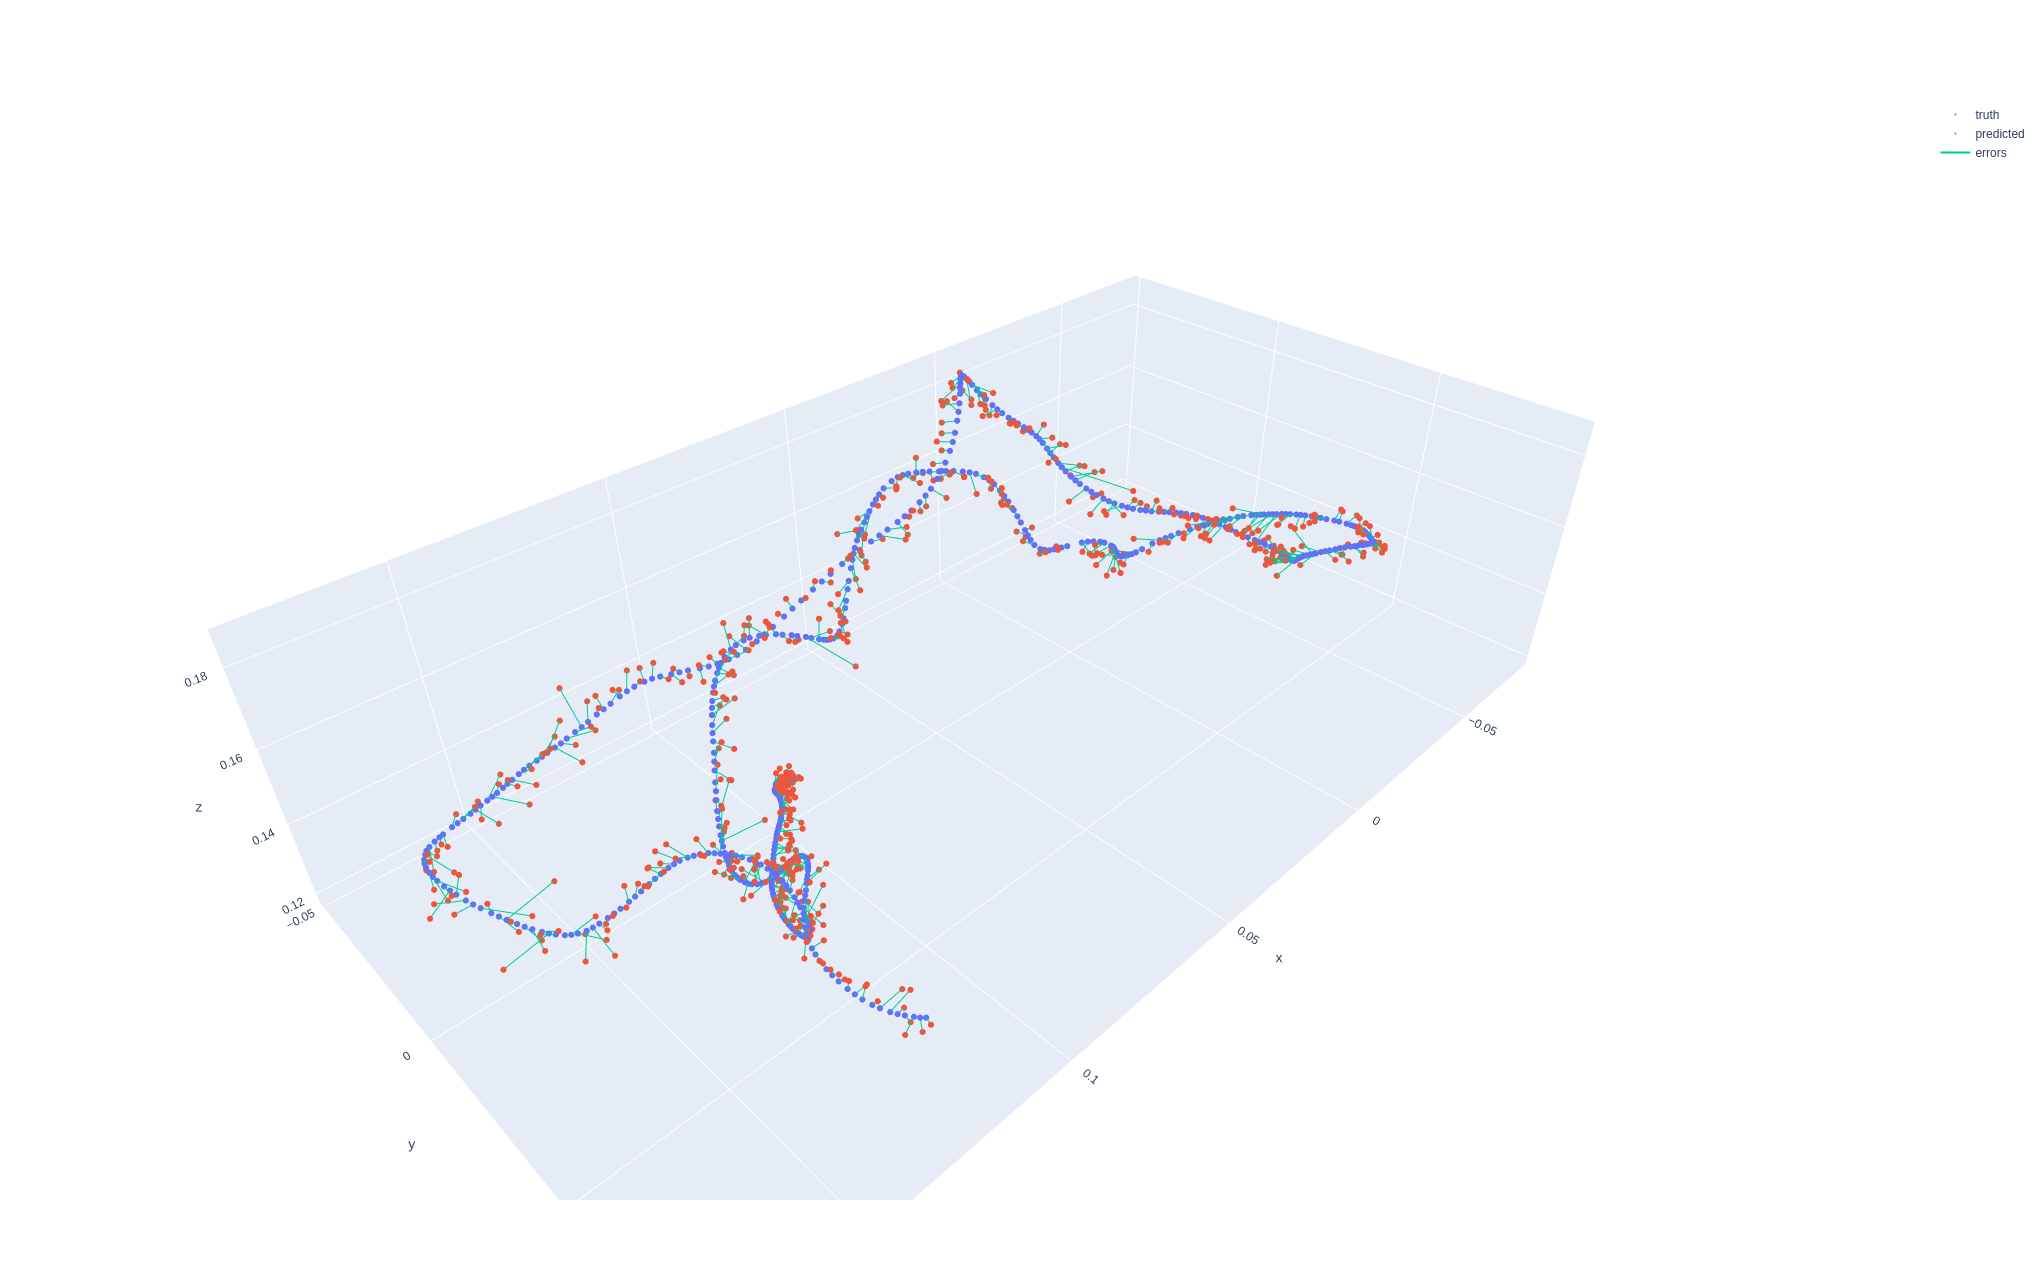

In [22]:
show_trajectories(np.array(gt_poses)[:, 3, :3], np.array(poses)[:, 3, :3])

In [72]:
poses[0]

array([[ 0.8735127 ,  0.48643783,  0.01880984,  0.        ],
       [ 0.34341863, -0.58838165, -0.73203176,  0.        ],
       [-0.3450206 ,  0.64589864, -0.6810106 ,  0.        ],
       [ 0.13191056,  0.08617777,  0.15277901,  1.        ]],
      dtype=float32)

In [73]:
gt_poses[0]

array([[ 0.8722986 ,  0.4882979 ,  0.02569568,  0.        ],
       [ 0.34789497, -0.58283824, -0.73434913,  0.        ],
       [-0.34360474,  0.64951116, -0.67828536,  0.        ],
       [ 1.3112    ,  0.8507    ,  1.5186    ,  1.        ]],
      dtype=float32)